In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, e
import scipy.stats as stats
import random

In [2]:
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

# The Data

## Normal

In [3]:
def get_truncated_normal(upp, mean=0, sd=1, low=0):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [4]:
def normal(d, mean, std, start, n):
    gen = get_truncated_normal(d, mean, std, start)
    data = gen.rvs(n).astype(int)

    return data

[65 32 64 ...  8 81 24]
53    199
44    187
52    179
55    176
47    174
     ... 
3      26
0      26
97     23
98     22
1      19
Name: count, Length: 100, dtype: int64


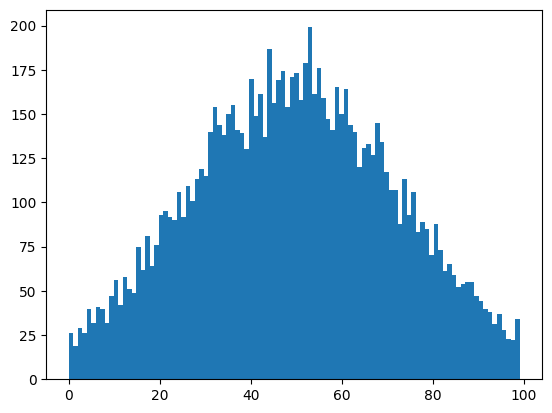

In [5]:
data2 = normal(100, 50, 25, 0, 10**4)
plt.hist(data2, bins=100)
print(data2)
print(pd.Series(data2).value_counts())

## Zipf

In [6]:
def zipf(a, n, d):
    x = np.arange(0, d)

    weights = (x+1) ** (-a)
    weights /= weights.sum()
    bounded_zipf = stats.rv_discrete(name='bounded_zipf', values=(x, weights))
    
    sample = bounded_zipf.rvs(size=n)

    return sample

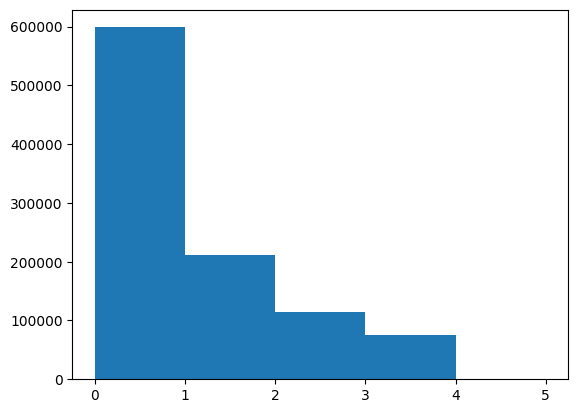

[0 0 0 ... 1 2 0]
0    598805
1    211205
2    115167
3     74823
Name: count, dtype: int64


In [7]:
data = zipf(1.5, 10**6, 4)
plt.hist(data, bins=np.arange(0, 4+2))
plt.show()
print(data)
print(pd.Series(data).value_counts())

## Response getter

In [8]:
#gives you the responses, taht is , the frequency of each domain
#returns the responses
def get_responses(distribution_func, **kwargs):
    d = kwargs.get('d', 1)
    domain = [i for i in range(0, d)]
    responsesN = distribution_func(**kwargs)
    
    r = np.zeros(d)
    
    for i in responsesN:
        r[i] += 1

    r = r.astype(int)
    
    return r

##### debugg

In [9]:
normal_args = {
    'd': 10,
    'mean': 10/2,
    'std': 10/4,
    'start': 0,
    'n': 10**6
}

a = get_responses(normal,**normal_args)
print(sum(a))

1000000


In [10]:
zipf_args = {
    'd': 4,
    'n': 10**6,
    'a': 1.5
}

b = get_responses(zipf, **zipf_args)
print(sum(b))

1000000


# Algorithms

## DP

In [11]:
def laplace_mech(answer, sensitivity, epsilon):
    return answer + np.random.laplace(loc=0, scale=sensitivity / epsilon)

## LDP

In [12]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

### UE

In [13]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [14]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [15]:
def perturb_onto_agg(responses, p , q):
    noisy_responses = np.zeros(len(responses))
    #print("SOMA: ",sum(responses))
    
    for i in range(len(responses)):
        #print("i",i)
        for j in range(responses[i]):
            #print("j",j)
            for k in range(len(noisy_responses)):
                #print("k",k)
                #works hence the internal for iterates each one time for a singular unit
                sample = np.random.random()
                
                #case bit is 1(same cell, therefore using p)
                if i == k:
                    #print("here")
                    if sample <= p:
                        #tell the turht
                        #by adding 1 to the i(k) position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else:
                        #lie
                        #by not adding anything to the vector
                #handles other cells(using q probability)
                else:
                    #print("there")
                    if sample <= q:
                        #lie
                        #by summing 1 onto the k position of the noisy vector
                        noisy_responses[k] = noisy_responses[k] + 1
                    #else: 
                        #truth
                        #by omiting form it
    return noisy_responses

In [16]:
def adjustUE(noisy_responses, p, q, n):
    d = len(noisy_responses)
    copyUE = noisy_responses.copy().astype(int)
    
    for i in range(len(copyUE)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copyUE[i] = a * copyUE[i] - b

    return copyUE

In [17]:
def UEresponses(responses, epsilon):
    p, q = symetric_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p ,q, n)

### OUE

In [18]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

In [19]:
def OUEresponses(responses, epsilon):
    p, q = optimized_p_q(epsilon)
    n = sum(responses)
    return adjustUE(perturb_onto_agg(responses, p, q), p, q, n)  

### DE

In [20]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [21]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]
    return random.choice(domain_q)

In [22]:
def randomized_responses_DE(responses, epsilon):
    d = len(responses)
    domain = [i for i in range(0, d)]
    p, q = DE_p_q(epsilon, d)

    noisy_responses = np.zeros(len(responses))
    for i in range(len(responses)):
        for j in range(responses[i]):
            sample = np.random.random()

            if sample <= p:
                #tell the truth
                #by adding to noisy_responses in the i position
                noisy_responses[i] = noisy_responses[i] + 1

            else:
                #lie
                #by adding to noisy_responses in any position but i 
                any_pos_but_i = random_pick_DE(domain, i)
                noisy_responses[any_pos_but_i] = noisy_responses[any_pos_but_i] + 1

    return noisy_responses

In [23]:
def adjustDE(noisy_responses, epsilon, n):
    d = len(noisy_responses)
    p, q = DE_p_q(epsilon, d)
    copy = noisy_responses.copy().astype(int)
    
    for i in range(len(copy)):
        a = 1.0 / (p - q)
        b = n * q / (p - q)
        copy[i] = a * copy[i] - b

    return copy

In [24]:
def DEresponses(responses, epsilon):
    n = sum(responses)
    return adjustDE(randomized_responses_DE(responses, epsilon), epsilon, n)

# Metrics

In [25]:
def metrics(exact, approx):
    if len(exact) != len(approx):
        raise ValueError("The length must be the same.")

    mse = np.mean([(exact[i] - approx[i])**2 for i in range(len(exact))])
    return mse

# Control test (Compare optmized algorithm wiht previous ones)

In [26]:
normal_args = {
    'd': 10,
    'mean': 5,
    'std': 2.5,
    'start': 0,
    'n': 10**4
}

epsilon = 2
d = normal_args.get('d', 1)
domain = [i for i in range(0, d)]

responses = get_responses(normal, **normal_args)

responsesUE =  UEresponses(responses, epsilon)
responsesOUE = OUEresponses(responses, epsilon)
responsesDE = DEresponses(responses, epsilon)

print("Frequência verdadeira: ", responses)
#responsesOUE = [int(x) for x in responsesOUE]
print("Ruído OUE: ", responsesOUE)
print(sum(responsesOUE))
#responsesUE = [int(x) for x in responsesUE]
print("Ruído UE: ", responsesUE)
#responsesDE = [int(x) for x in responsesDE]
print("Ruído DE: ", responsesDE)
print(sum(responsesDE))

Frequência verdadeira:  [ 317  610  982 1380 1562 1688 1423 1045  660  333]
Ruído OUE:  [ 362  687  989 1628 1457 1583 1572  929  567  333]
10107
Ruído UE:  [ 189  574  775 1520 1366 1788 1321 1083  717  258]
Ruído DE:  [ 174  656 1048 1392 1582 1805 1294  964  643  438]
9996


# LDP vs DP 

## big function

In [66]:
#1 is the whole of the perturbed vector
def norm_sub(estimations):
    
    f_tilde = np.array(estimations, dtype=float)
    total = sum(estimations)

    for i in range(len(estimations)):
        f_tilde[i] /= total

    print(f_tilde)
    print(sum(f_tilde))

    delta = 0
    while True:
        trans = np.maximum(f_tilde + delta, 0)
        if np.sum(trans >= 1):
            break
        delta += 1e-6

    f_0 = np.maximum(f_tilde + delta, 0)

    if np.sum(f_0) > 0:
        f_0 /= np.sum(f_0)

    for i in range(len(estimations)):
        f_0[i] *= total
    
    return f_0, delta

In [1]:
#actual
def act_norm_sub(estimations, Truth_total):
    f_tilde = np.array(estimations, dtype=float)  # Convert to a numpy arra
    #print(f_tilde)
    #converts negative values to 0
    f_tilde[f_tilde < 0] = 0
    #print(f_tilde)

    for i in range(len(f_tilde)):
        f_tilde[i] /= Truth_total

    #print(f_tilde)
    #print(sum(f_tilde))
        
    #maintains overall sum to 1, adding delta to each REMAINING VALUE
    delta = 0
    while sum(f_tilde) < 1:
        non_zero_indices = f_tilde > 0  # Identify non-zero elements
        f_tilde[non_zero_indices] += delta
        delta += 1e-11  # Small delta to ensure convergence
    #print(f_tilde)
    #print(sum(f_tilde))
    
    return (f_tilde*Truth_total).astype(int)

In [59]:
counts_truth = [450, 180, 20, 5]
estimations = [300, 100, 50, -10]



norm_ve = act_norm_sub(estimations, sum(counts_truth))
print("PO applied estimations: ", norm_ve)
print(sum(norm_ve))
print(sum(counts_truth))

for i in range(len(counts_truth)):
    counts_truth[i] /= sum(counts_truth)
print(counts_truth)

[0.45801527 0.15267176 0.07633588 0.        ]
PO applied estimations:  [368 168 118   0]
654
655
[0.6870229007633588, 0.8751159769901651, 0.7529514129884517, 0.6835185624882896]


In [70]:
# 5 times
def meid(data_func, times, **kwargs):
    d = kwargs.get('d', 1) 
    domain = [i for i in range(0, d)]

    responses = get_responses(data_func, **kwargs)

    epsilon_sum = None
    mseOUE_sum = None
    mseDE_sum = None
    mseLA_sum = None

    POmseOUE_sum = None
    POmseDE_sum = None

    for i in range(times):
        epsilon_values, mse_valuesOUE, mse_valuesDE, mse_valuesLA, POmse_valuesOUE, POmse_valuesDE = comparator2(responses, d)
        
        if epsilon_sum is None:
            epsilon_sum = np.zeros(len(epsilon_values))
            mseOUE_sum = np.zeros(len(mse_valuesOUE))
            mseDE_sum = np.zeros(len(mse_valuesDE))
            mseLA_sum = np.zeros(len(mse_valuesLA))

            POmseOUE_sum = np.zeros(len(POmse_valuesOUE))
            POmseDE_sum = np.zeros(len(POmse_valuesDE))

        epsilon_sum = [x + y for x, y in zip(epsilon_sum, epsilon_values)]
        mseOUE_sum = [x + y for x, y in zip(mseOUE_sum, mse_valuesOUE)]
        mseDE_sum = [x + y for x, y in zip(mseDE_sum, mse_valuesDE)]
        mseLA_sum = [x + y for x, y in zip(mseLA_sum, mse_valuesLA)]

        POmseOUE_sum = [x + y for x, y in zip(POmseOUE_sum, POmse_valuesOUE)]
        POmseDE_sum = [x + y for x, y in zip(POmseDE_sum, POmse_valuesDE)]


    epsilon_avg = [x / times for x in epsilon_sum]
    mseOUE_avg = [x / times for x in mseOUE_sum]
    mseDE_avg = [x / times for x in mseDE_sum]
    mseLA_avg = [x / times for x in mseLA_sum]

    POmseOUE_avg = [x / times for x in POmseOUE_sum]
    POmseDE_avg = [x / times for x in POmseDE_sum]

    return epsilon_avg, mseOUE_avg, mseDE_avg, mseLA_avg, POmseOUE_avg, POmseDE_avg

In [71]:
def comparator2(responses, d):
    mse_valuesDE = []
    mse_valuesOUE = []
    mse_valuesLA = []
    
    POmse_valuesDE = []
    POmse_valuesOUE = []

    epsilon_values = []

    Truth_total = sum(responses)

    for i in np.arange(0.1, 5.1, 0.5):
        epsilon = i
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, d)
        
        ## no post processing
        ##--------------------------------------------------------------
        responsesOUE = OUEresponses(responses, epsilon)
        responsesDE = DEresponses(responses, epsilon)

        responsesLA = laplace_mech(responses, 1, epsilon/d)
        ##--------------------------------------------------------------

        ## norm-sub post processing
        ##--------------------------------------------------------------
        POresponsesOUE = act_norm_sub(responsesOUE, Truth_total)
        POresponsesDE = act_norm_sub(responsesDE, Truth_total)

        ##--------------------------------------------------------------
    
        mseOUE = metrics(responses, responsesOUE)
        mseDE = metrics(responses, responsesDE)
        mseLA = metrics(responses, responsesLA)
        
        POmseOUE = metrics(responses, POresponsesOUE)
        POmseDE = metrics(responses, POresponsesDE)
    
        mse_valuesOUE.append(mseOUE)
        mse_valuesDE.append(mseDE)
        mse_valuesLA.append(mseLA)

        POmse_valuesOUE.append(POmseOUE)
        POmse_valuesDE.append(POmseDE)
        
        epsilon_values.append(epsilon)

    return  epsilon_values, mse_valuesOUE, mse_valuesDE, mse_valuesLA, POmse_valuesOUE, POmse_valuesDE

## Norm-sub applied to, plus visual comparison

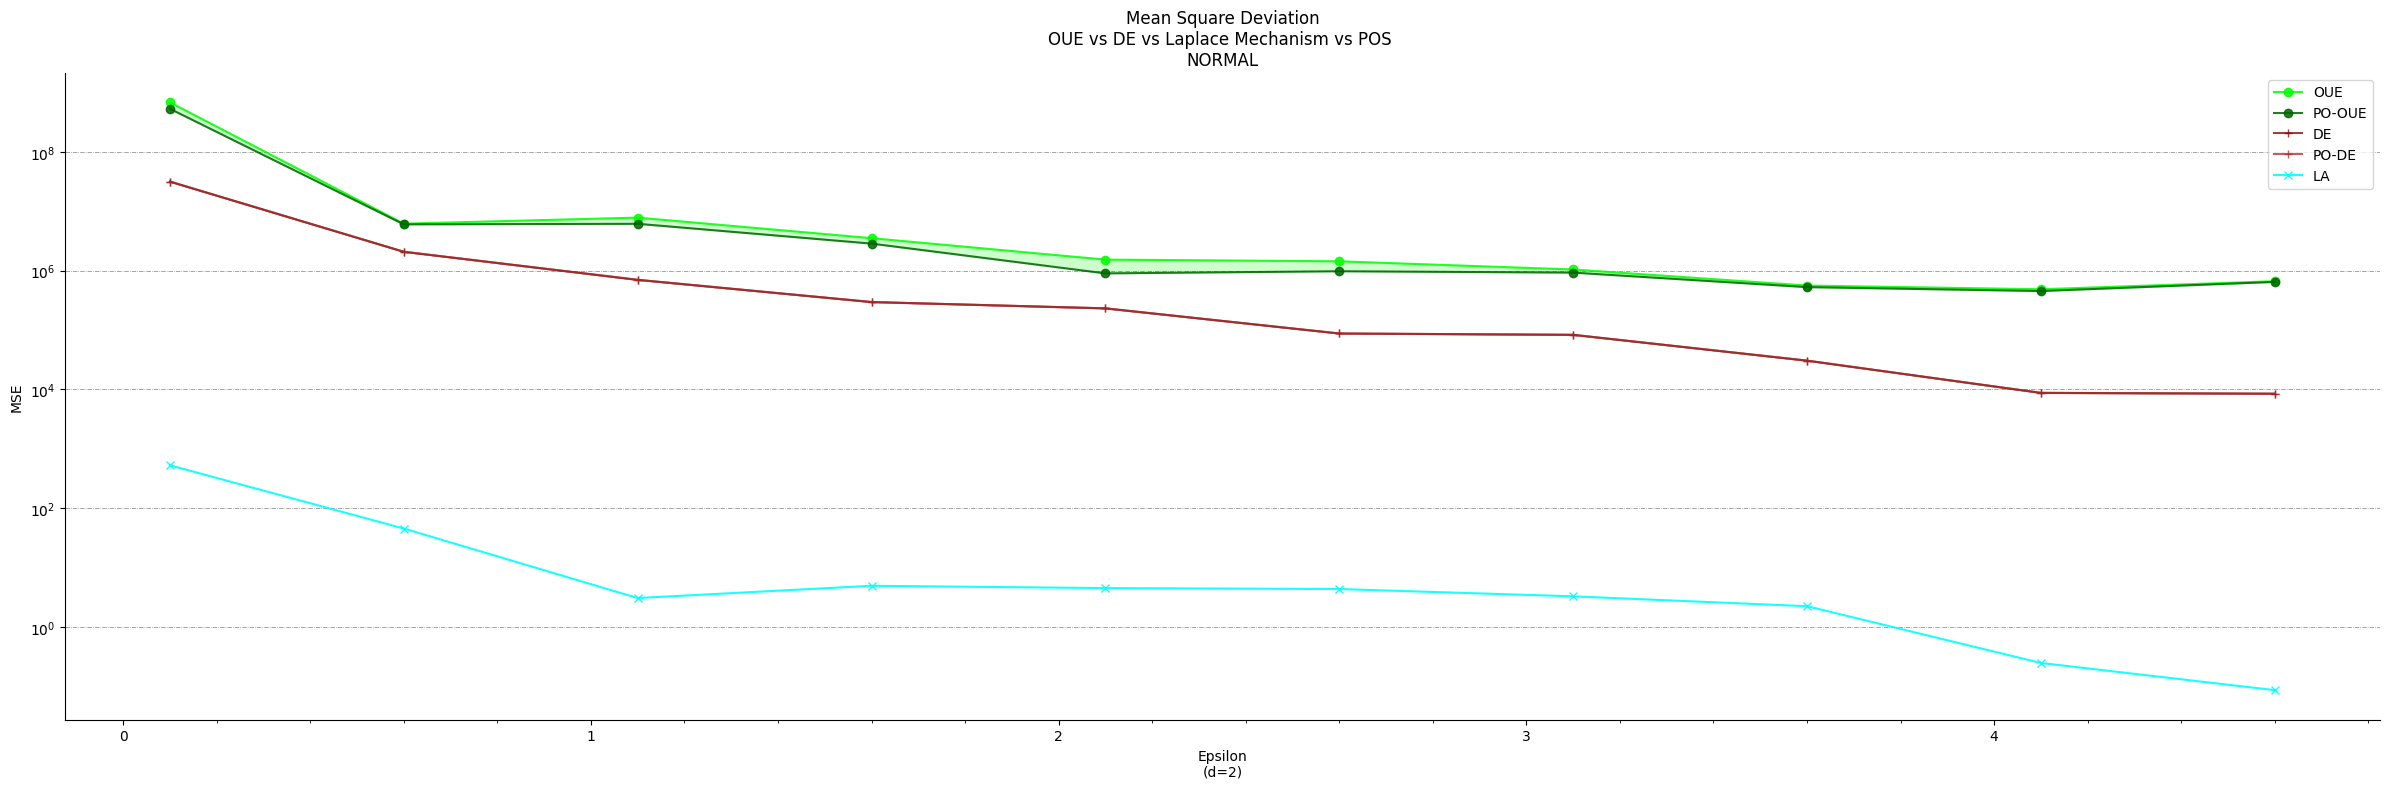

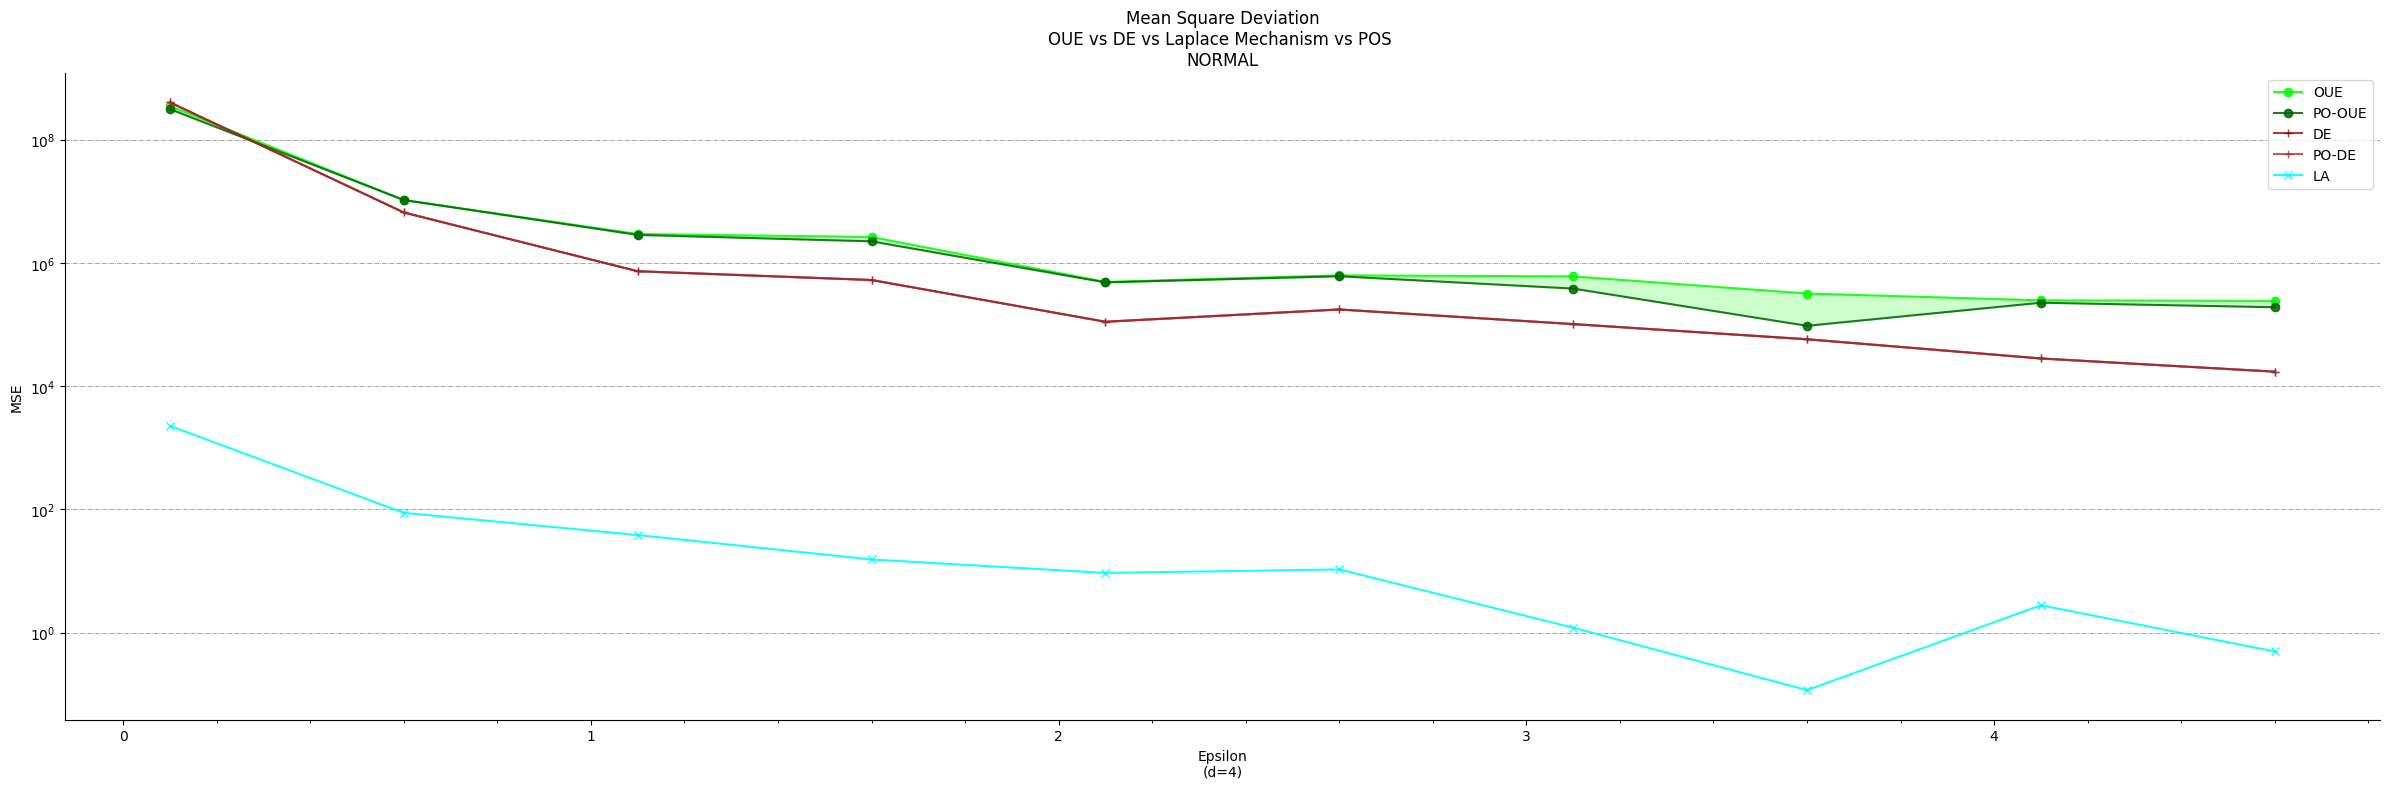

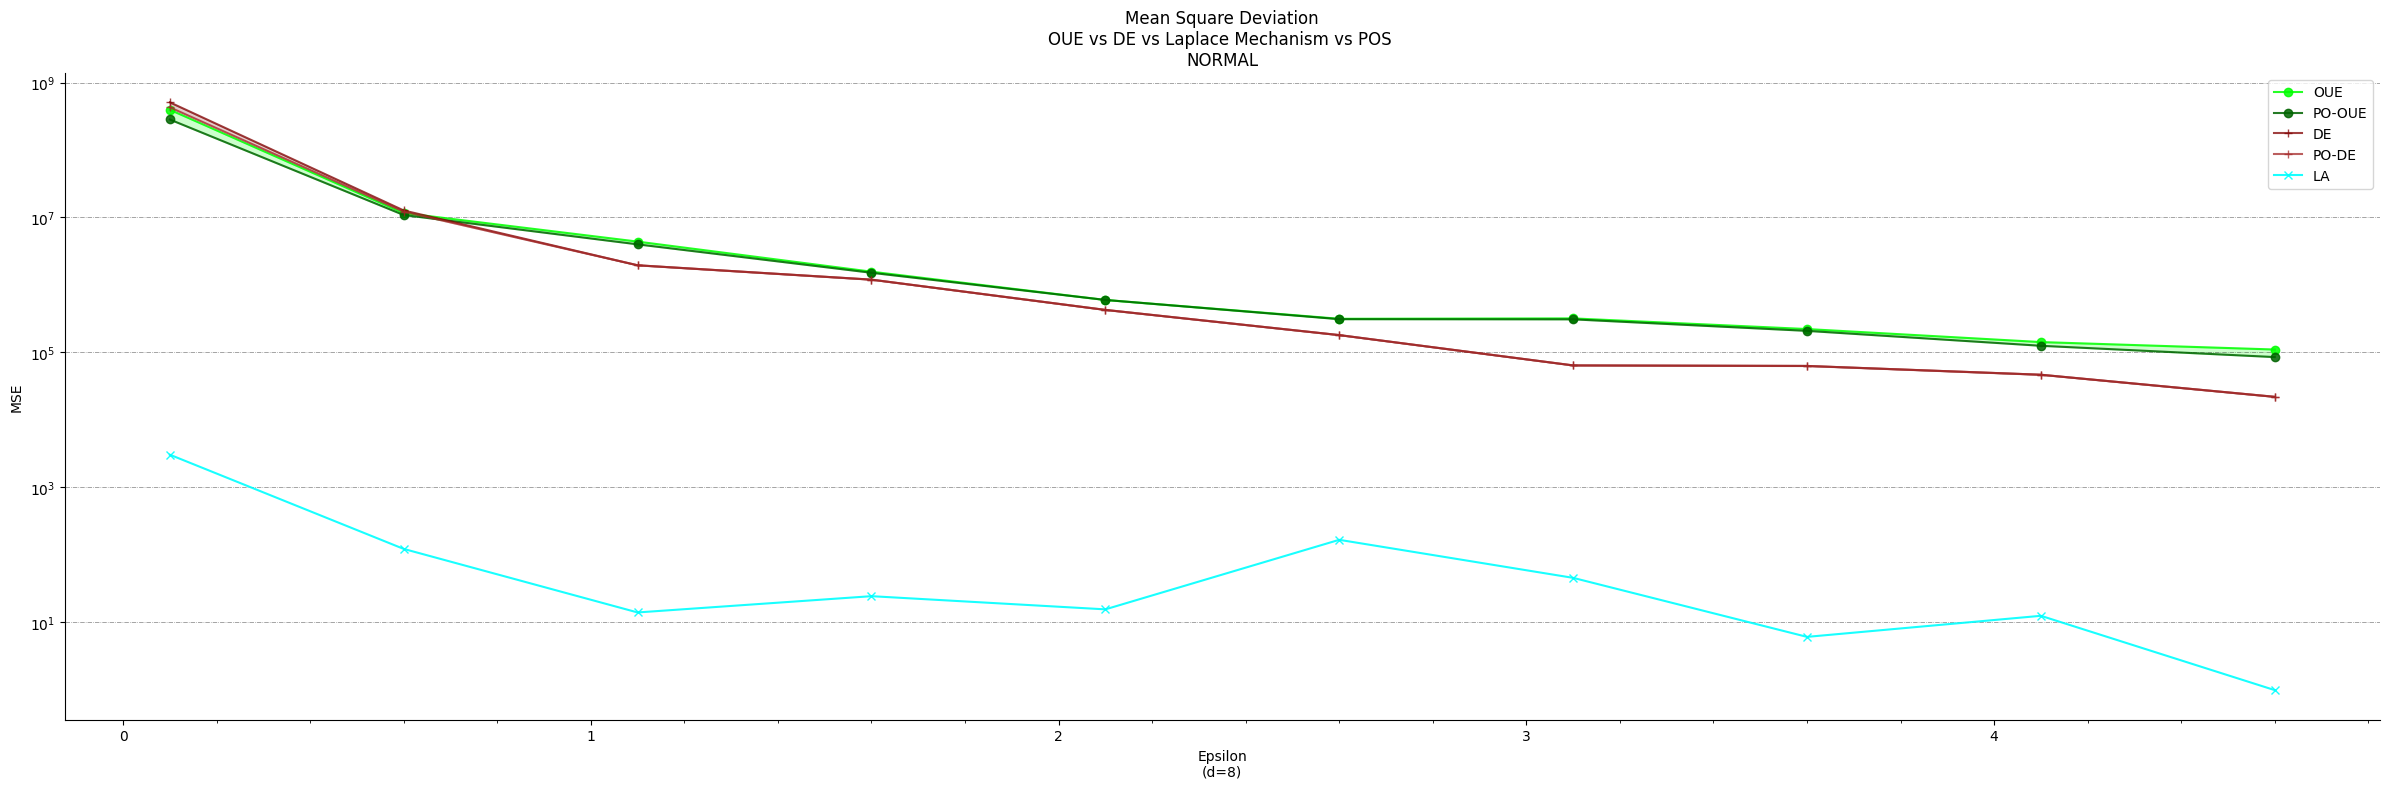

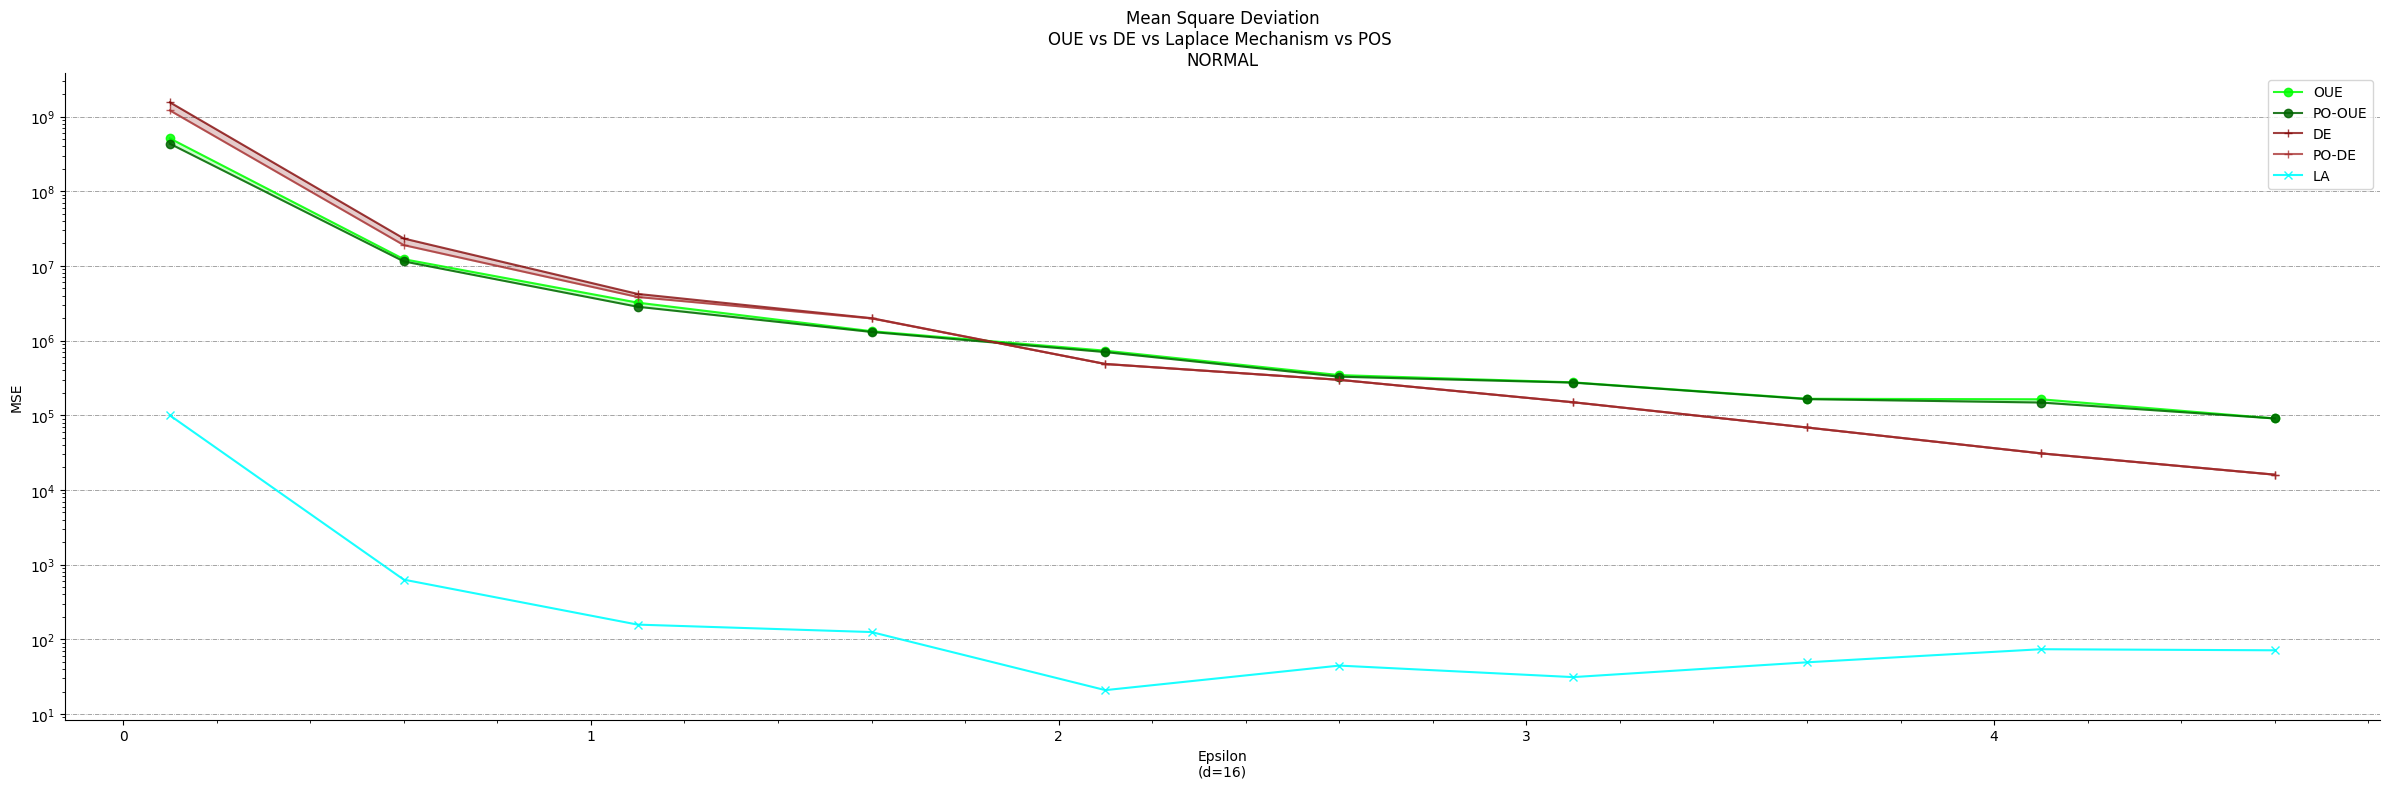

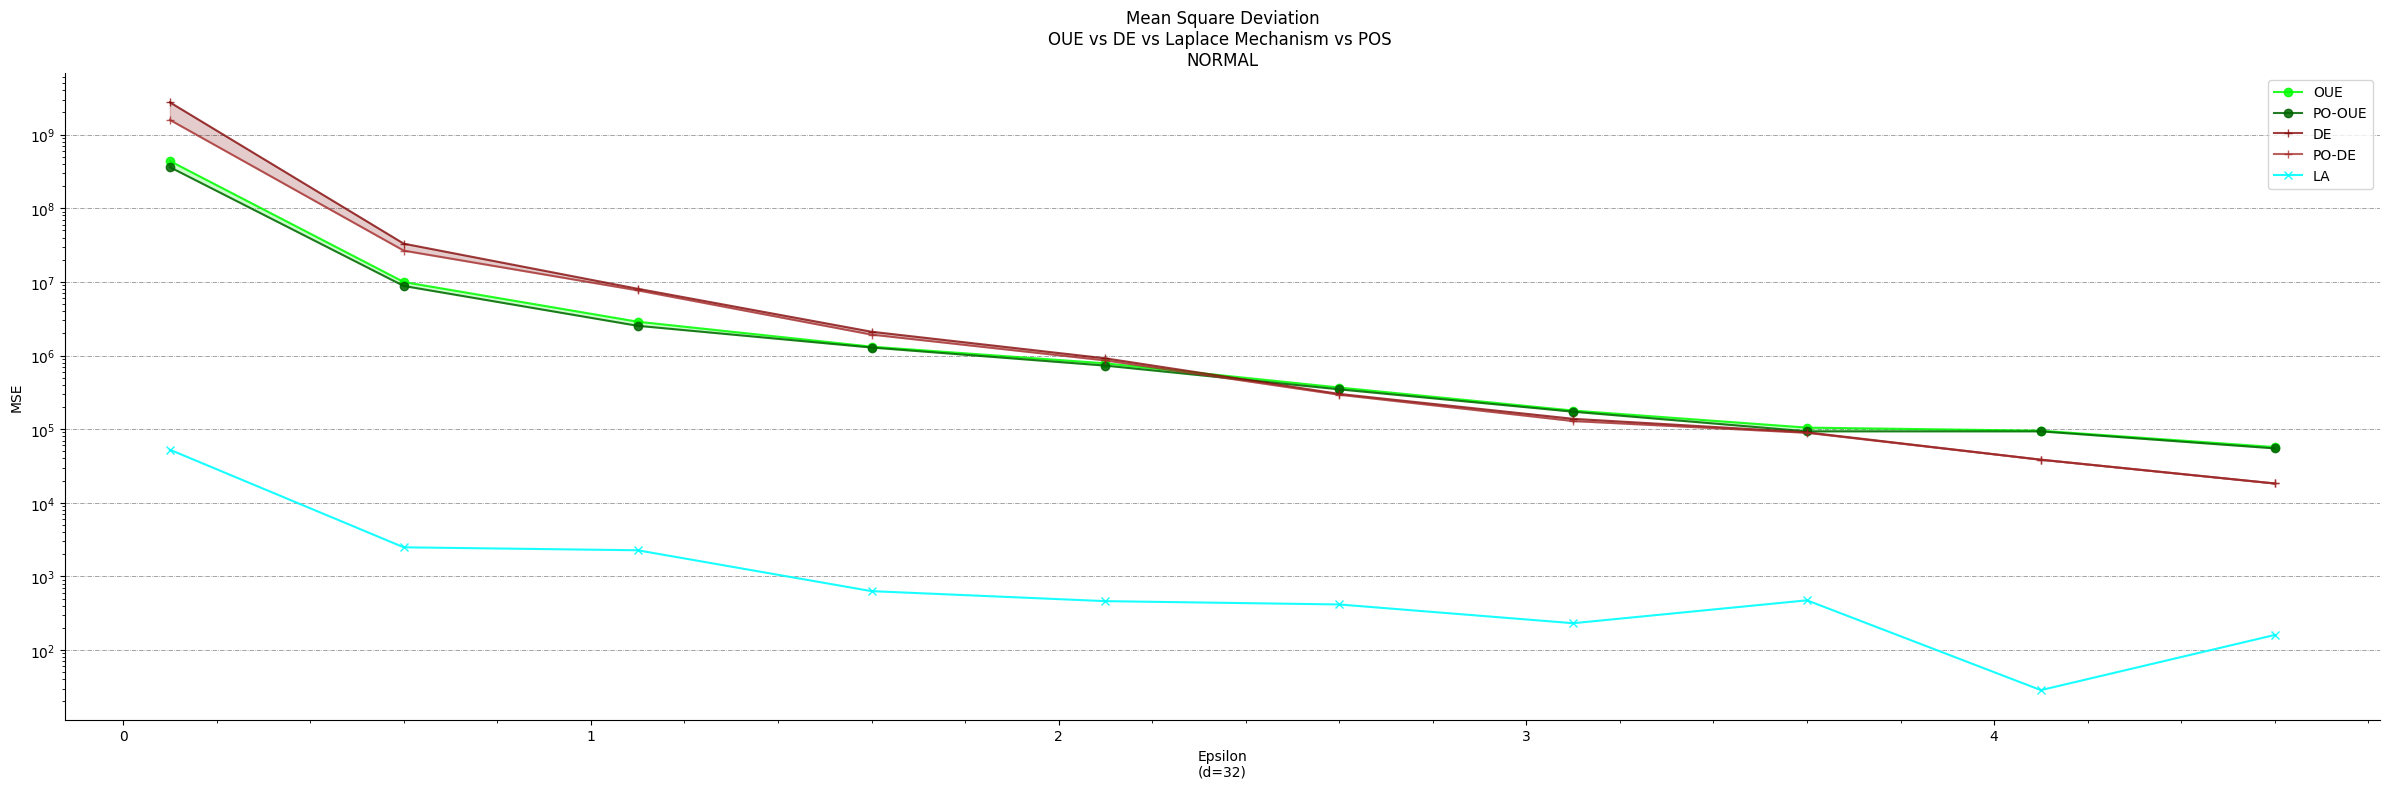

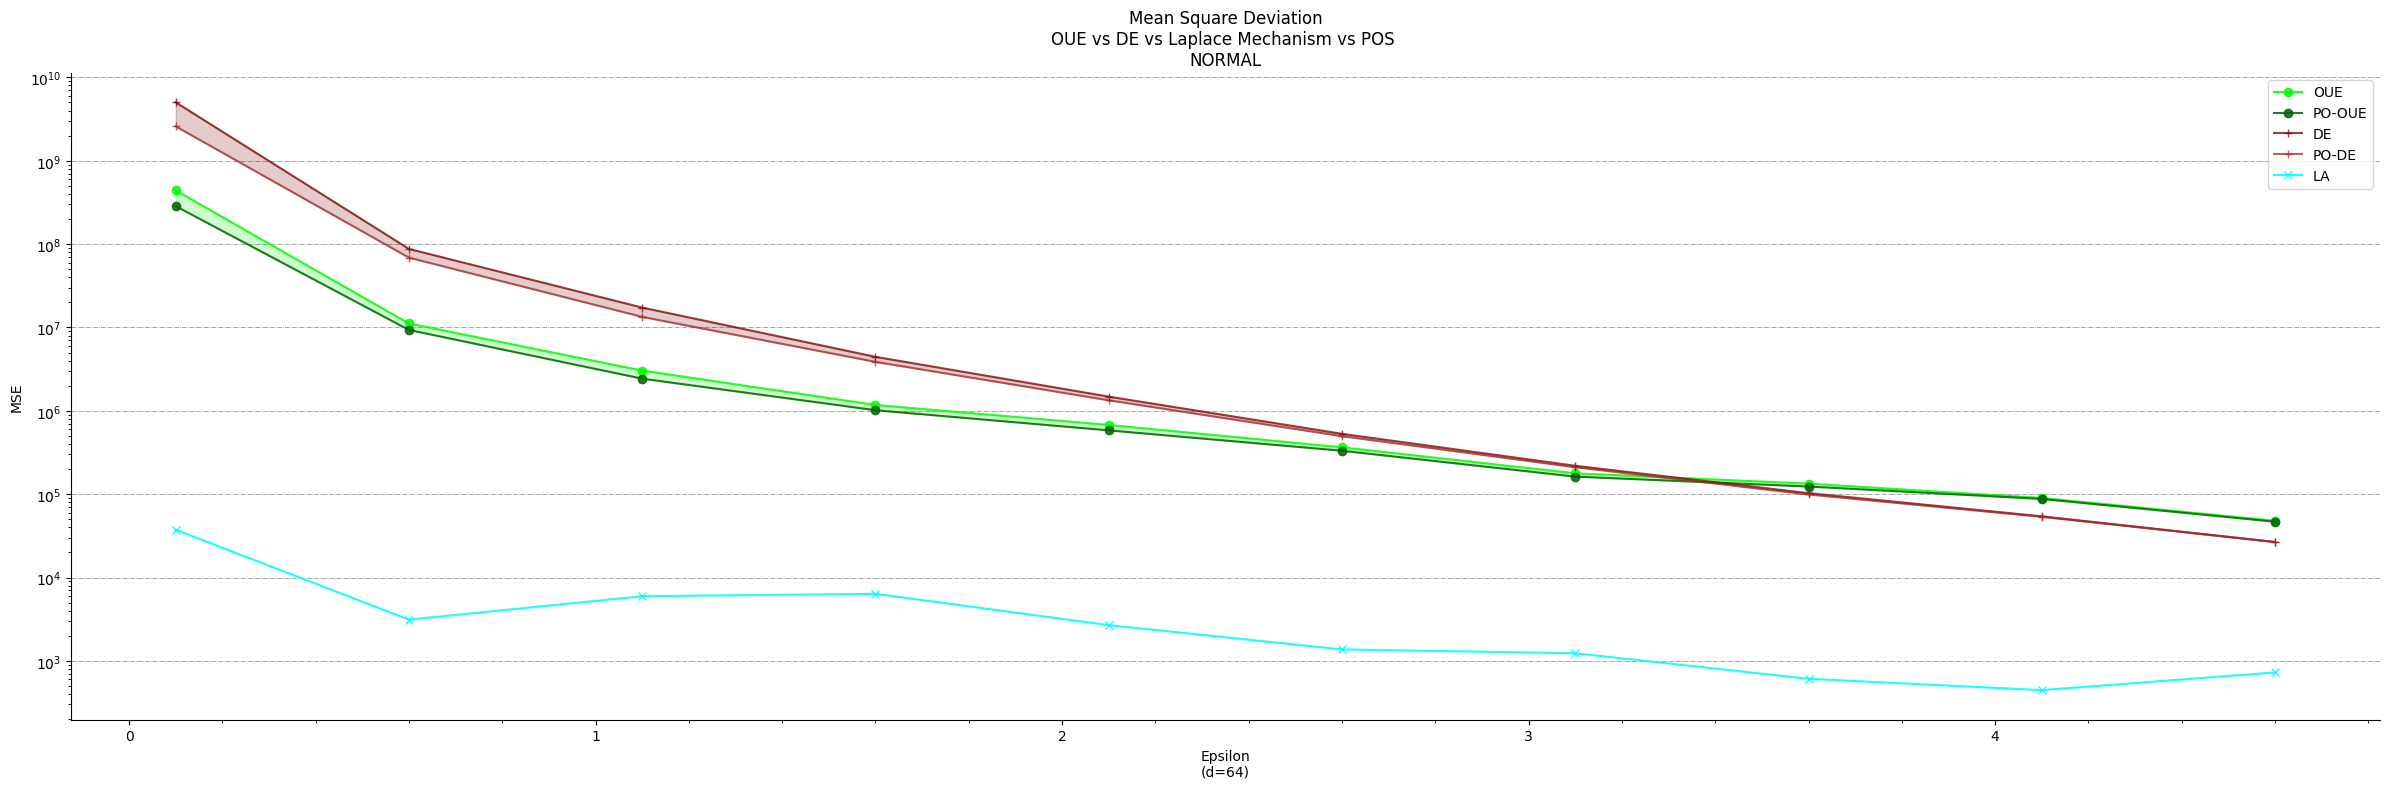

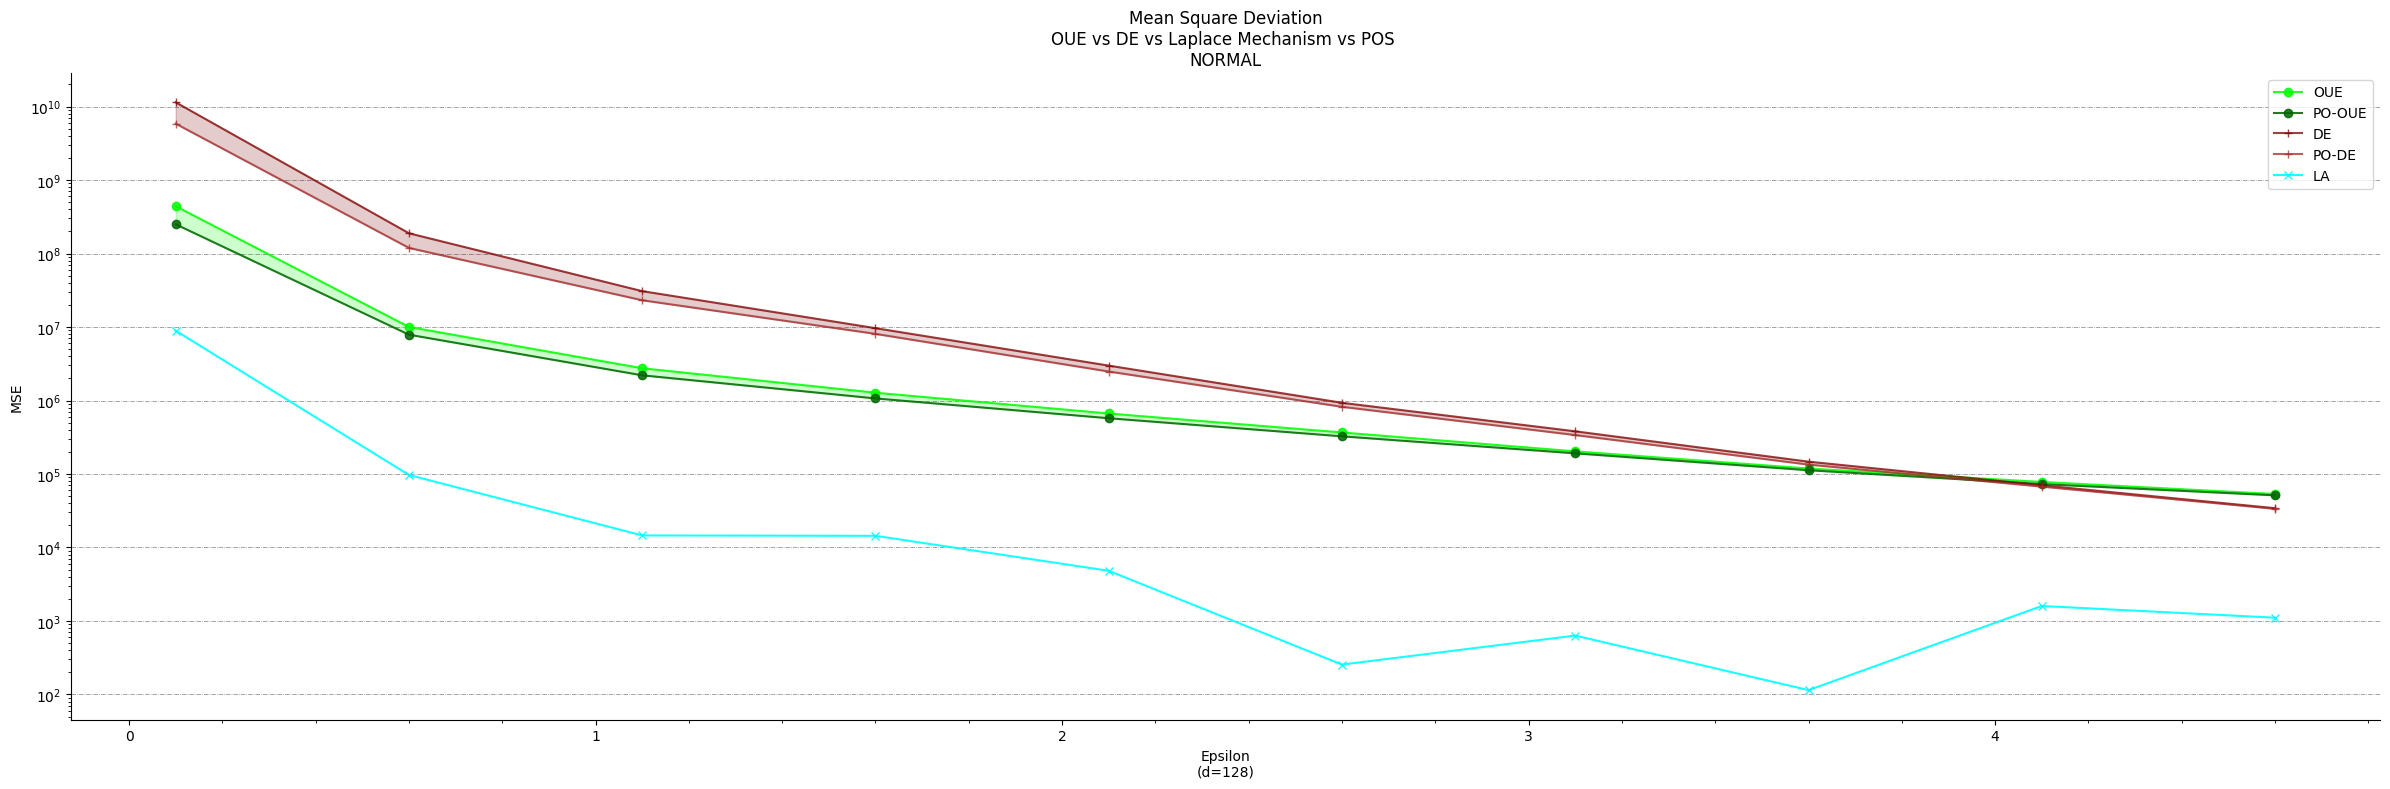

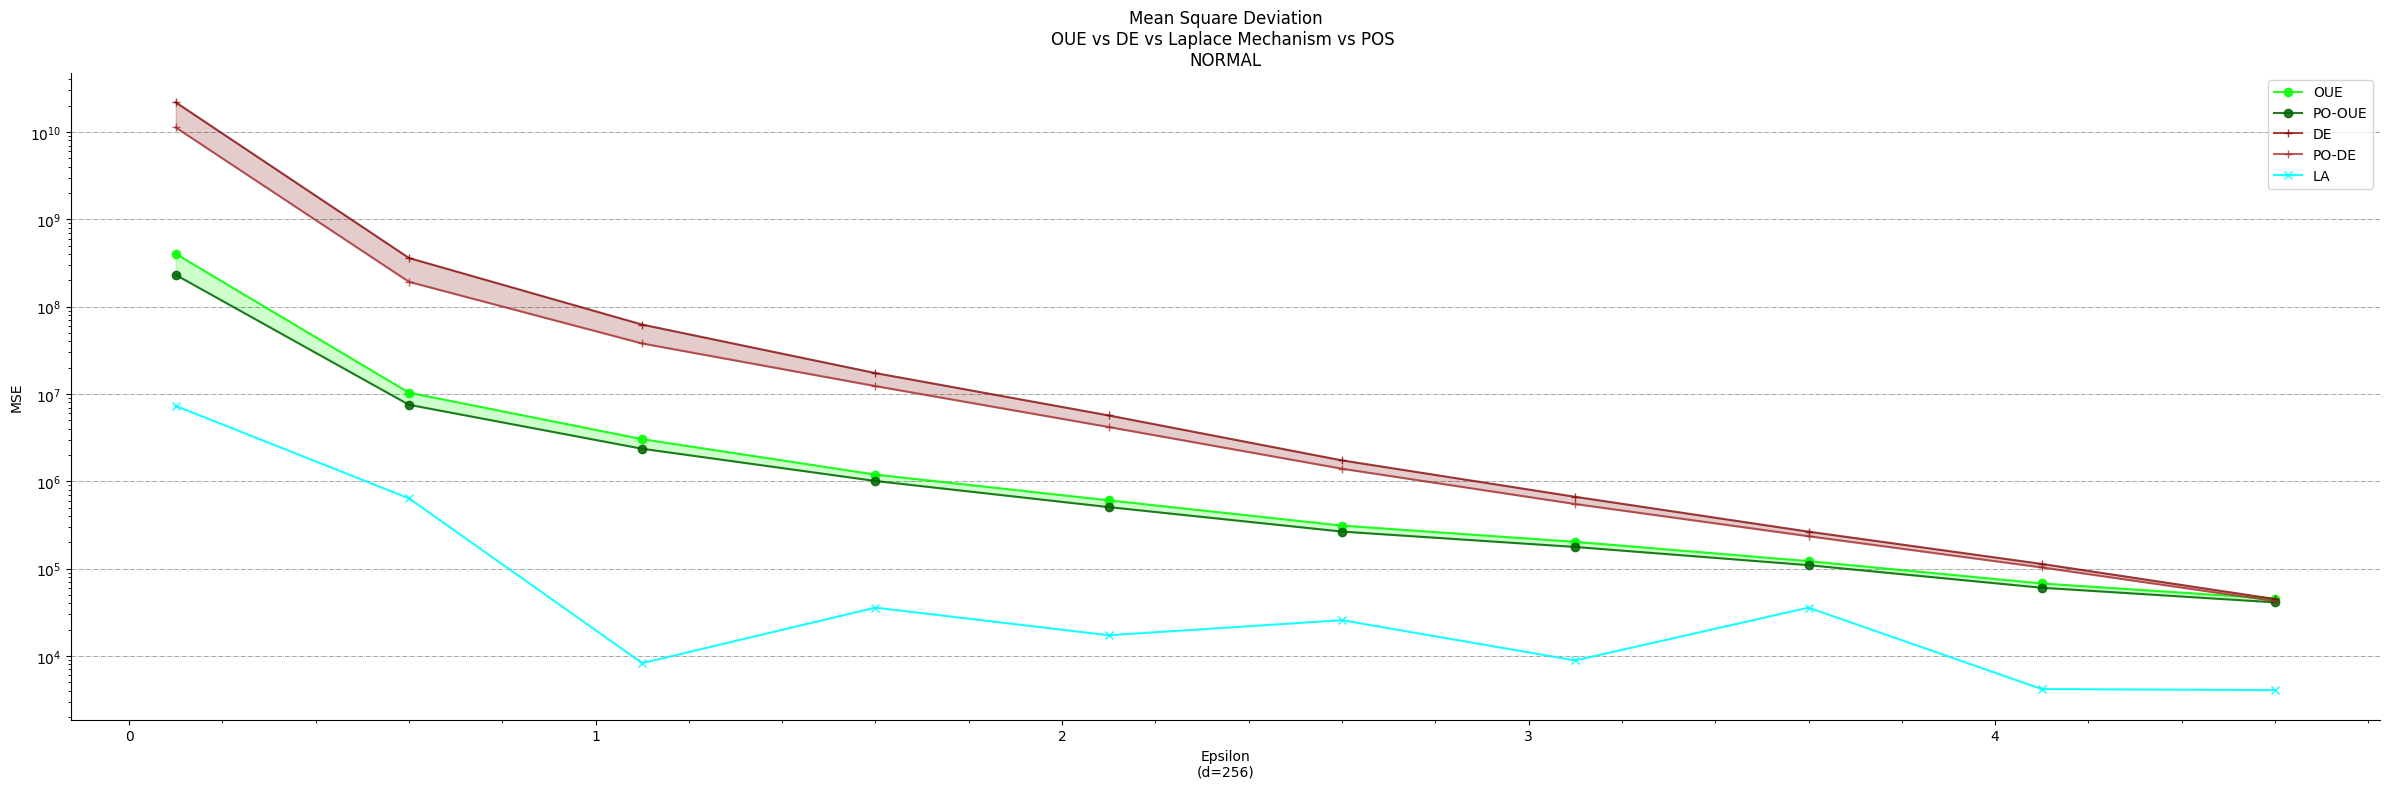

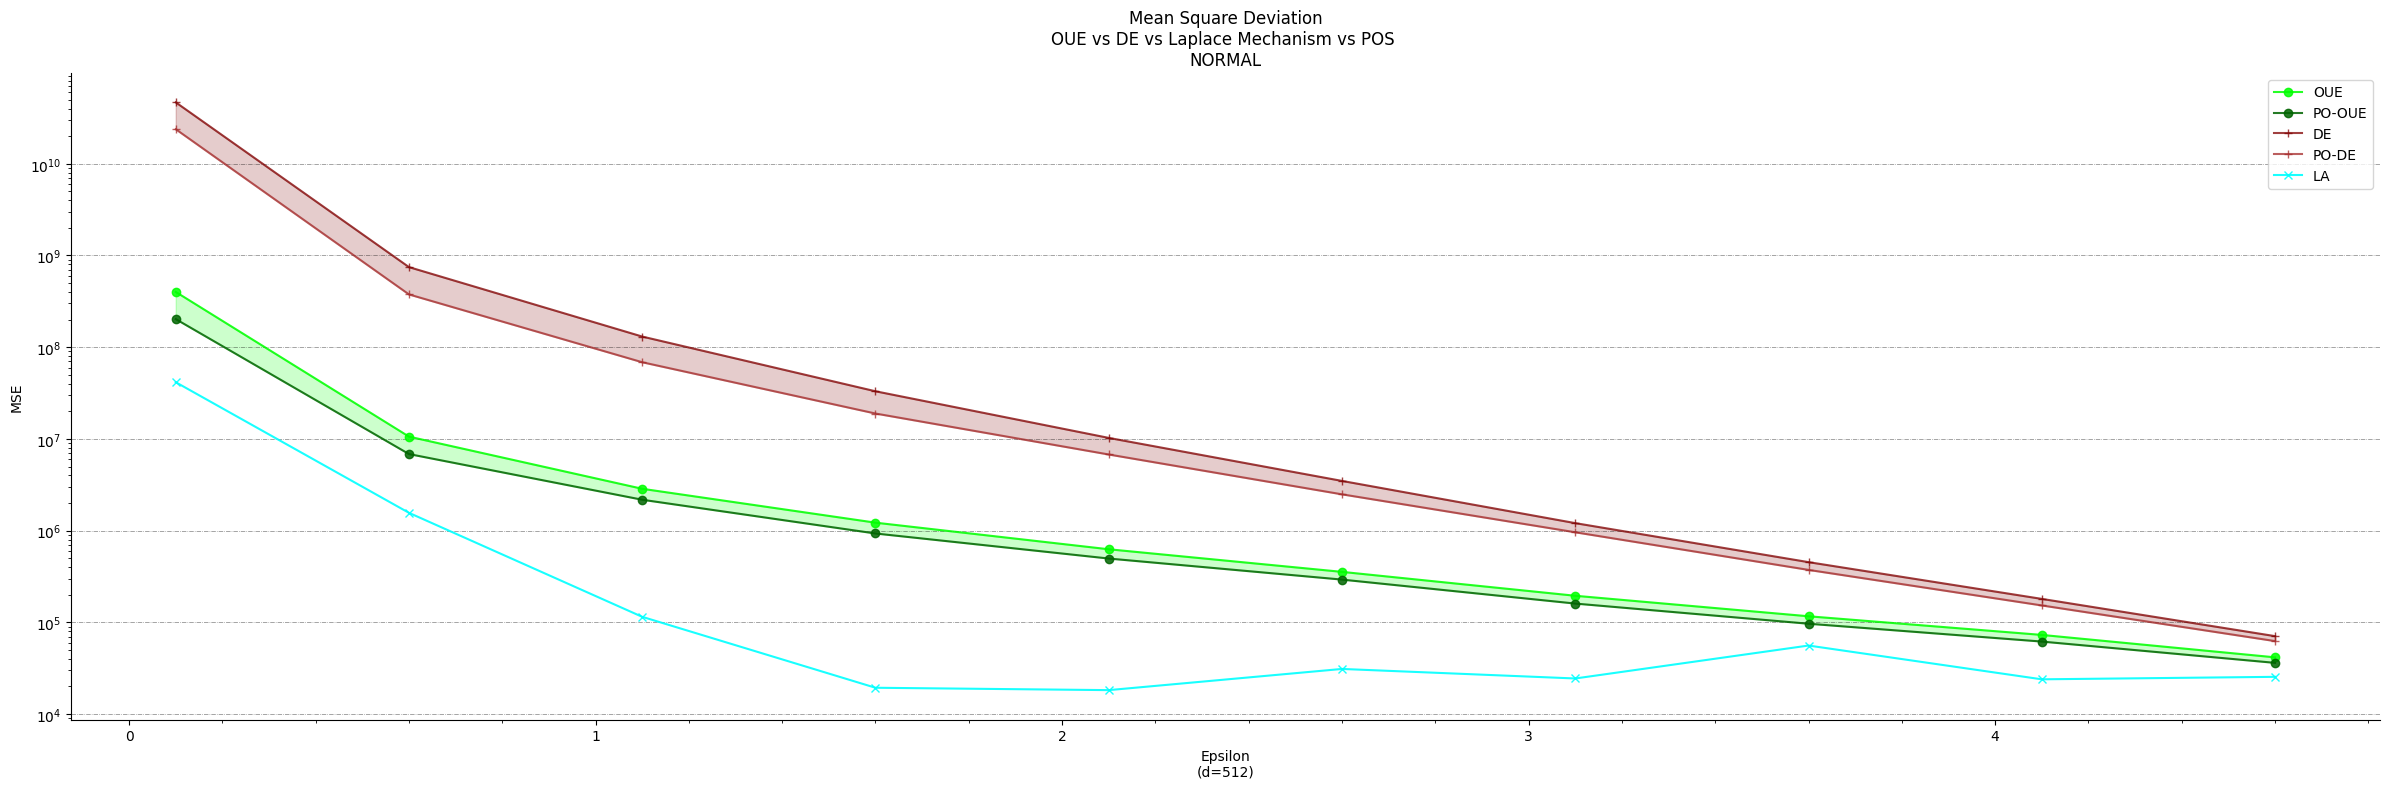

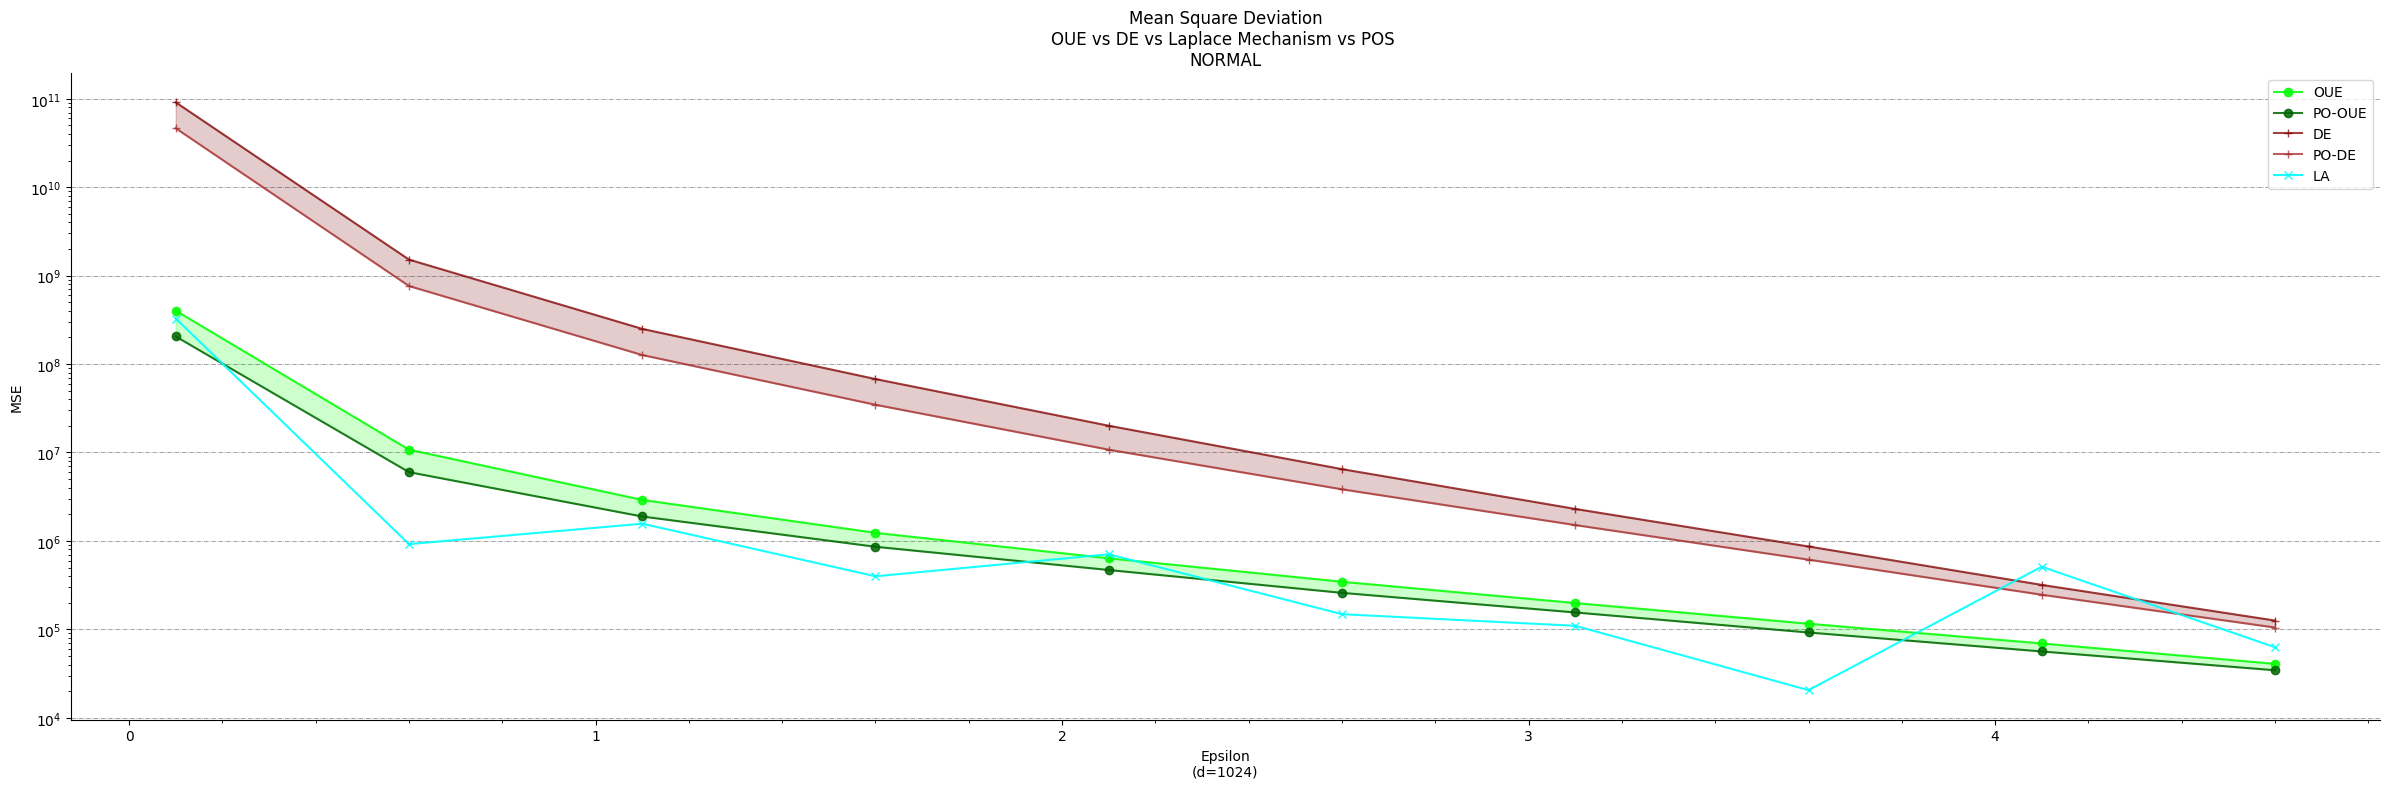

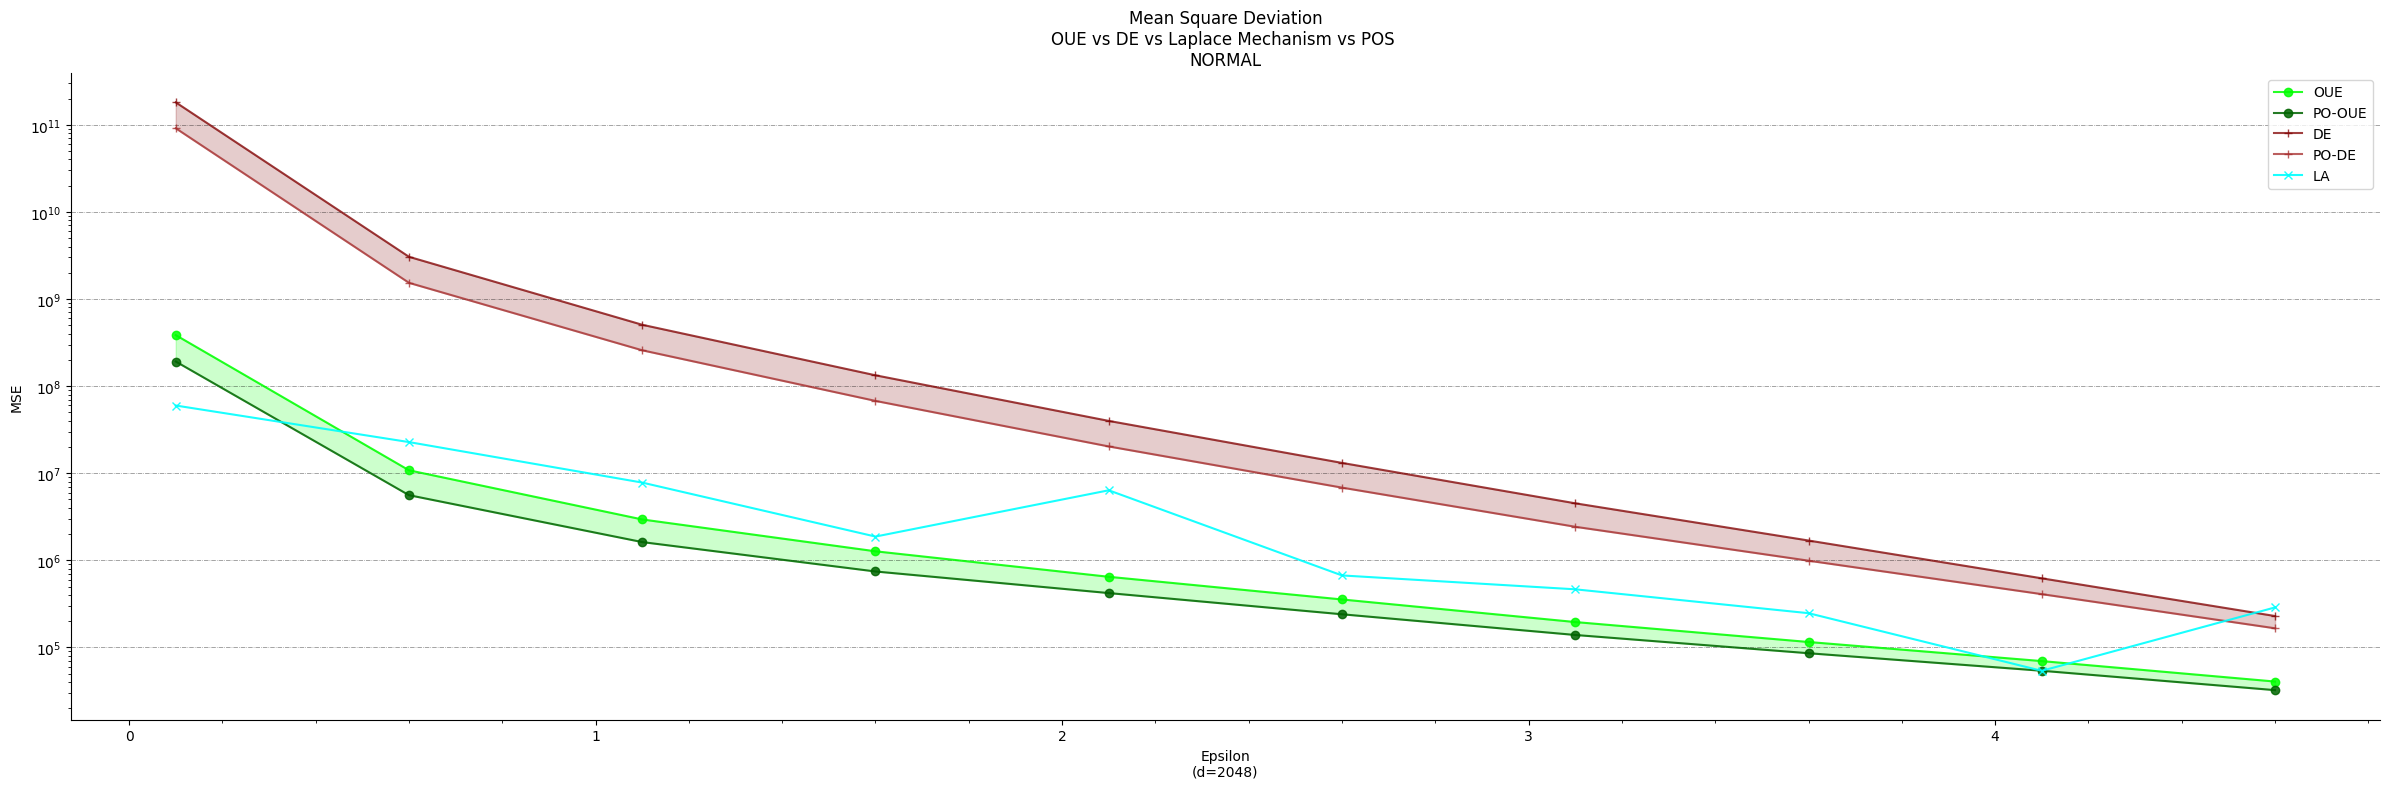

In [76]:
for i in range(1,12):
    d = 2**i

    normal_args = {
        'd': d,
        'mean': d/2,
        'std': d/7,
        'start': 0,
        'n': 10**6
    }
    
    epsilon_avg, mseOUE_avg, mseDE_avg, mseLA_avg, POmseOUE_avg, POmseDE_avg = meid(normal, 4, **normal_args)
    
    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_avg, POmseOUE_avg, marker='o', color='darkgreen', alpha=0.85, label='PO-OUE')
    plt.fill_between(epsilon_avg, mseOUE_avg, POmseOUE_avg, color='lime', alpha=0.2)
    
    plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
    plt.plot(epsilon_avg, POmseDE_avg, marker='+', color='brown', alpha=0.75, label='PO-DE')
    plt.fill_between(epsilon_avg, mseDE_avg, POmseDE_avg, color='maroon', alpha=0.2)
    
    plt.plot(epsilon_avg, mseLA_avg, marker='x', color='cyan', alpha=0.9, label='LA')
    
    plt.title('Mean Square Deviation\nOUE vs DE vs Laplace Mechanism vs POS \nNORMAL')
    plt.xlabel(f'Epsilon\n(d={d})')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()

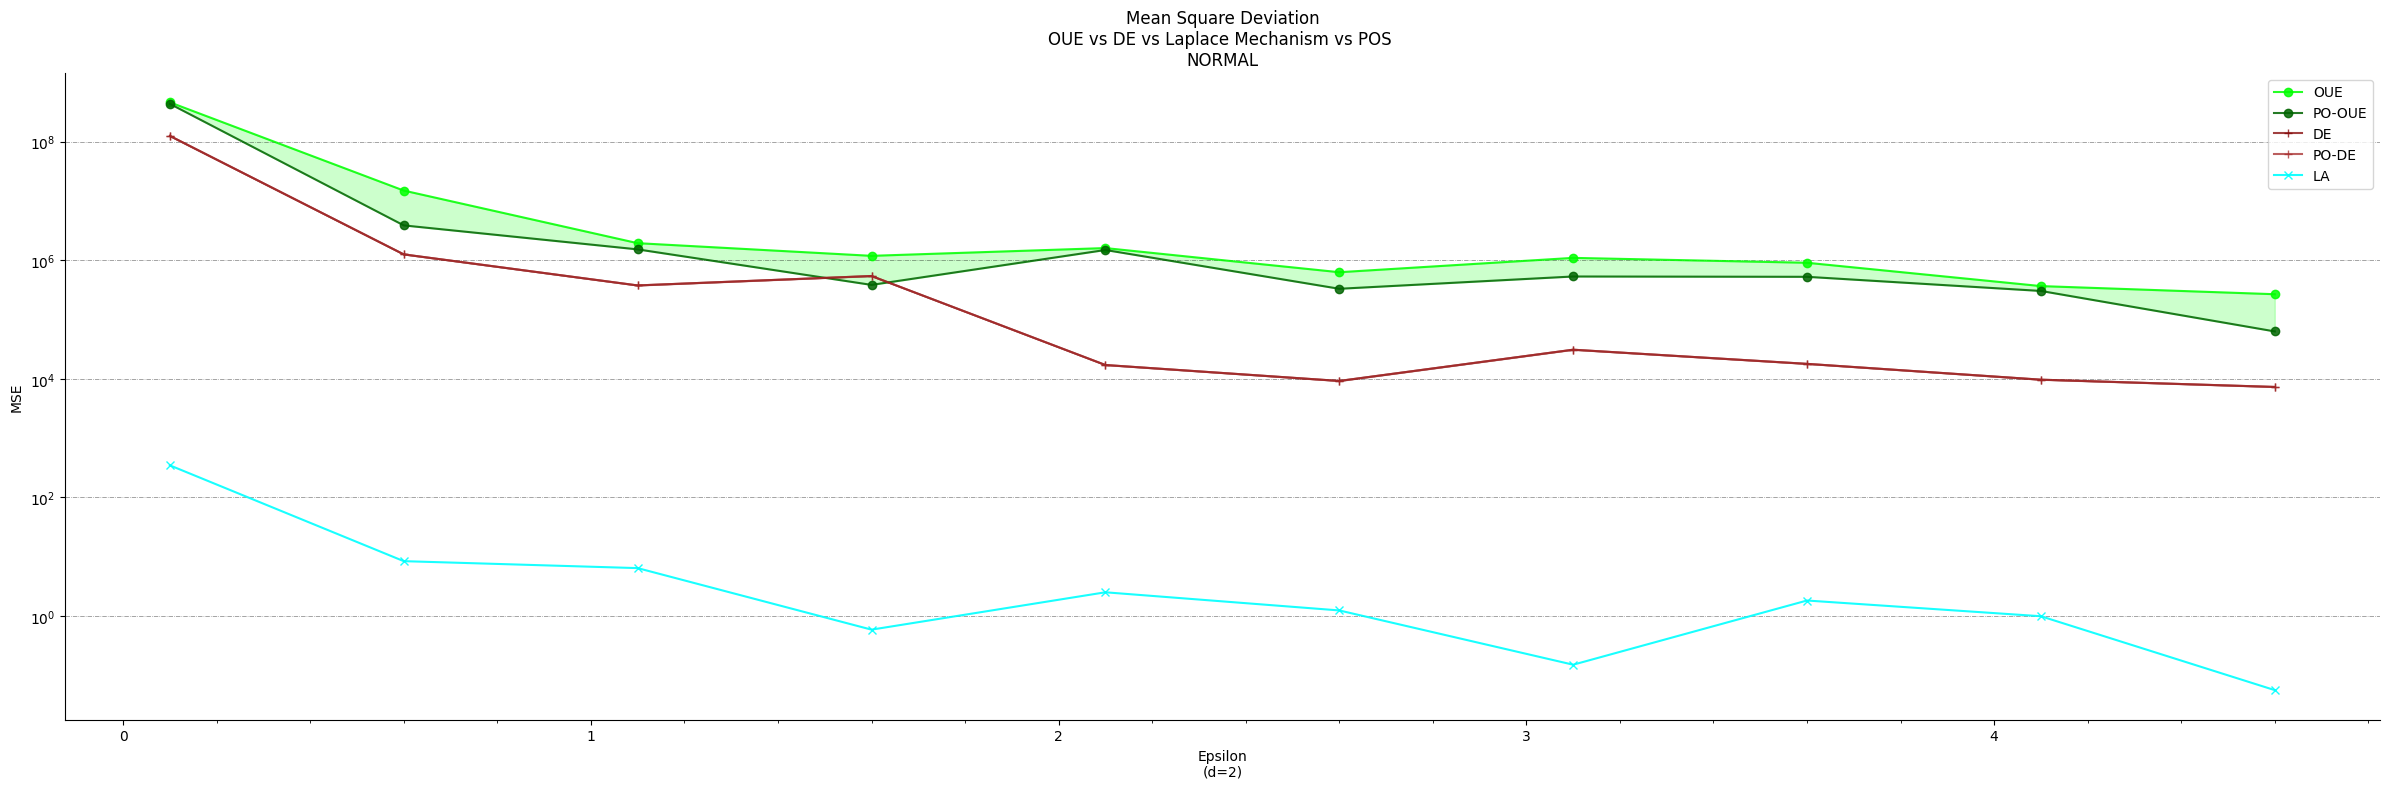

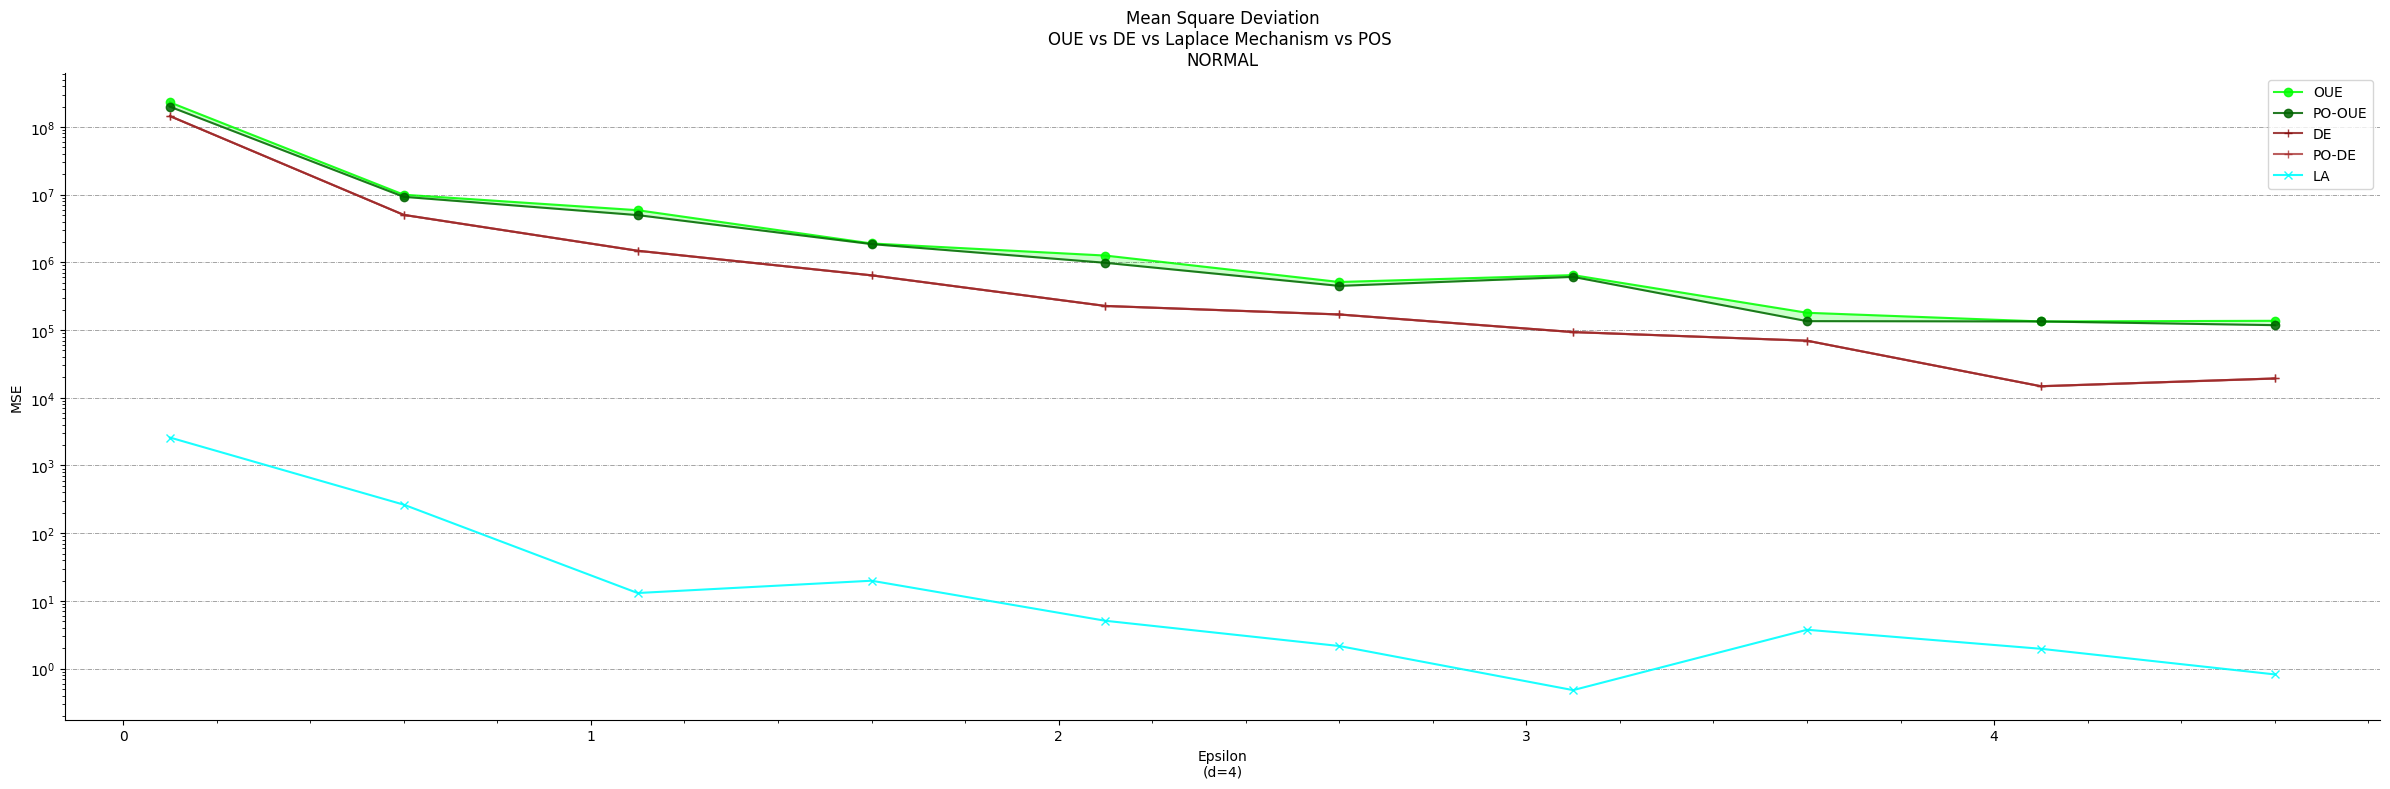

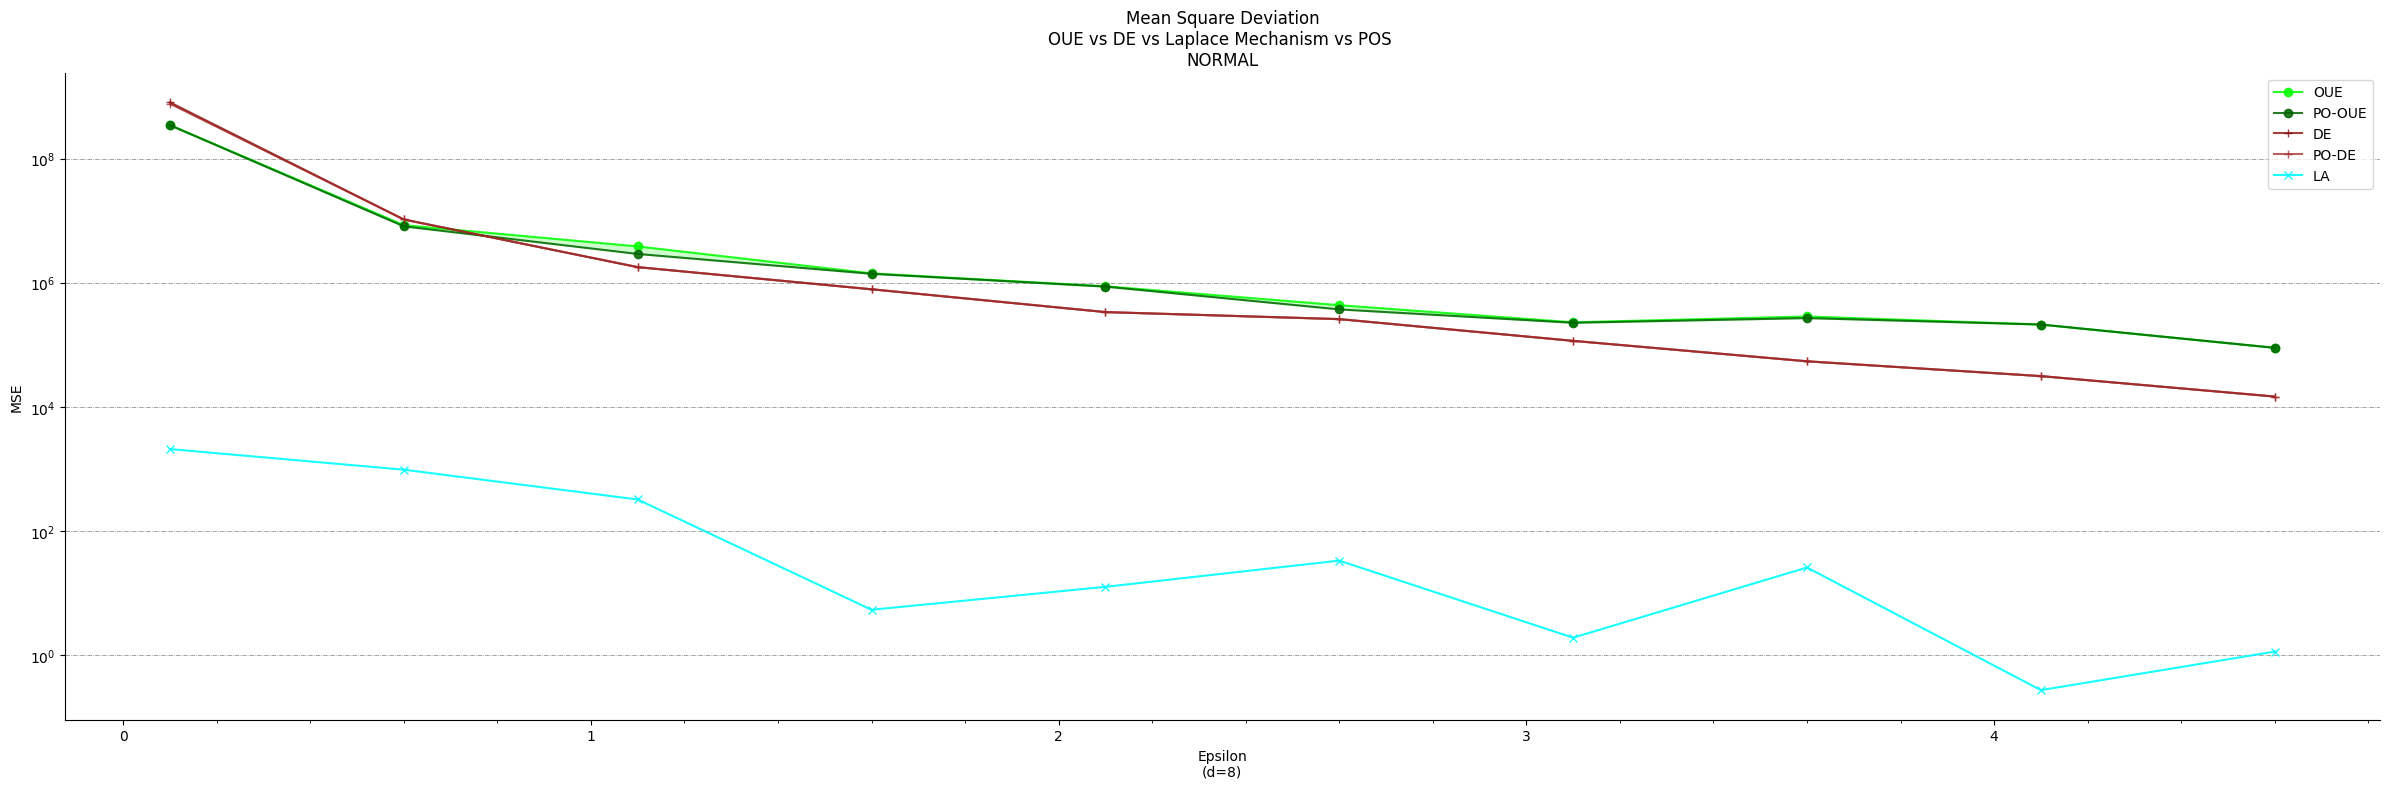

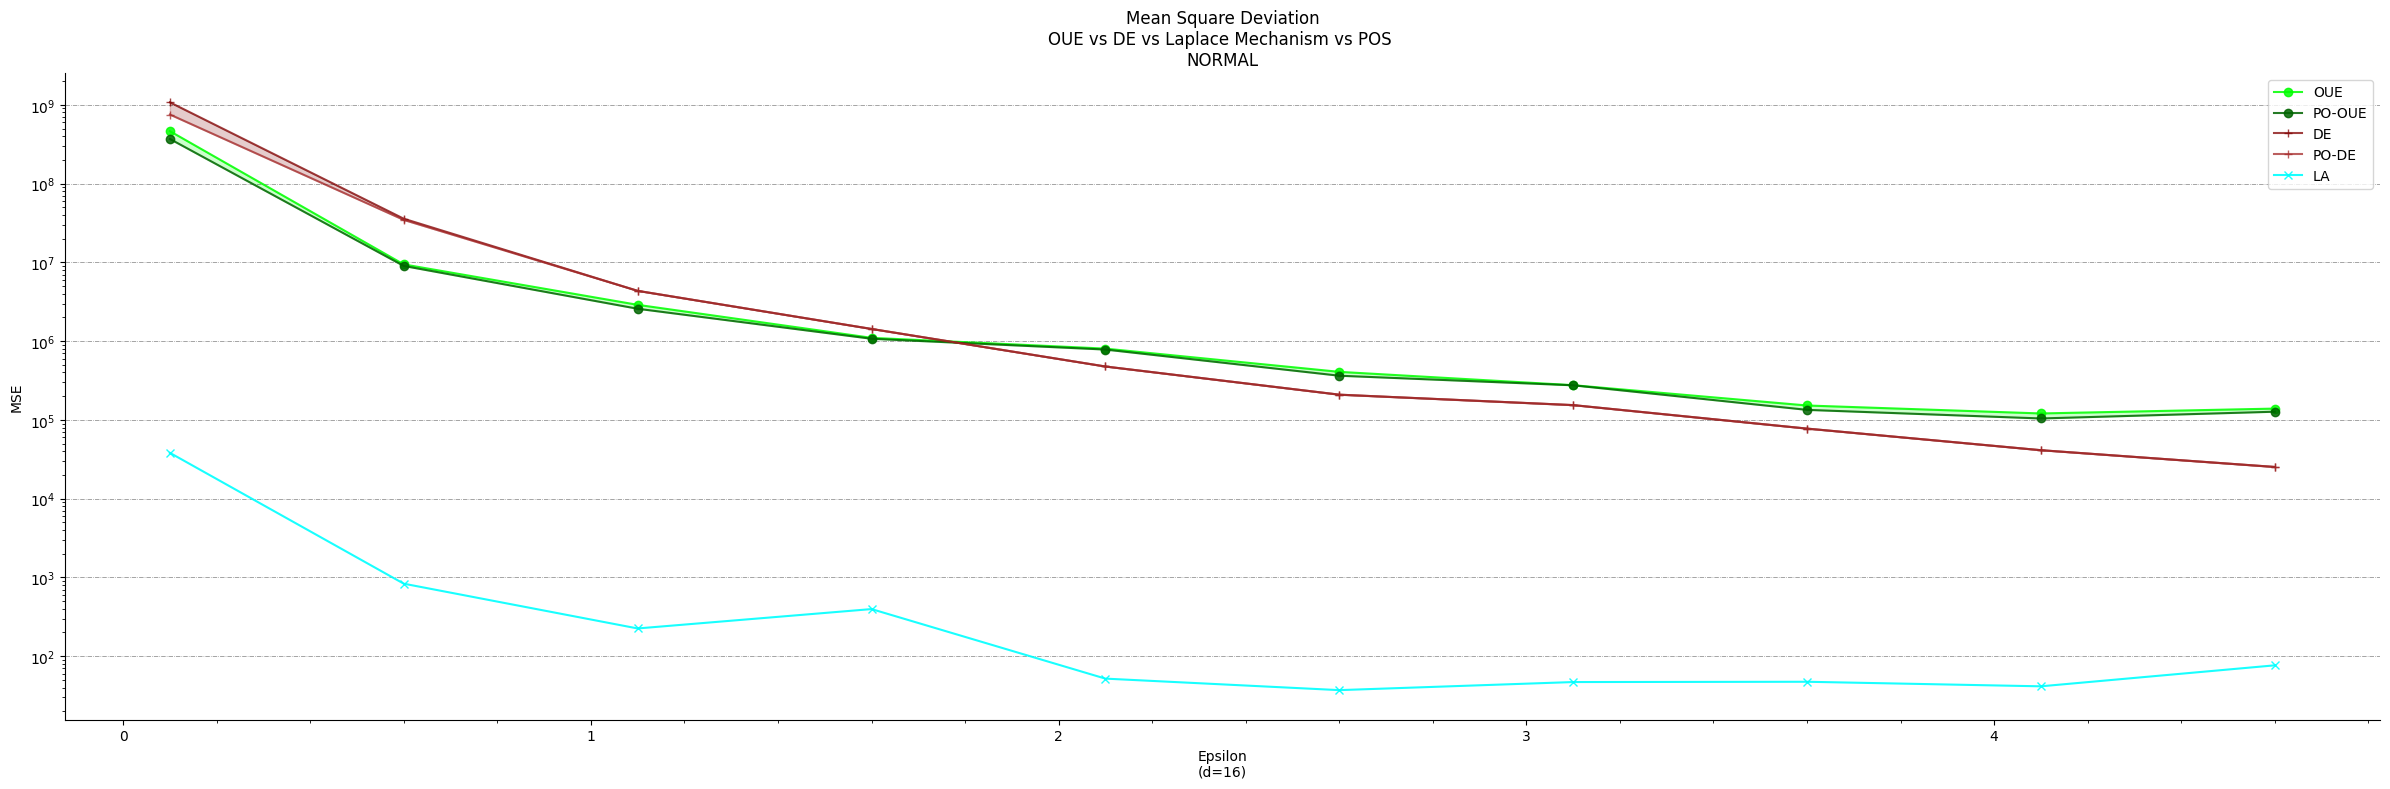

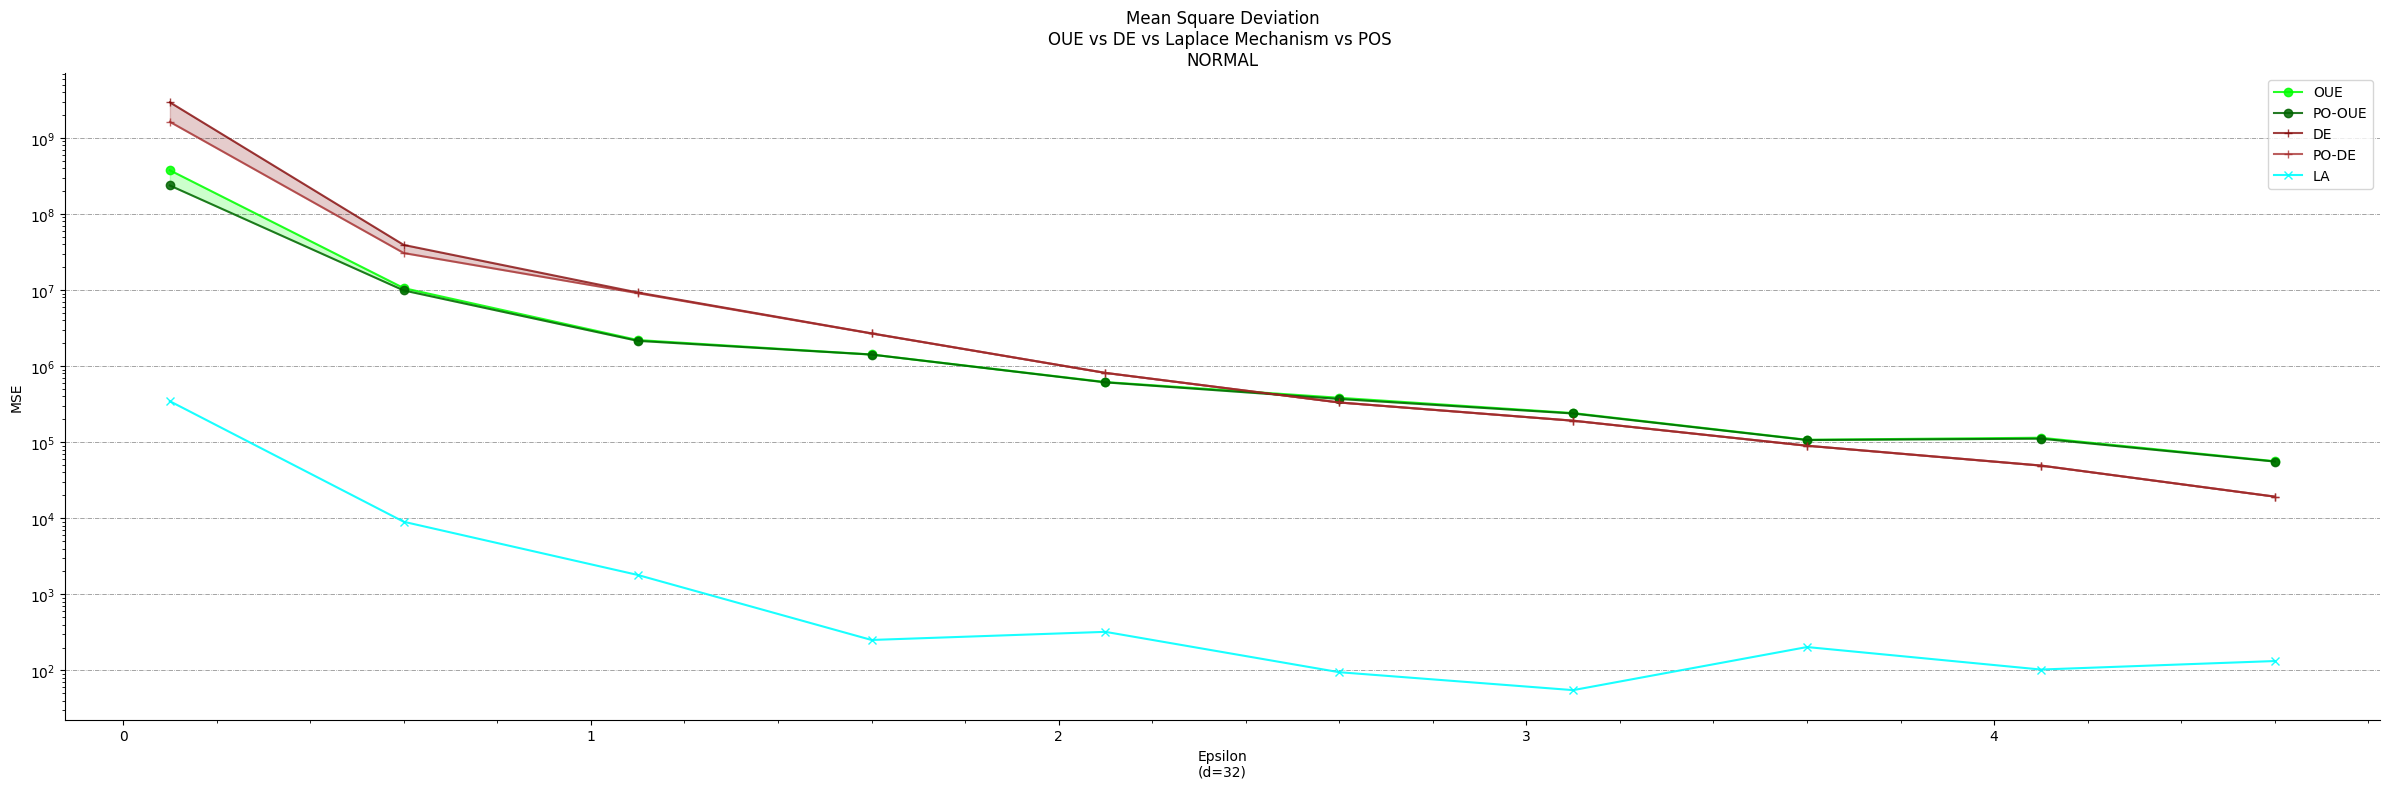

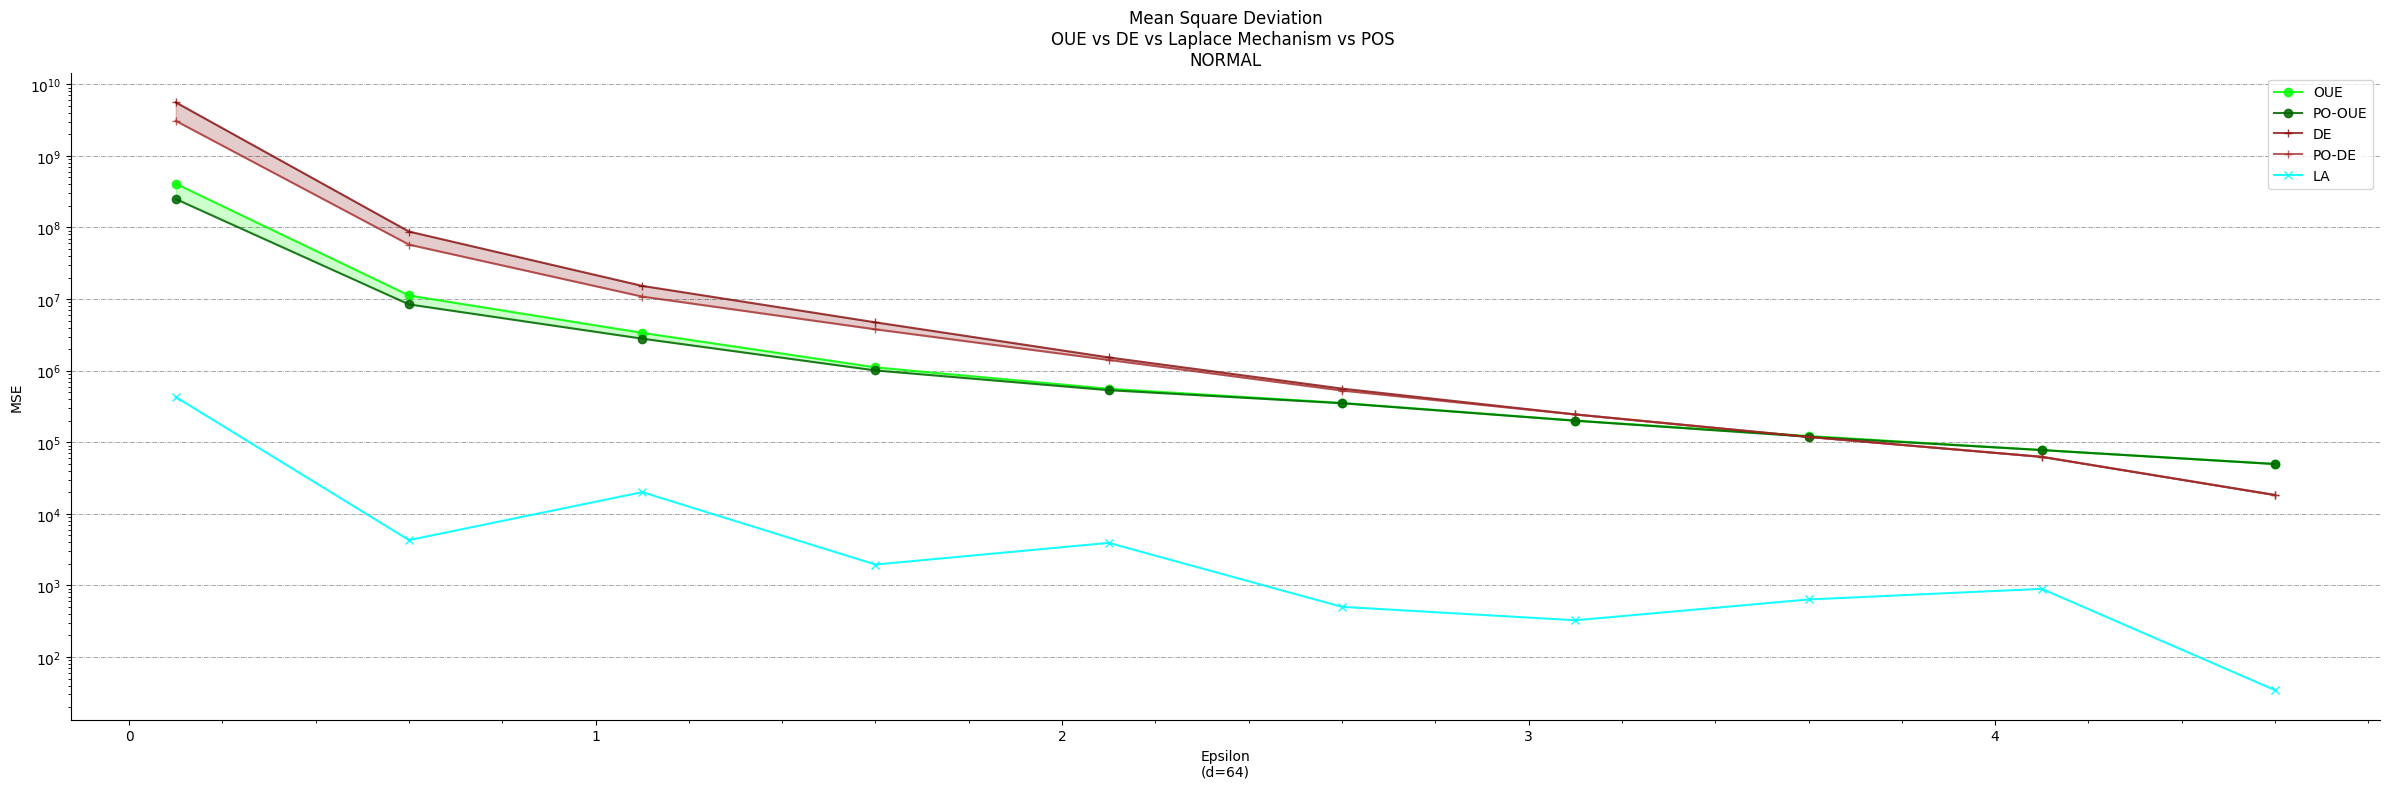

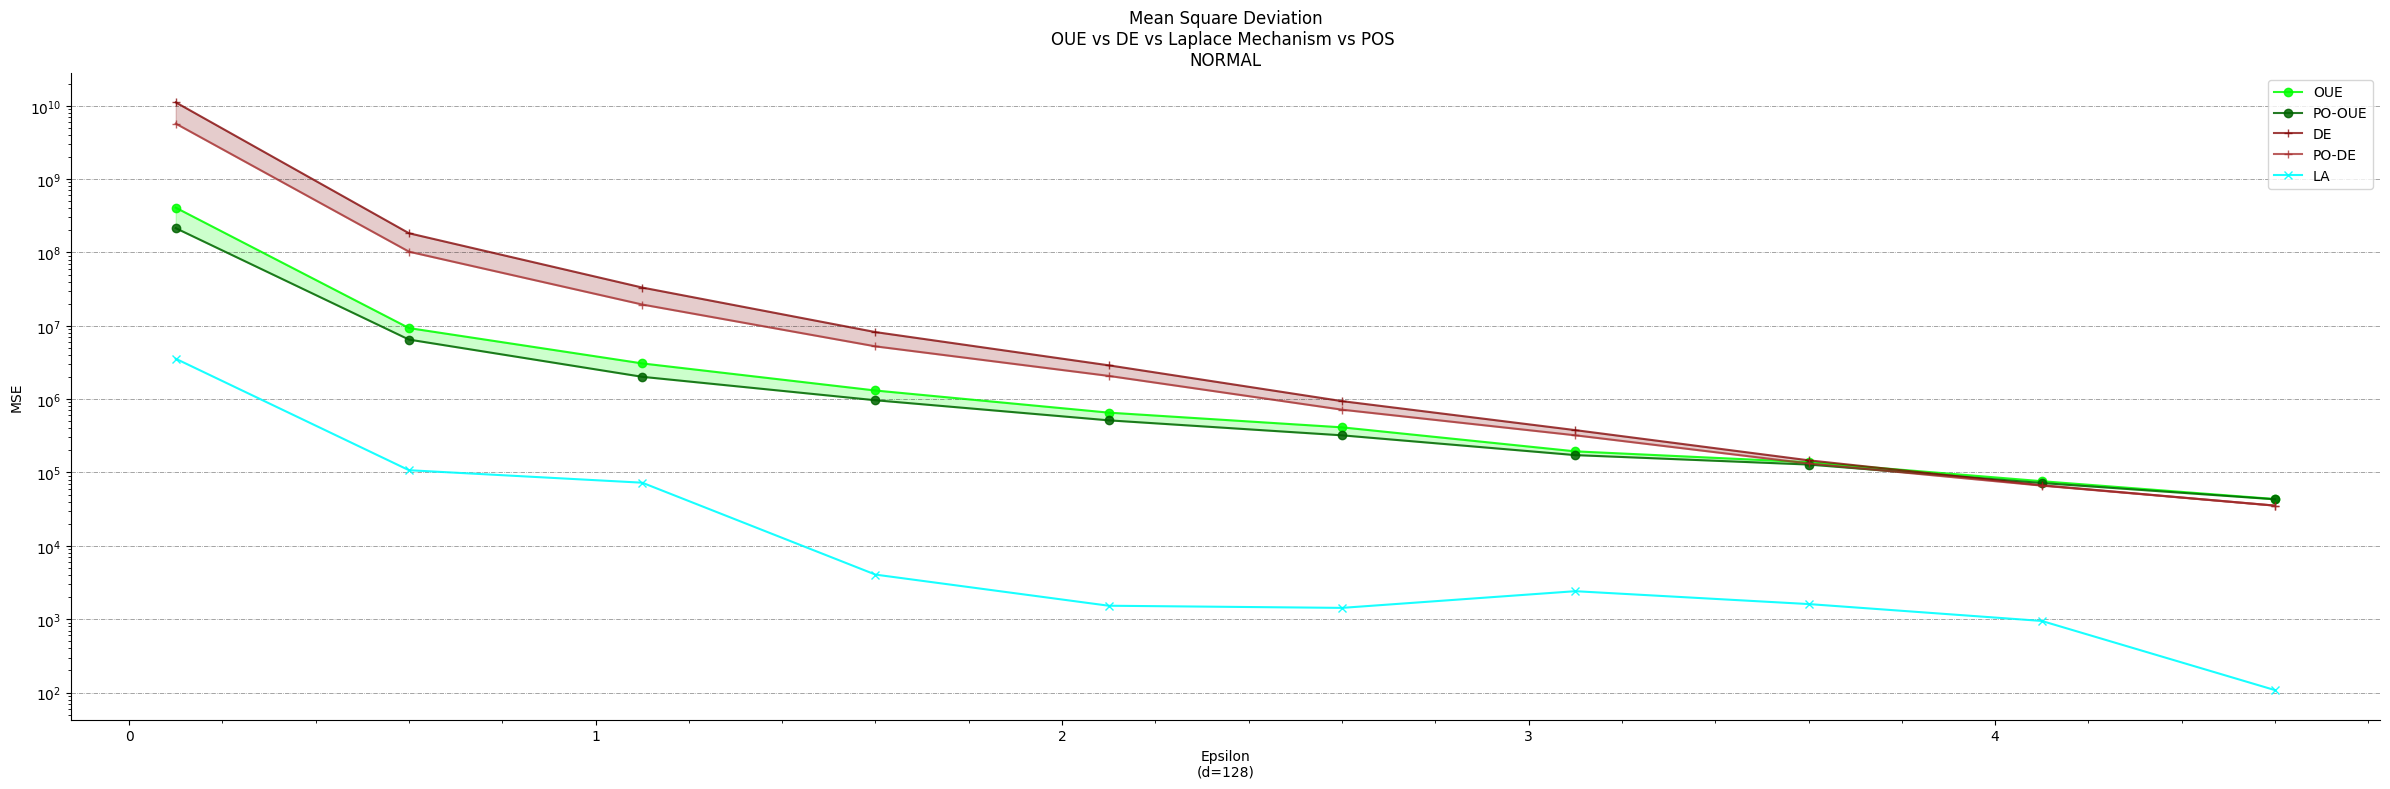

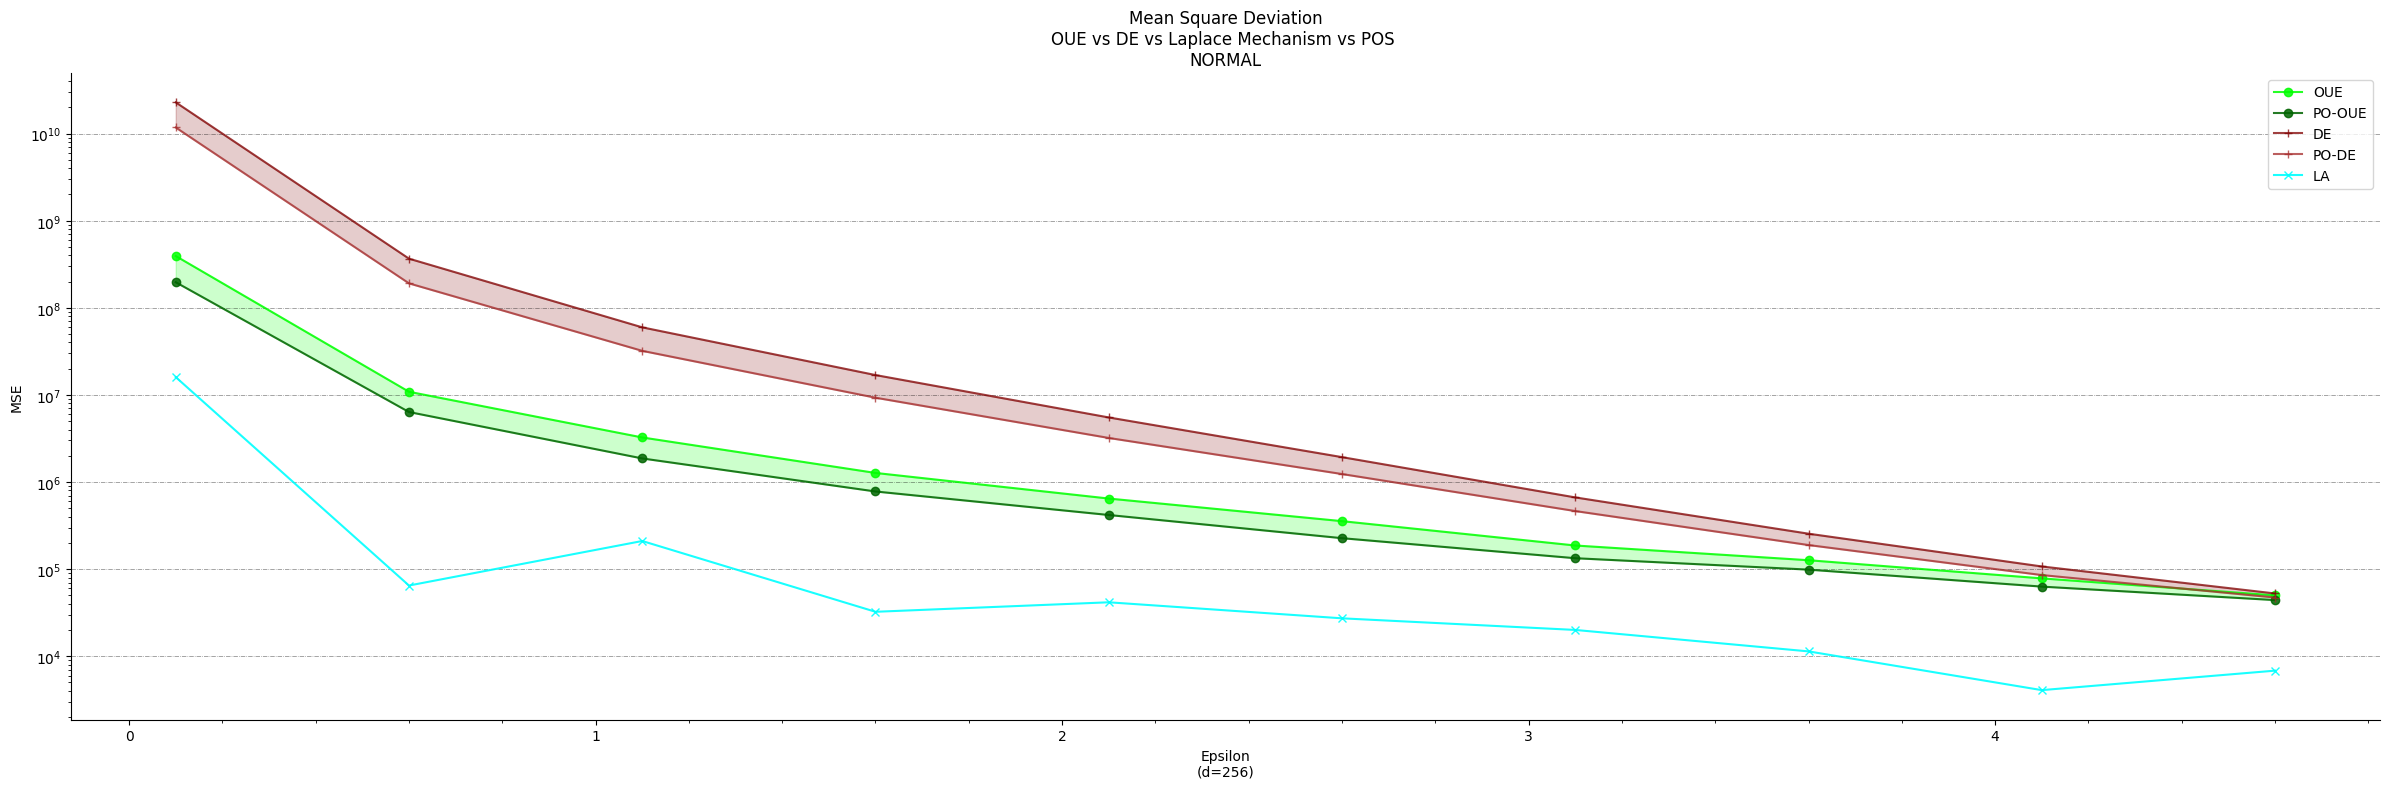

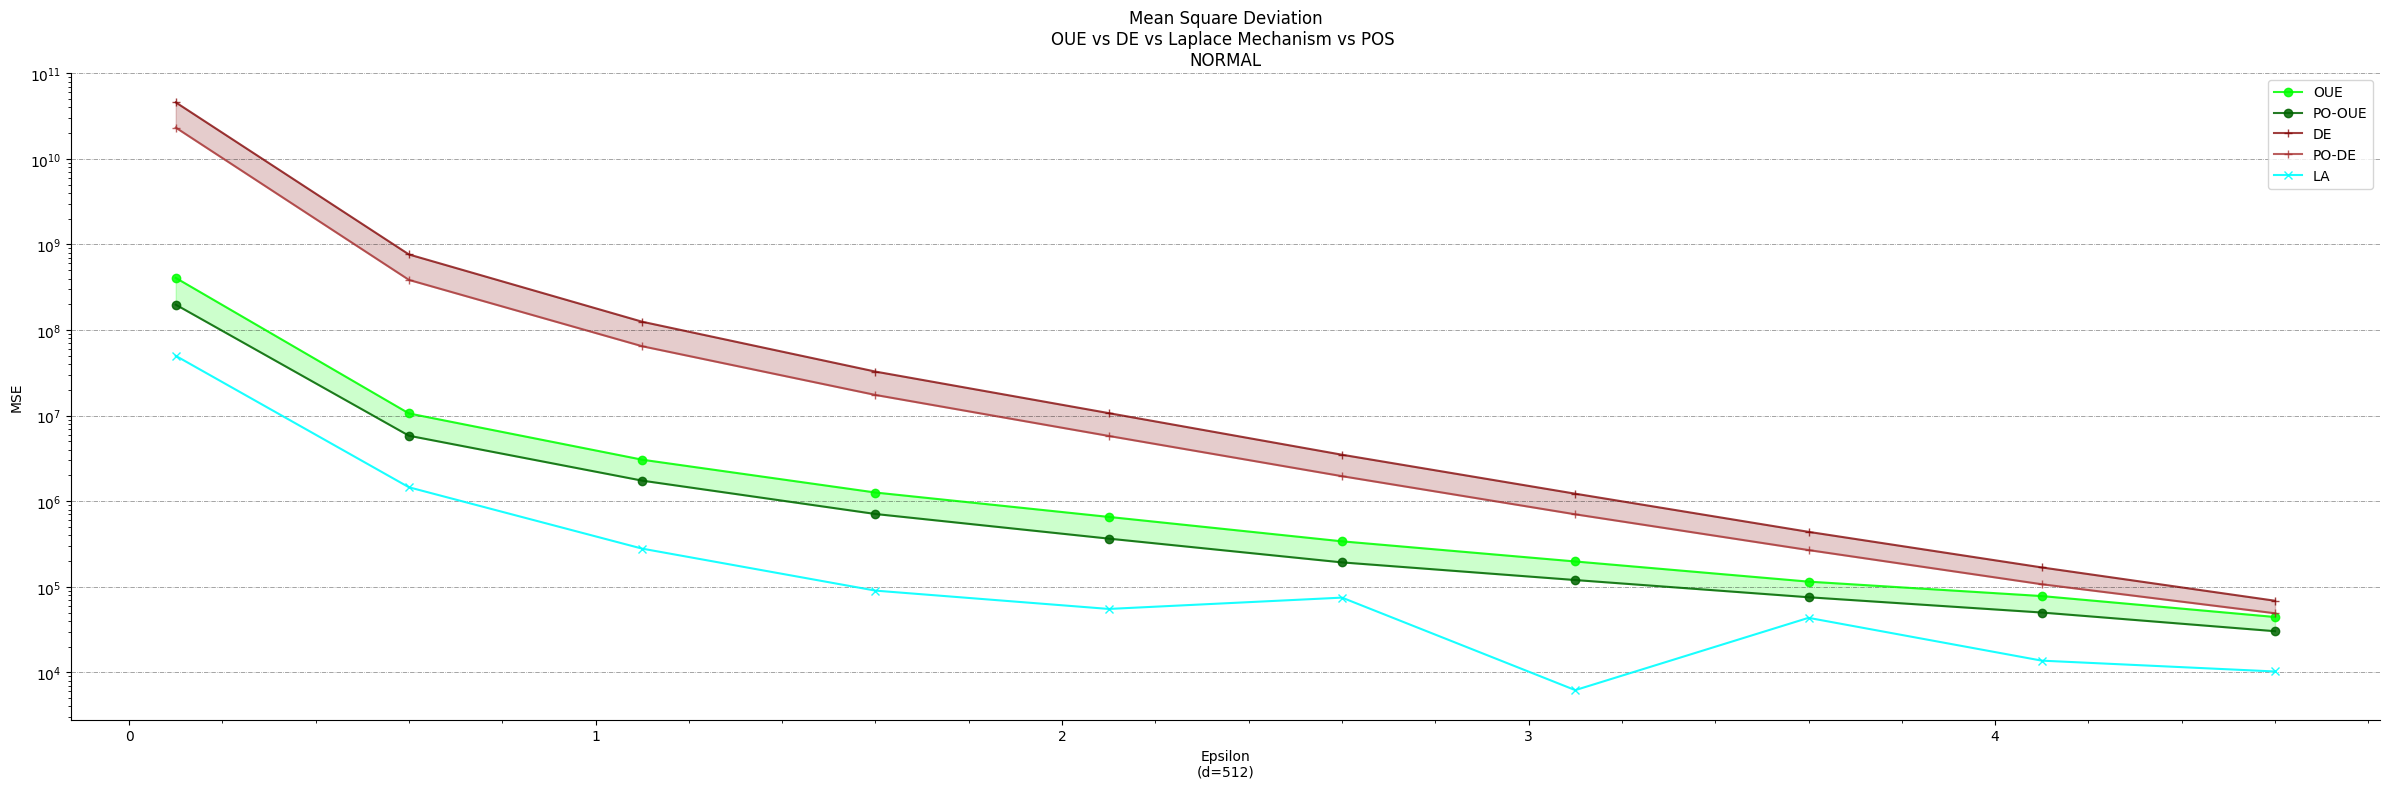

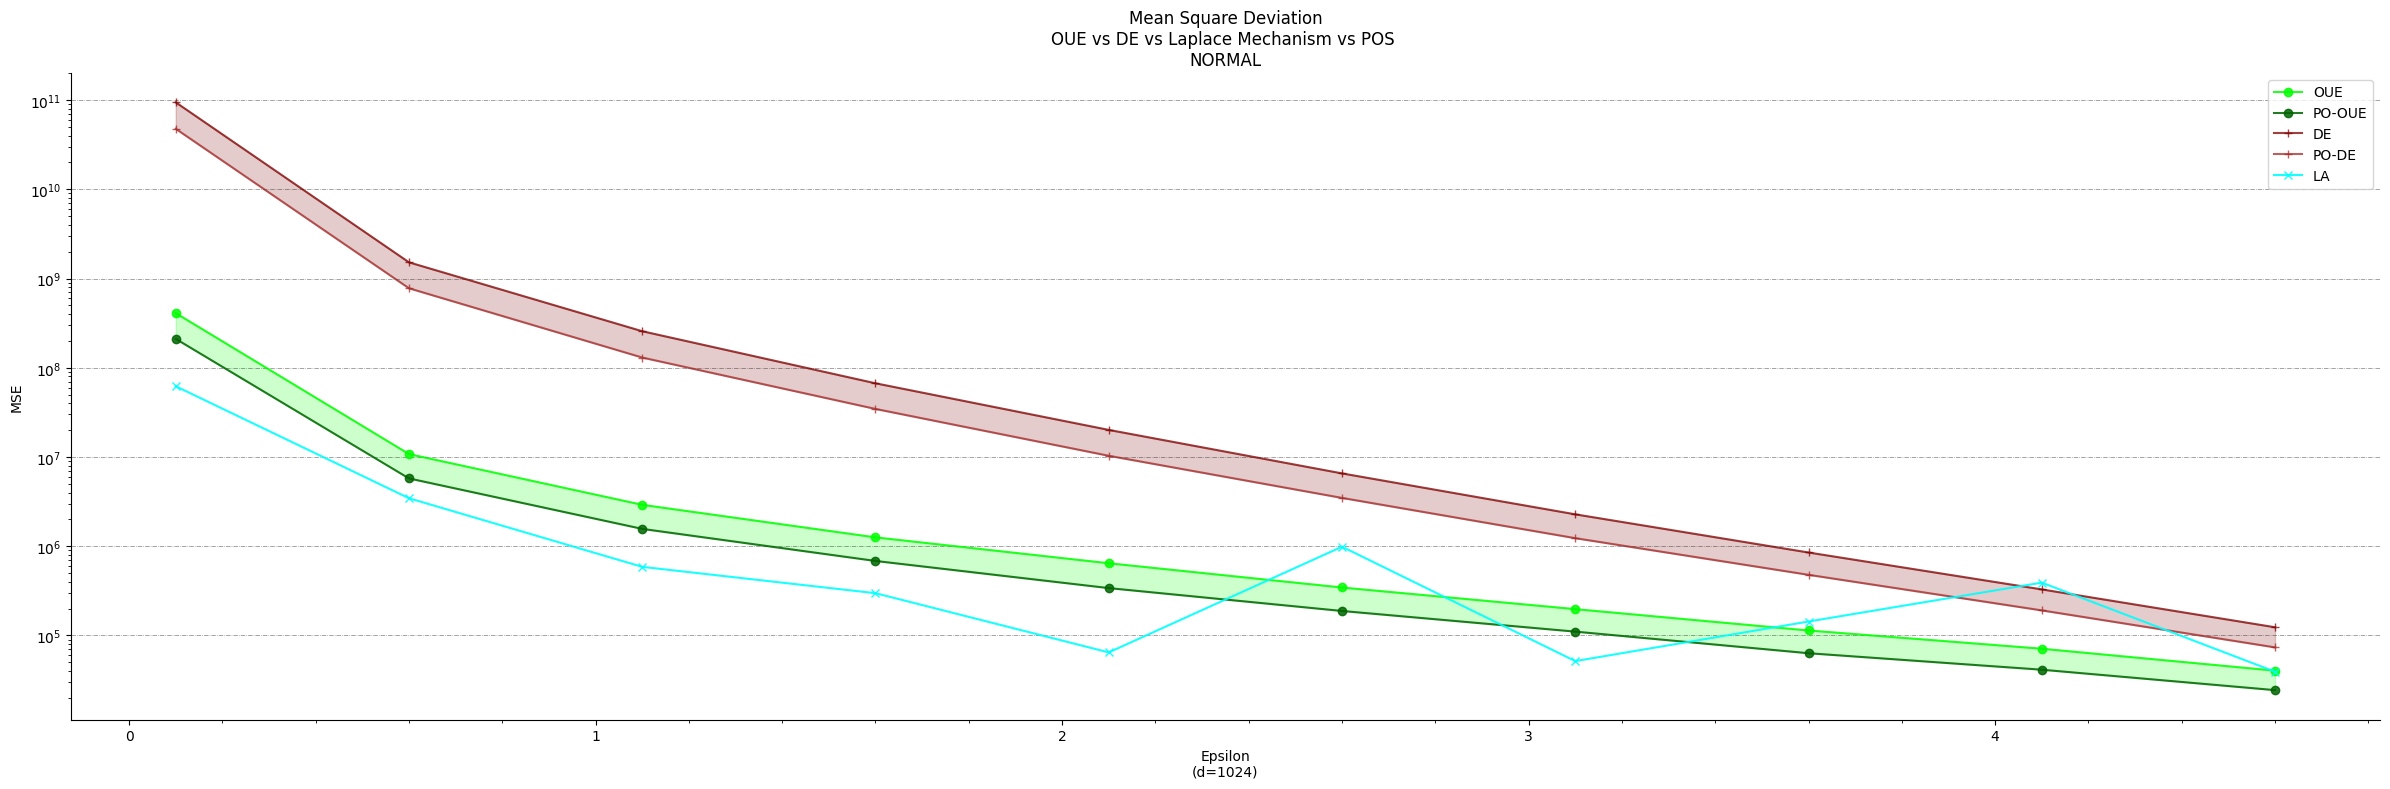

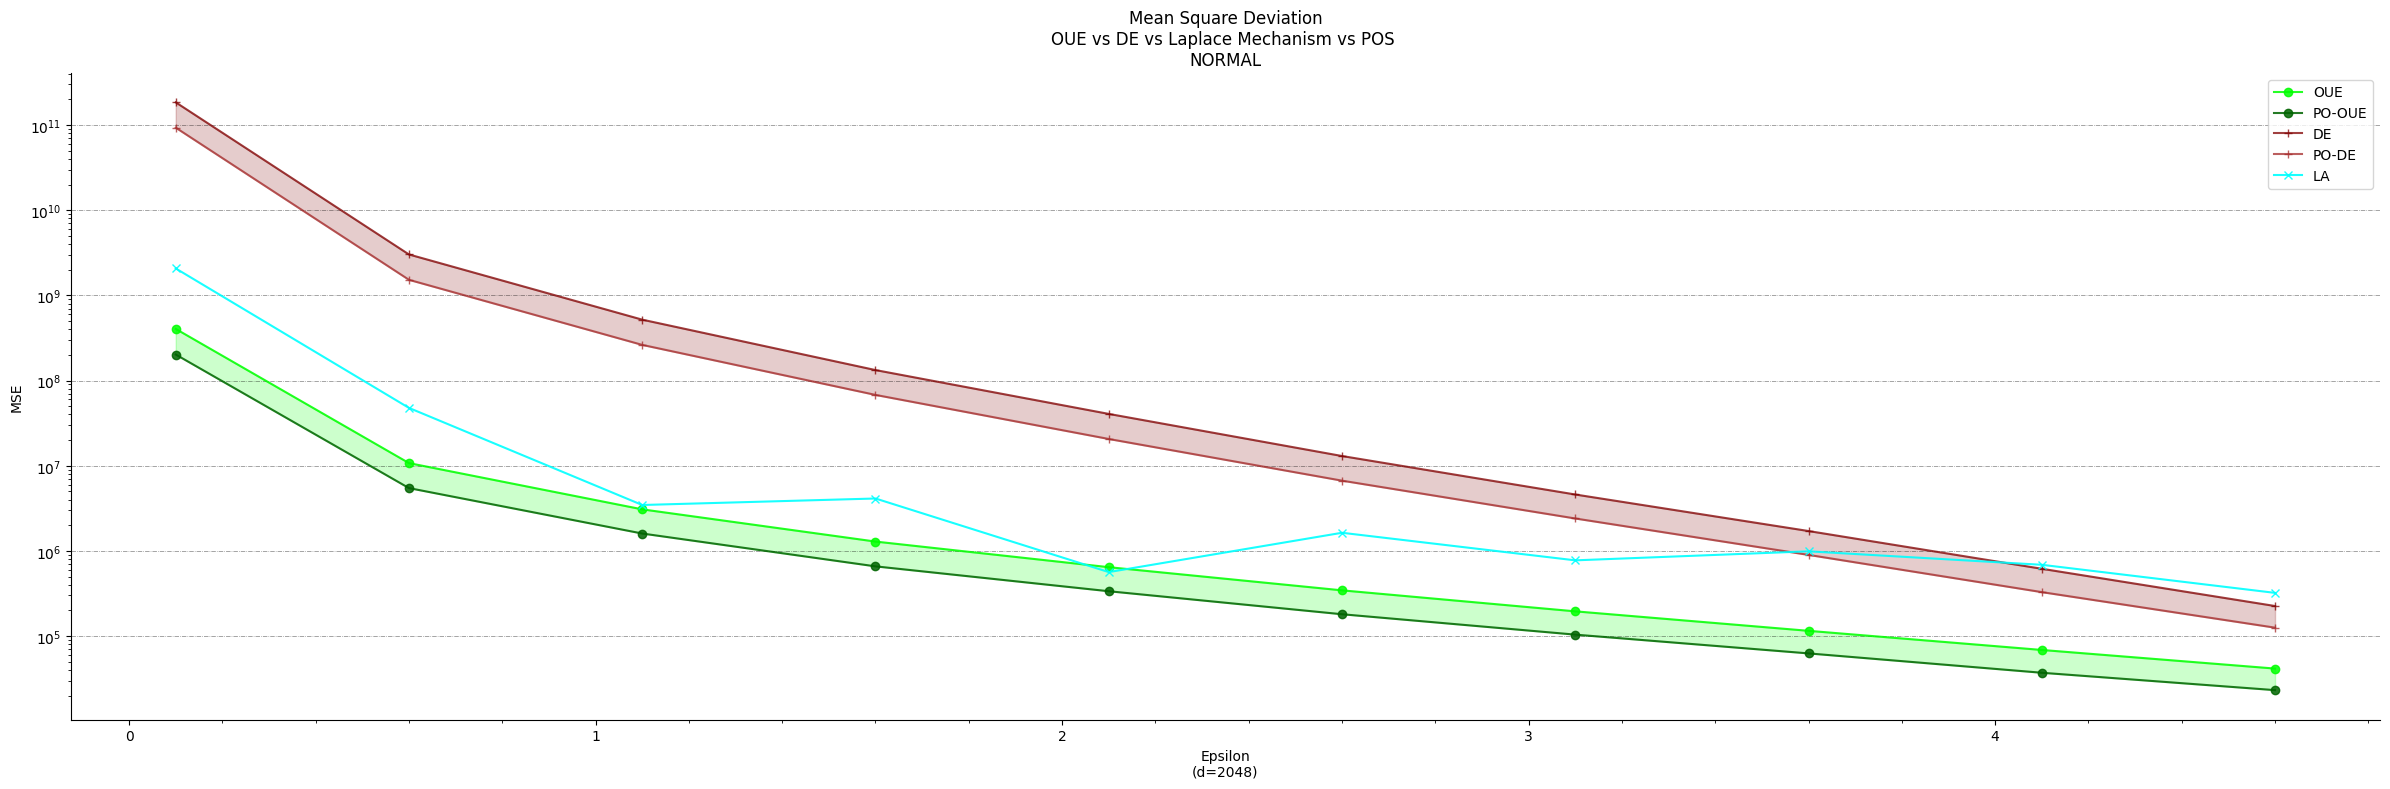

In [75]:
for i in range(1,12):
    d = 2**i

    zipf_args = {
        'd': d,
        'n': 10**6,
        'a': 1.5
    }


    epsilon_avg, mseOUE_avg, mseDE_avg, mseLA_avg, POmseOUE_avg, POmseDE_avg = meid(zipf, 4, **zipf_args)
    
    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_avg, POmseOUE_avg, marker='o', color='darkgreen', alpha=0.85, label='PO-OUE')
    plt.fill_between(epsilon_avg, mseOUE_avg, POmseOUE_avg, color='lime', alpha=0.2)
    
    plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
    plt.plot(epsilon_avg, POmseDE_avg, marker='+', color='brown', alpha=0.75, label='PO-DE')
    plt.fill_between(epsilon_avg, mseDE_avg, POmseDE_avg, color='maroon', alpha=0.2)
    
    plt.plot(epsilon_avg, mseLA_avg, marker='x', color='cyan', alpha=0.9, label='LA')
    
    plt.title('Mean Square Deviation\nOUE vs DE vs Laplace Mechanism vs POS \nNORMAL')
    plt.xlabel(f'Epsilon\n(d={d})')
    plt.ylabel('MSE')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()


## the stuff 2

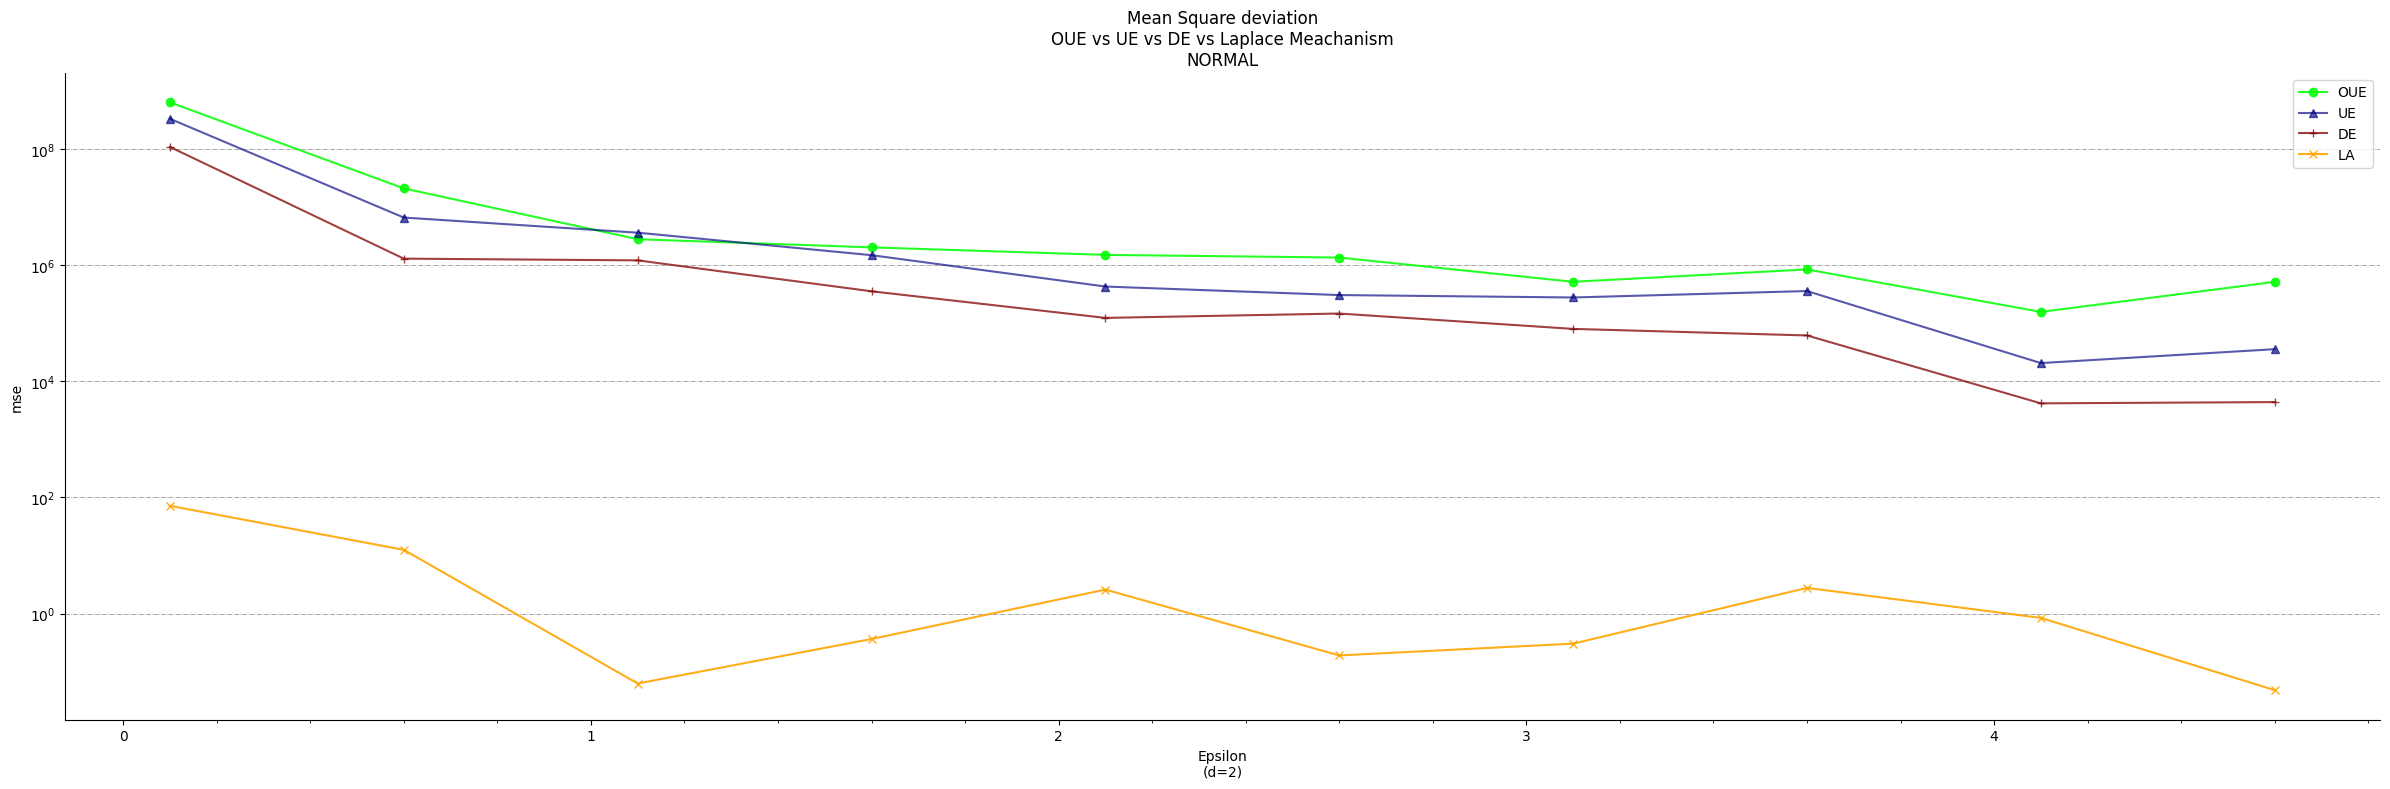

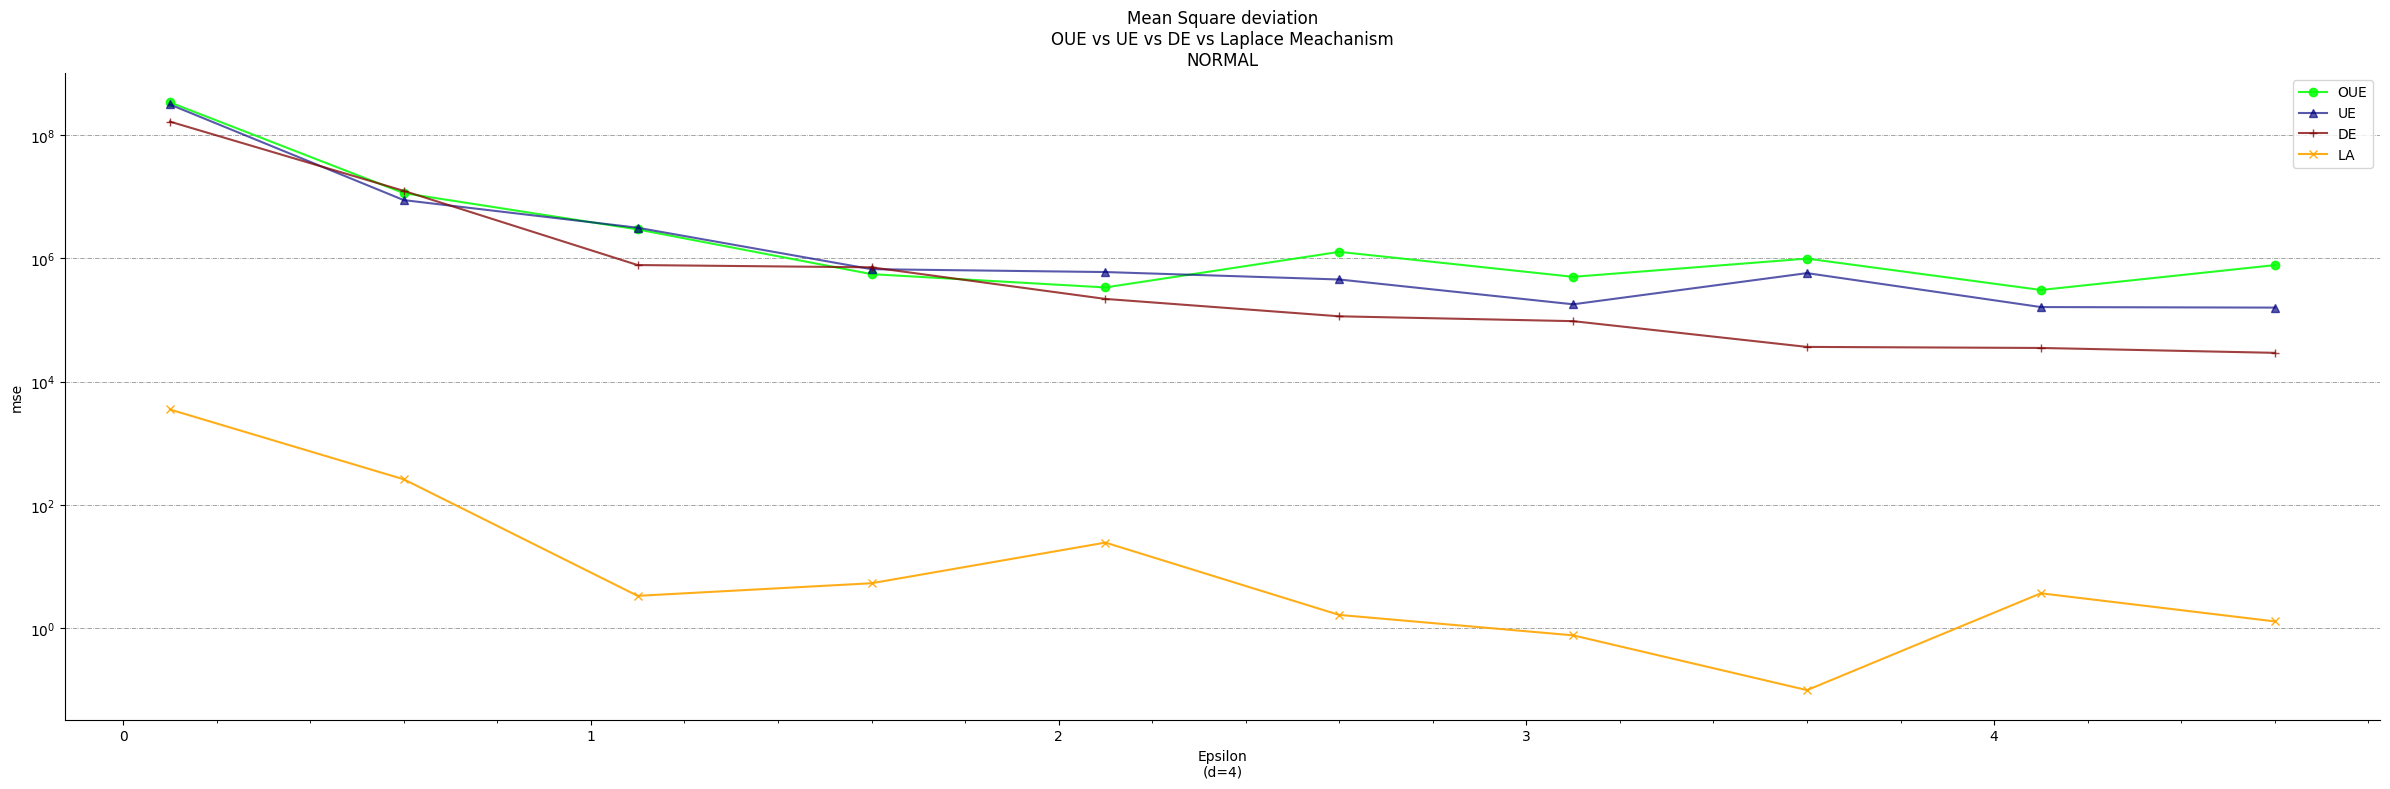

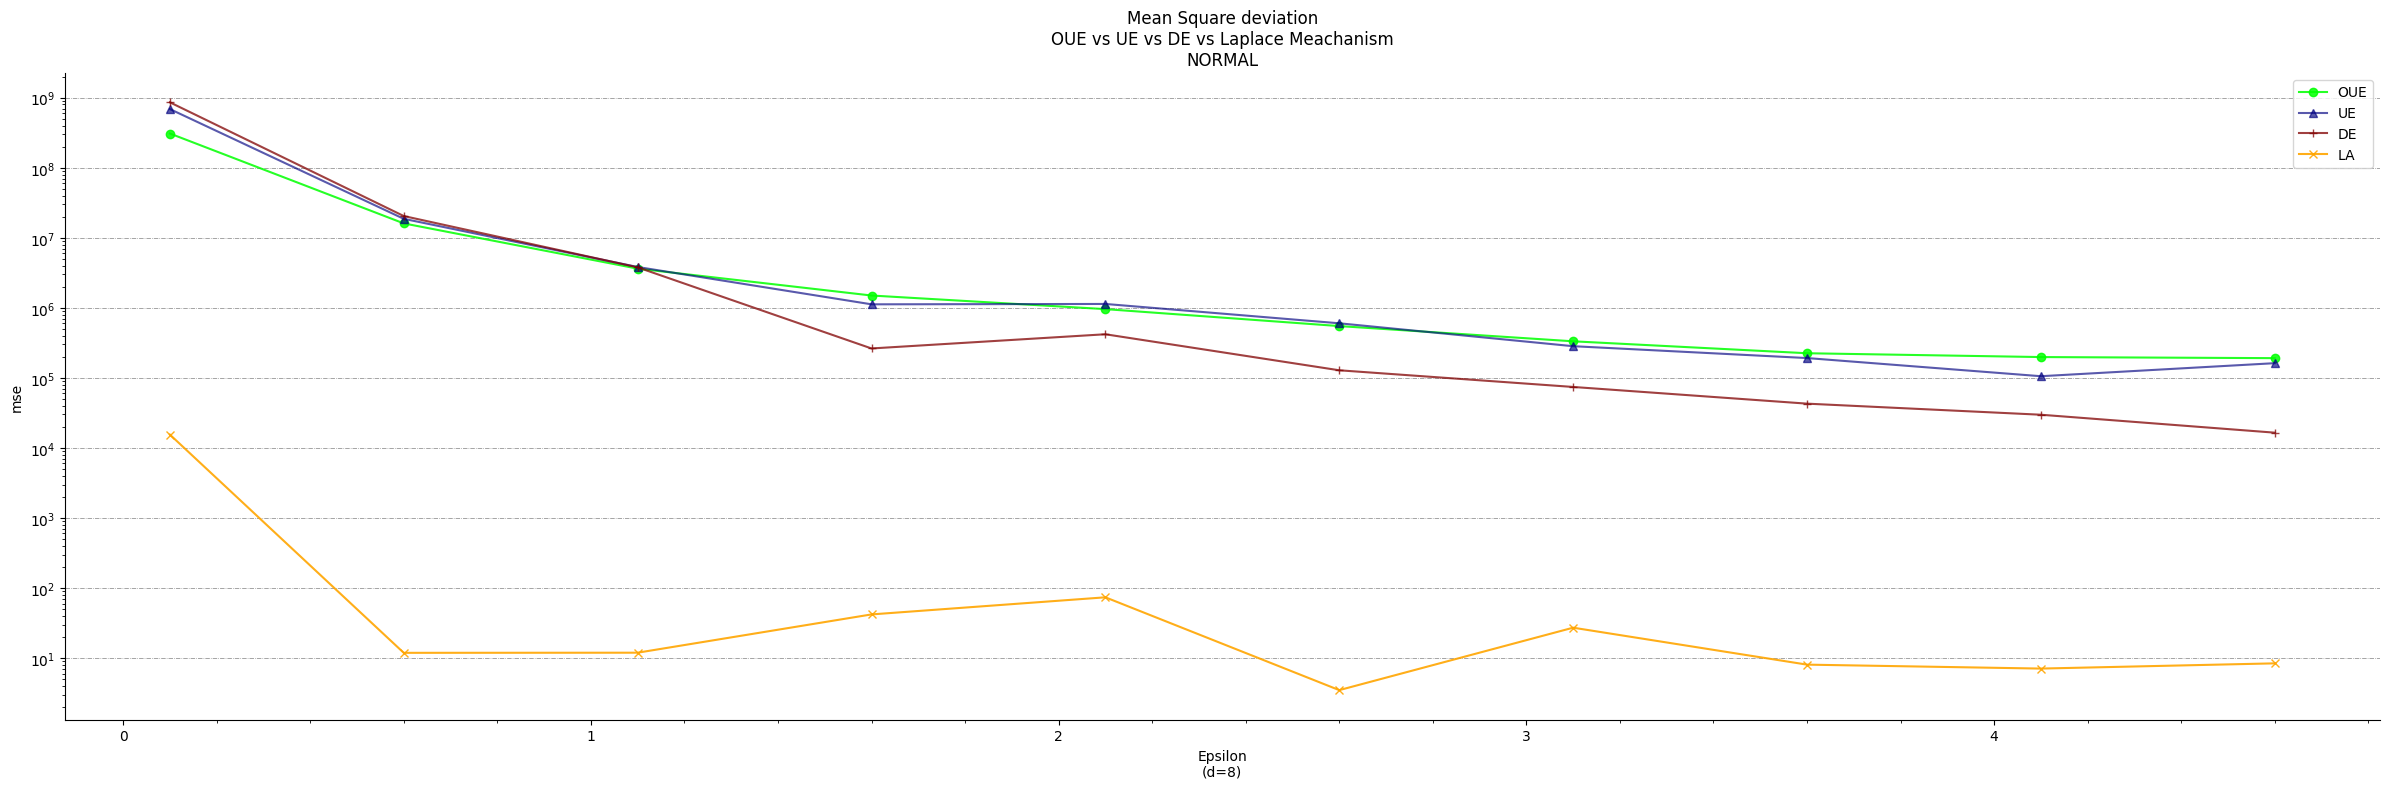

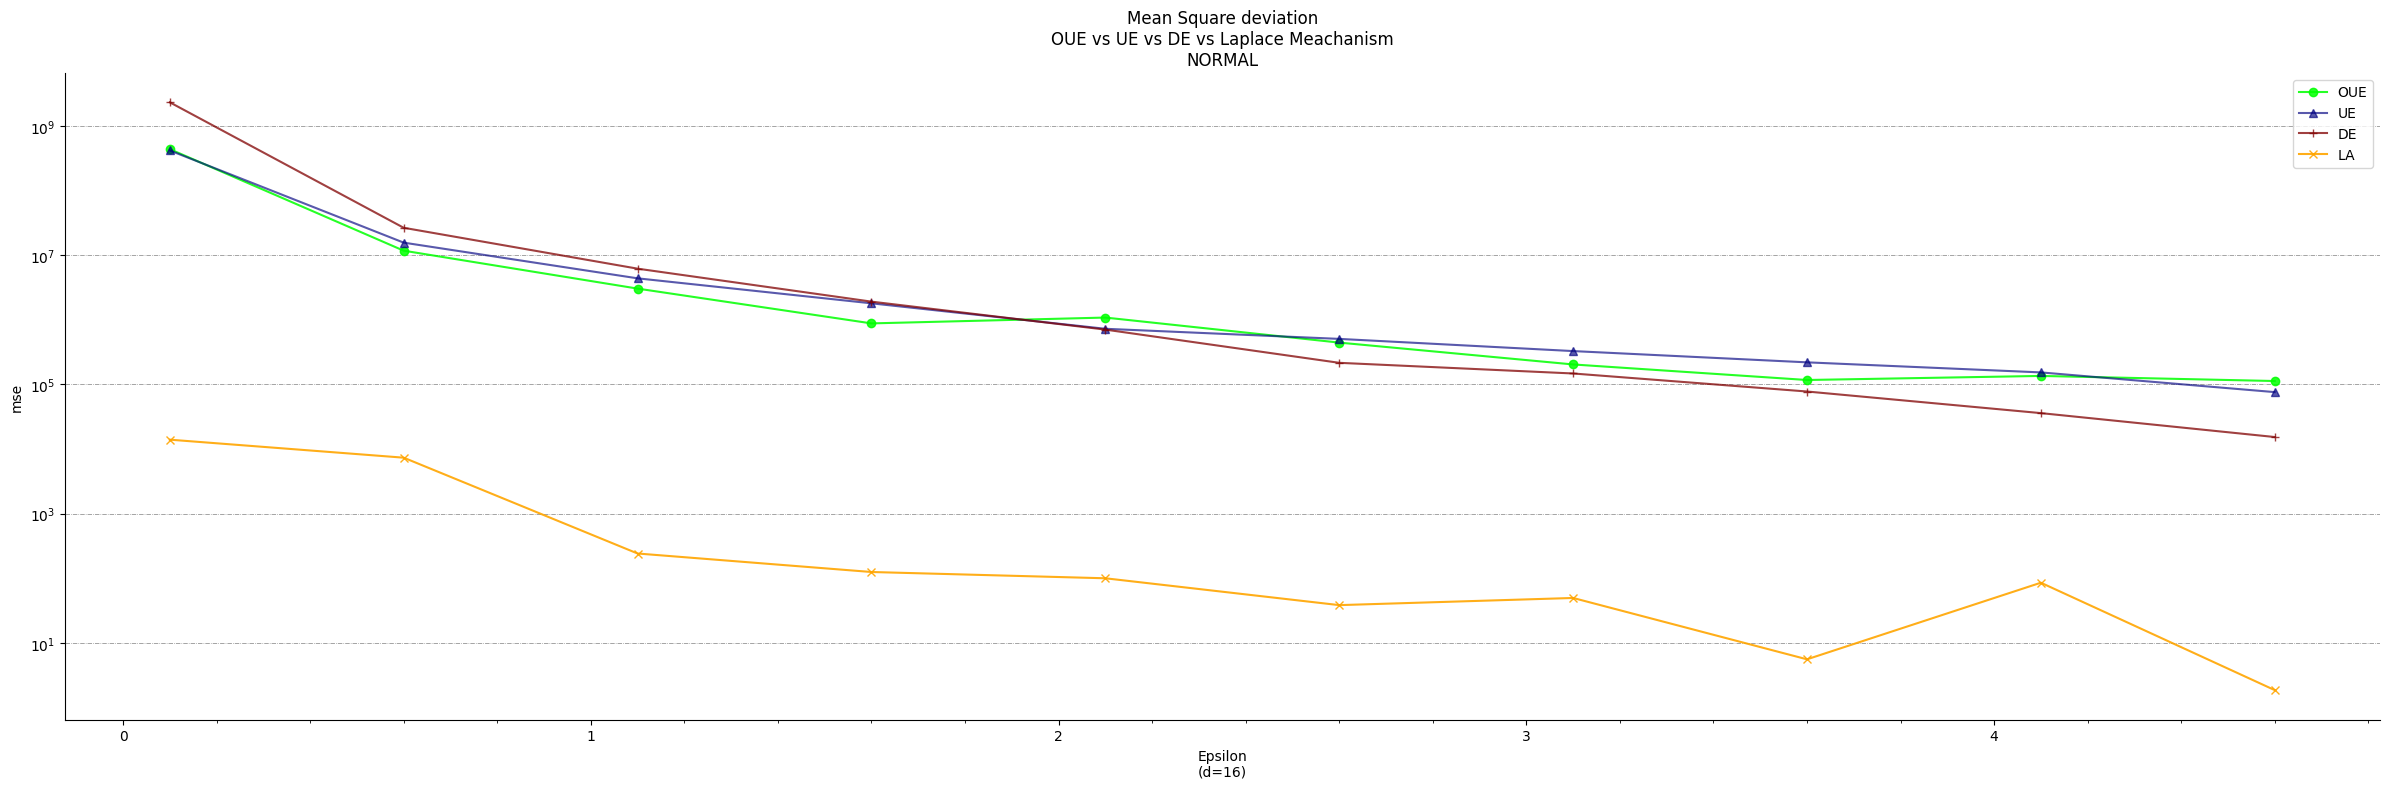

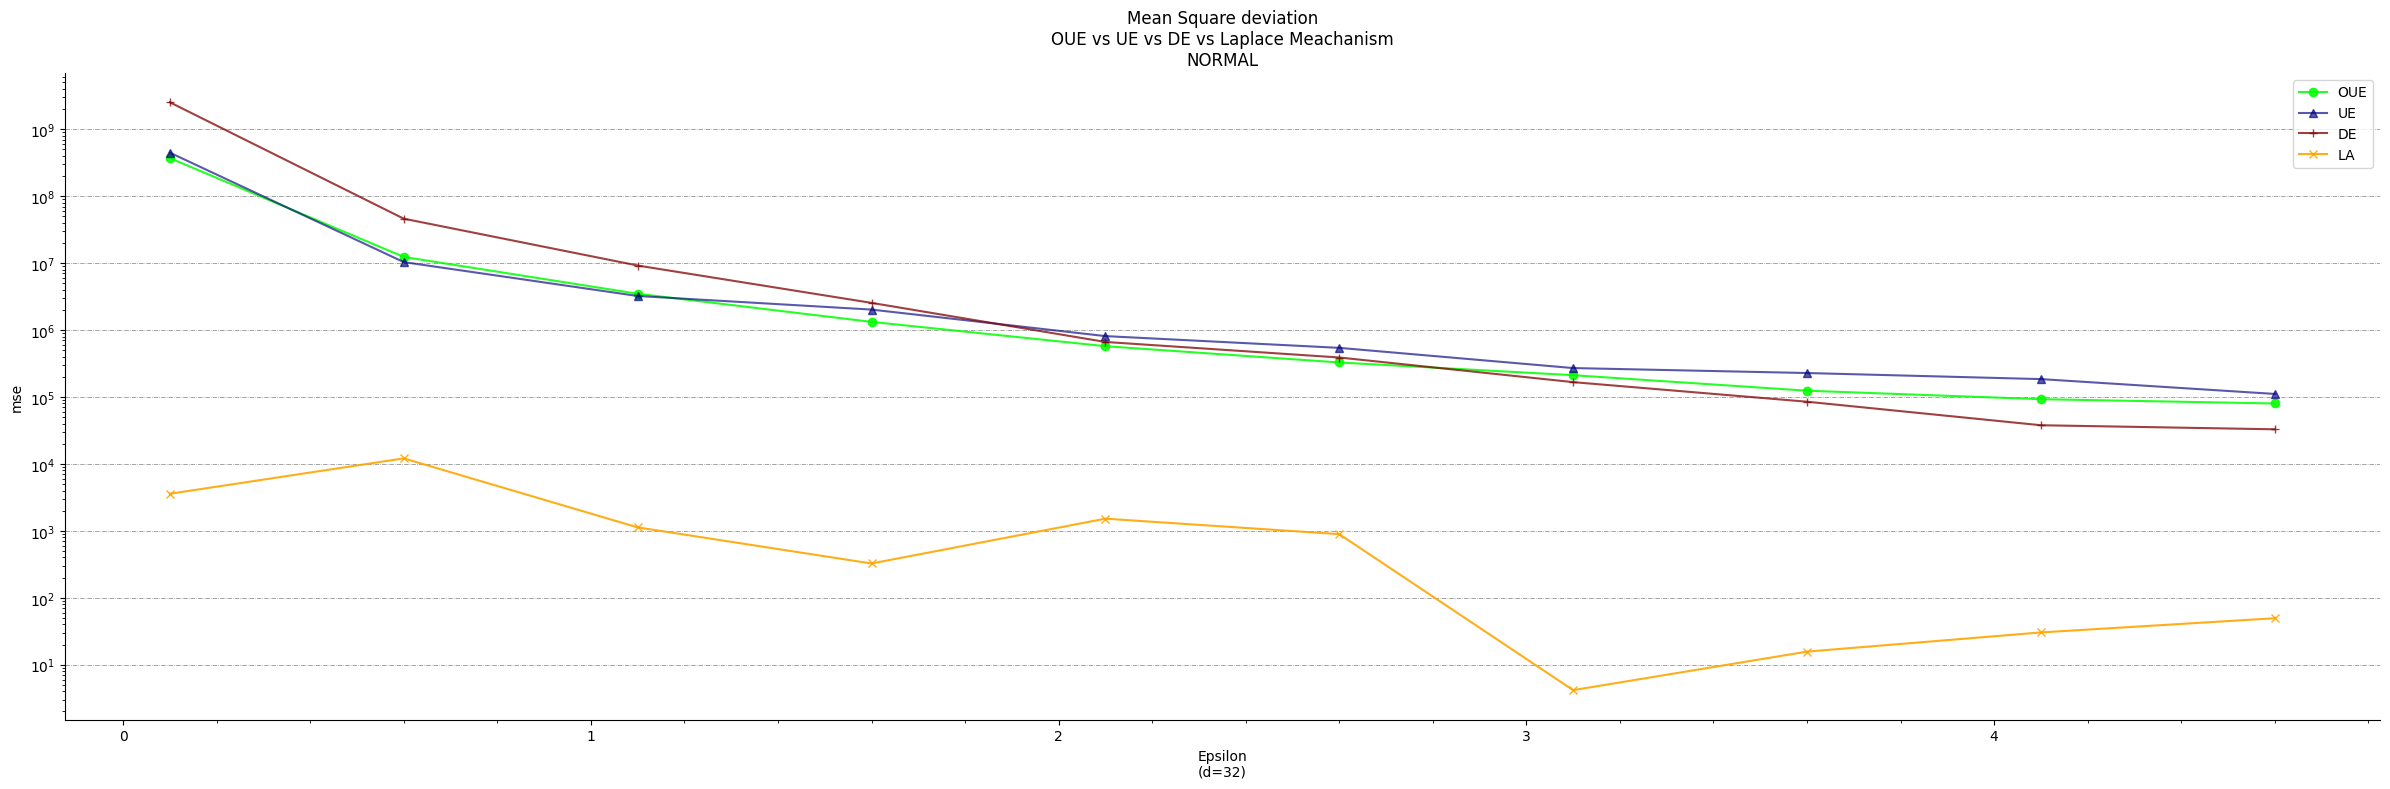

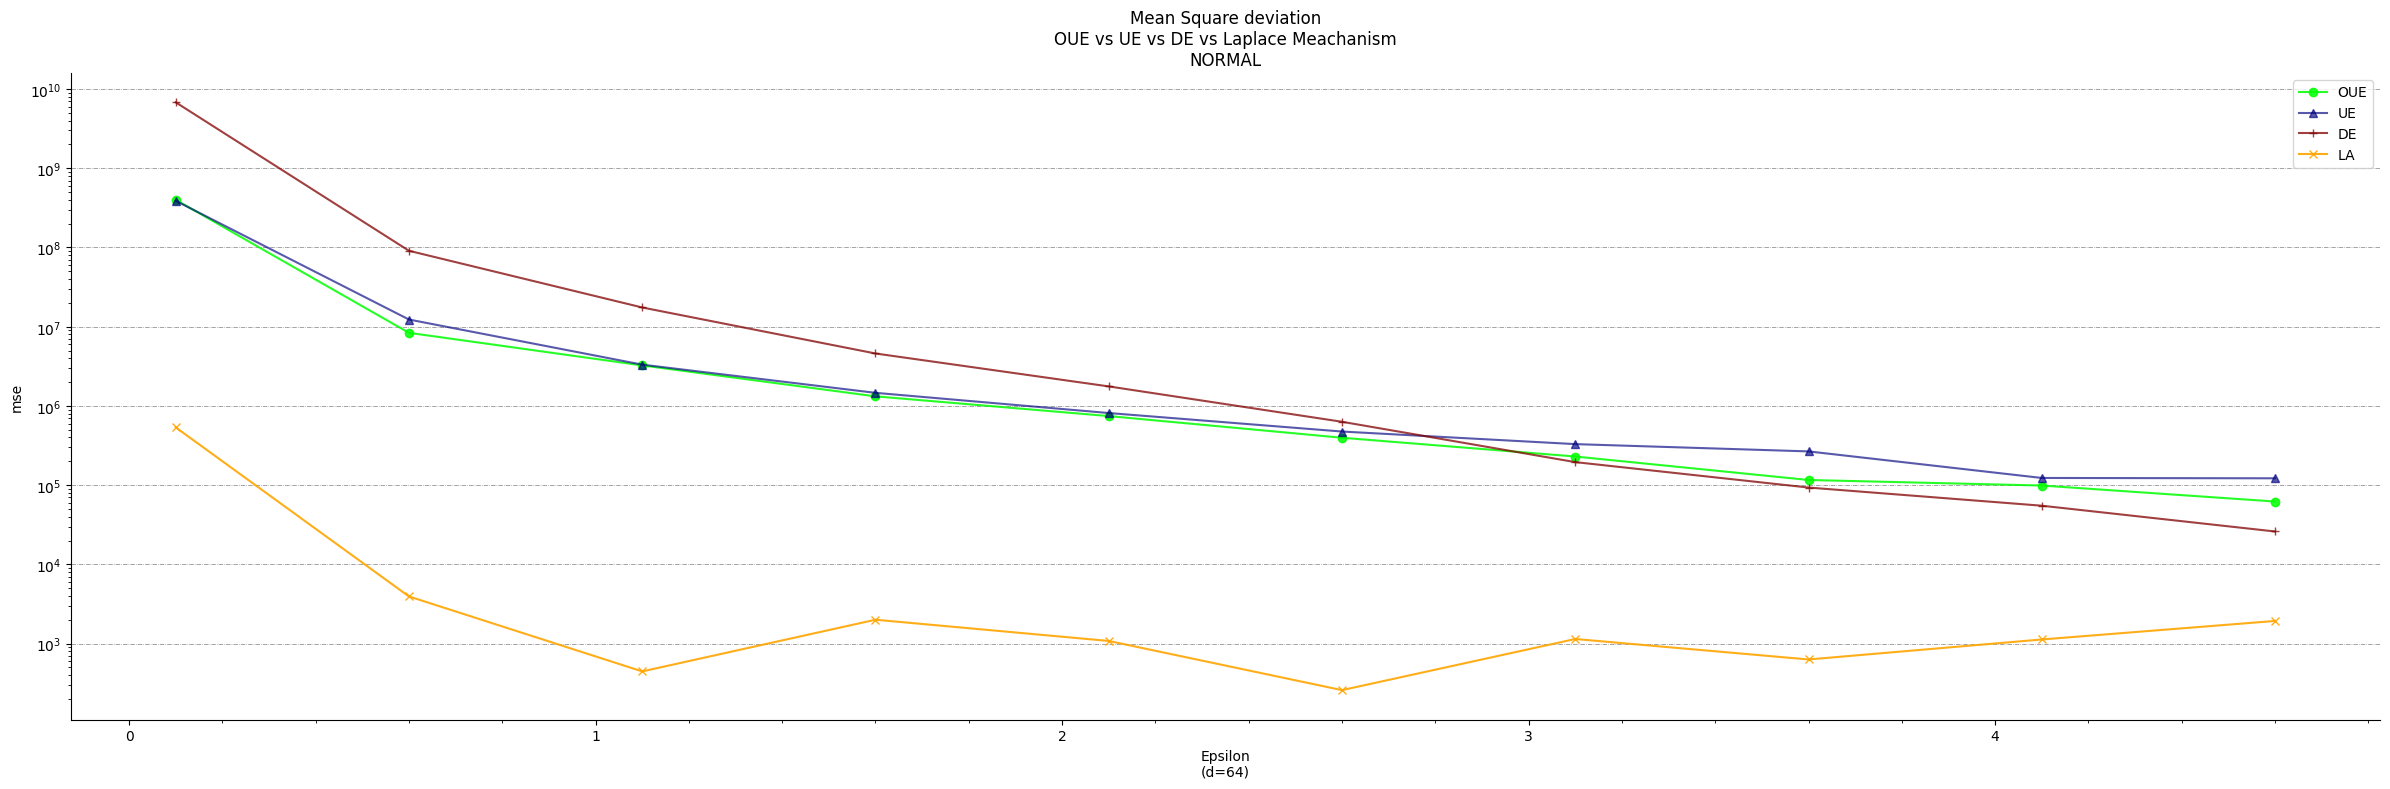

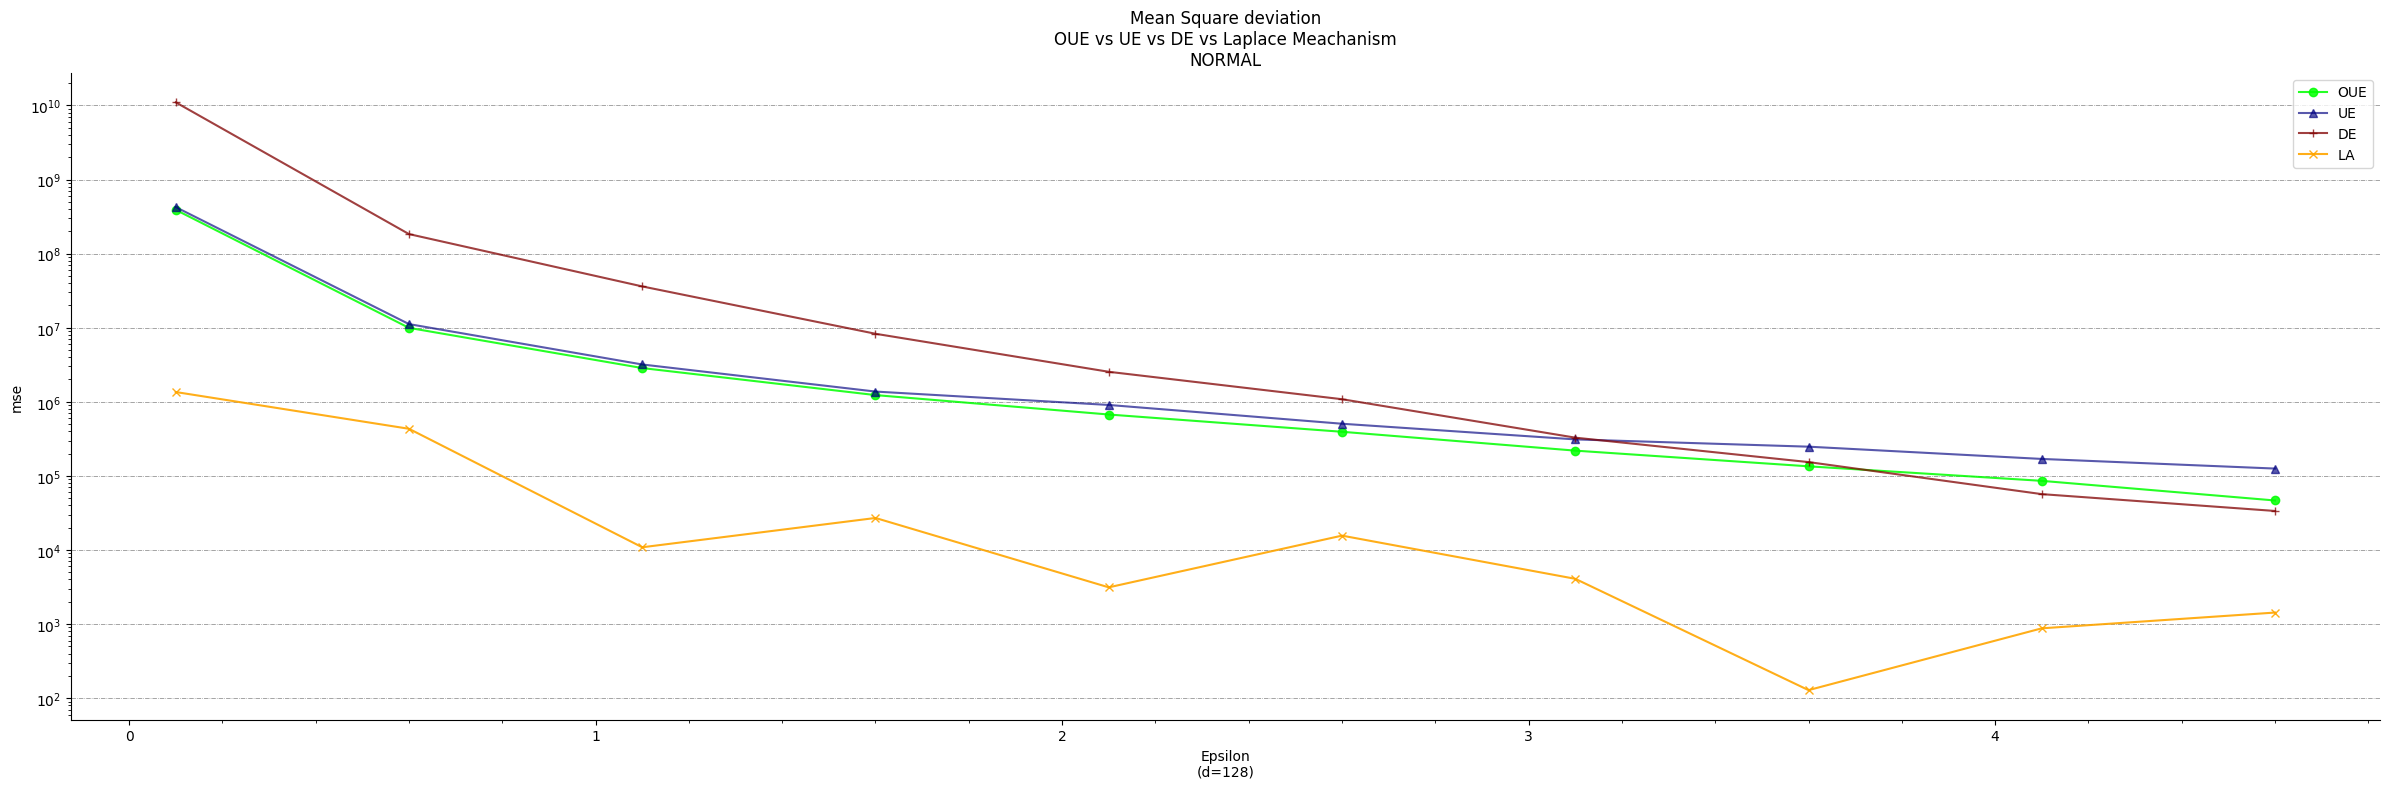

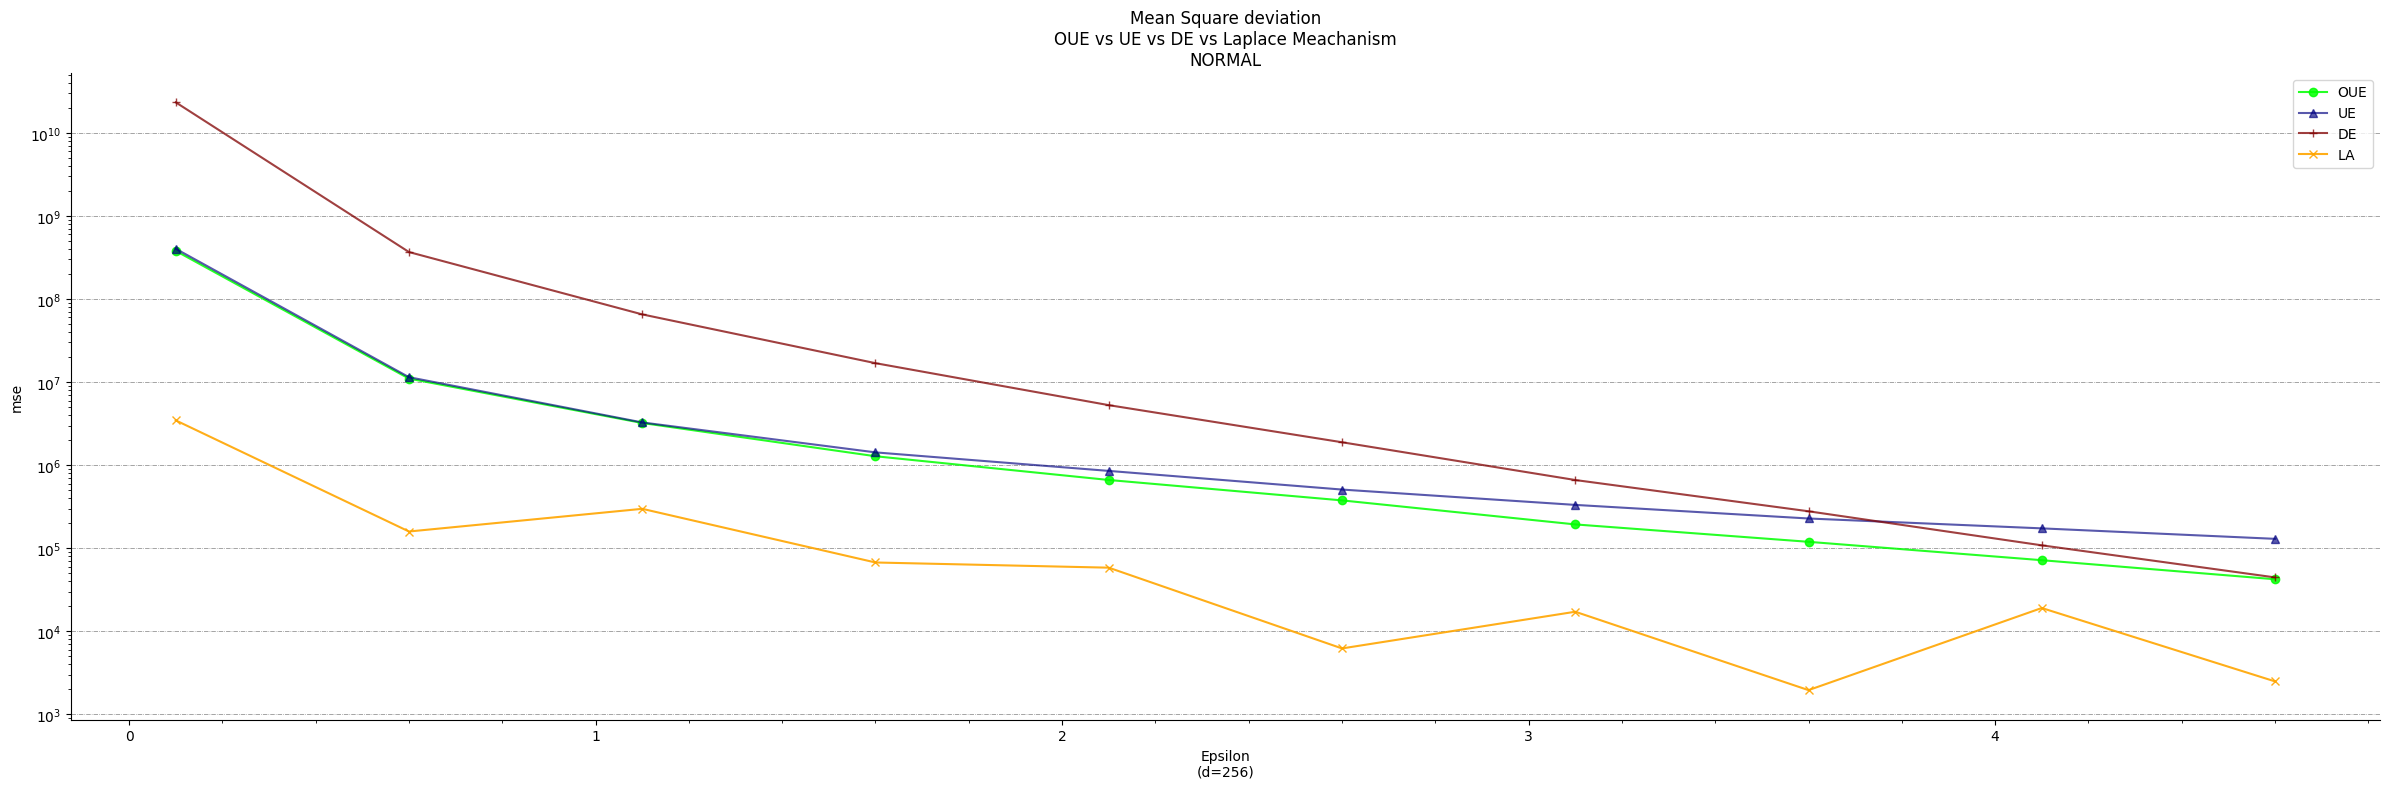

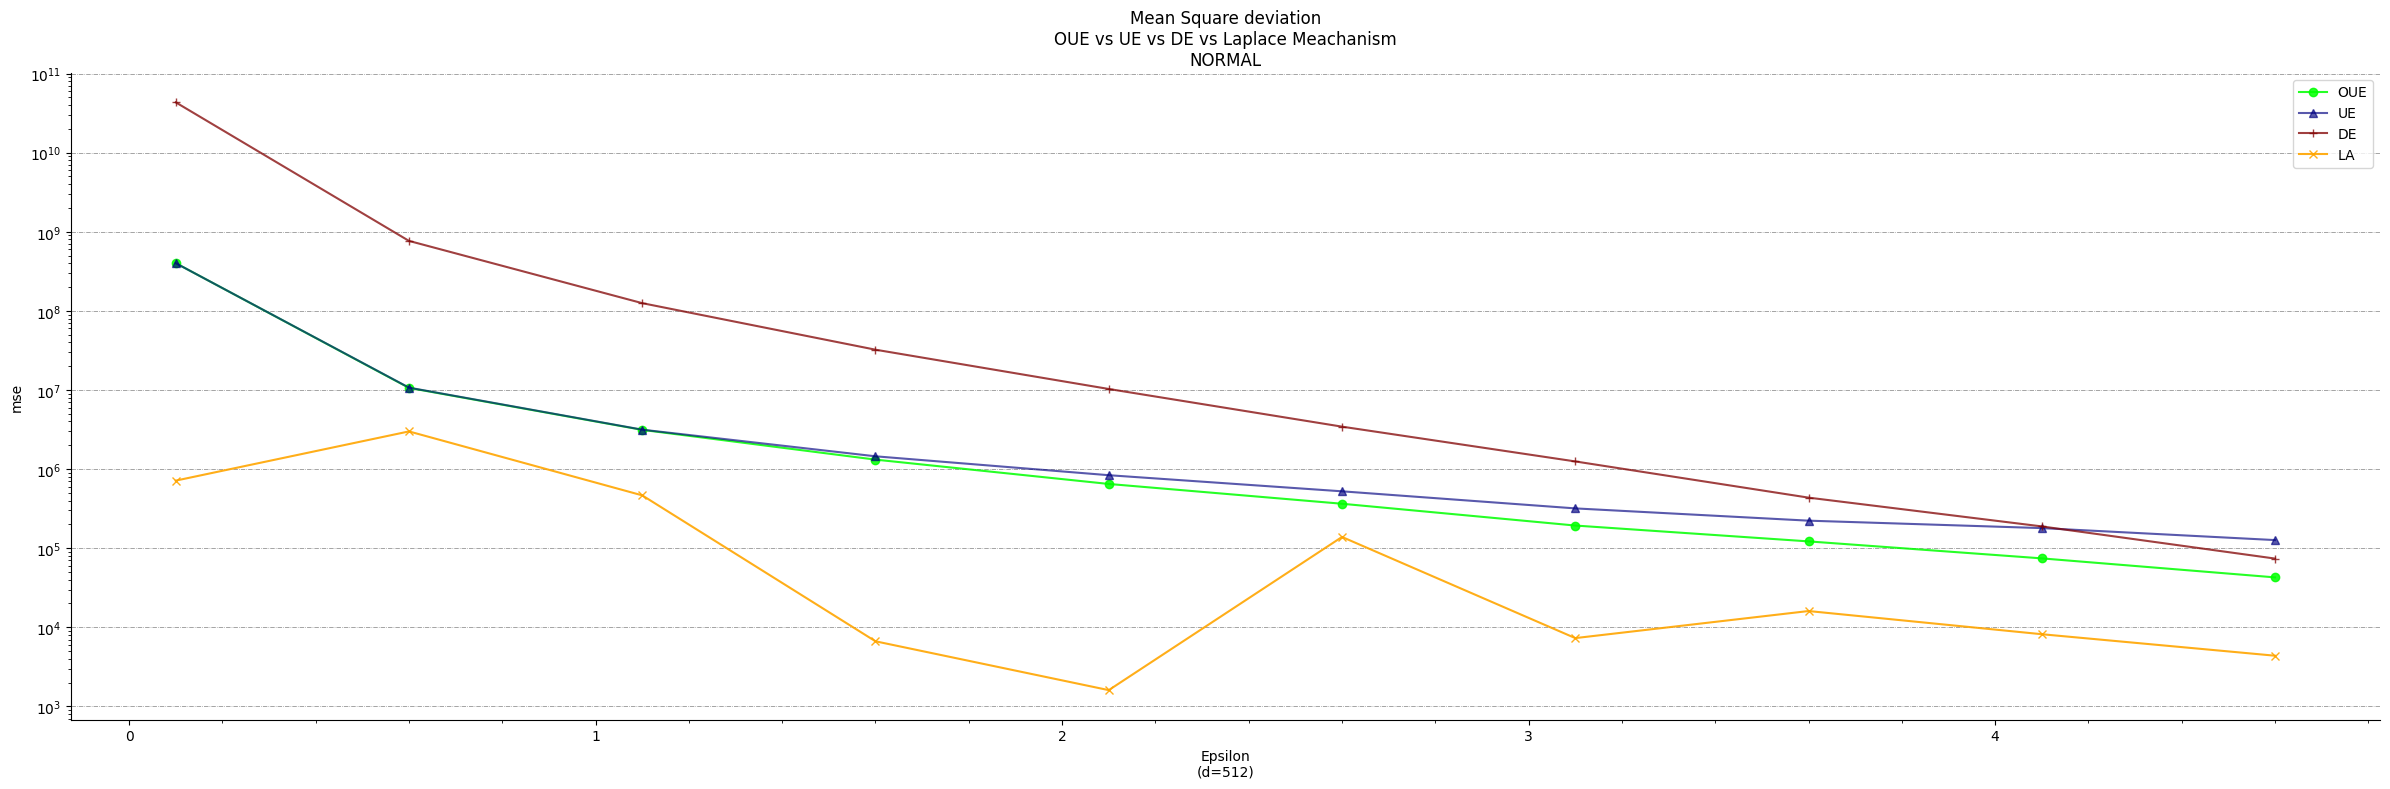

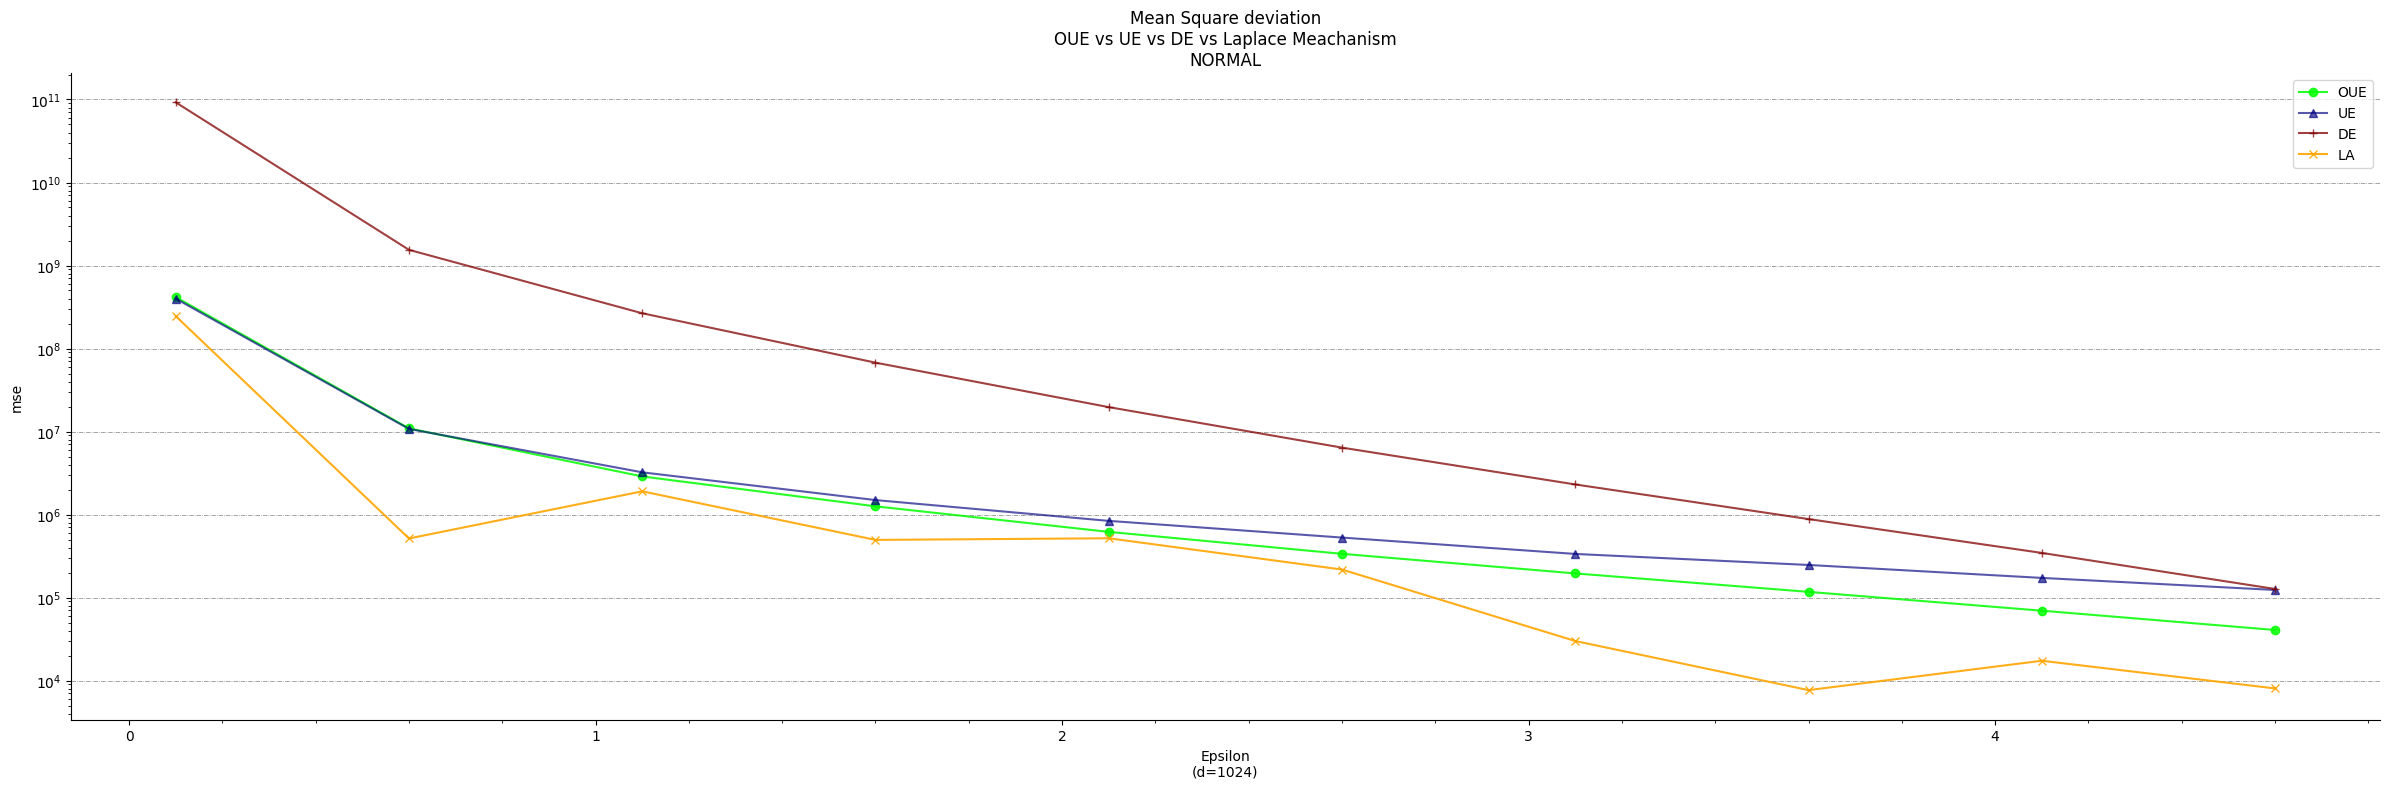

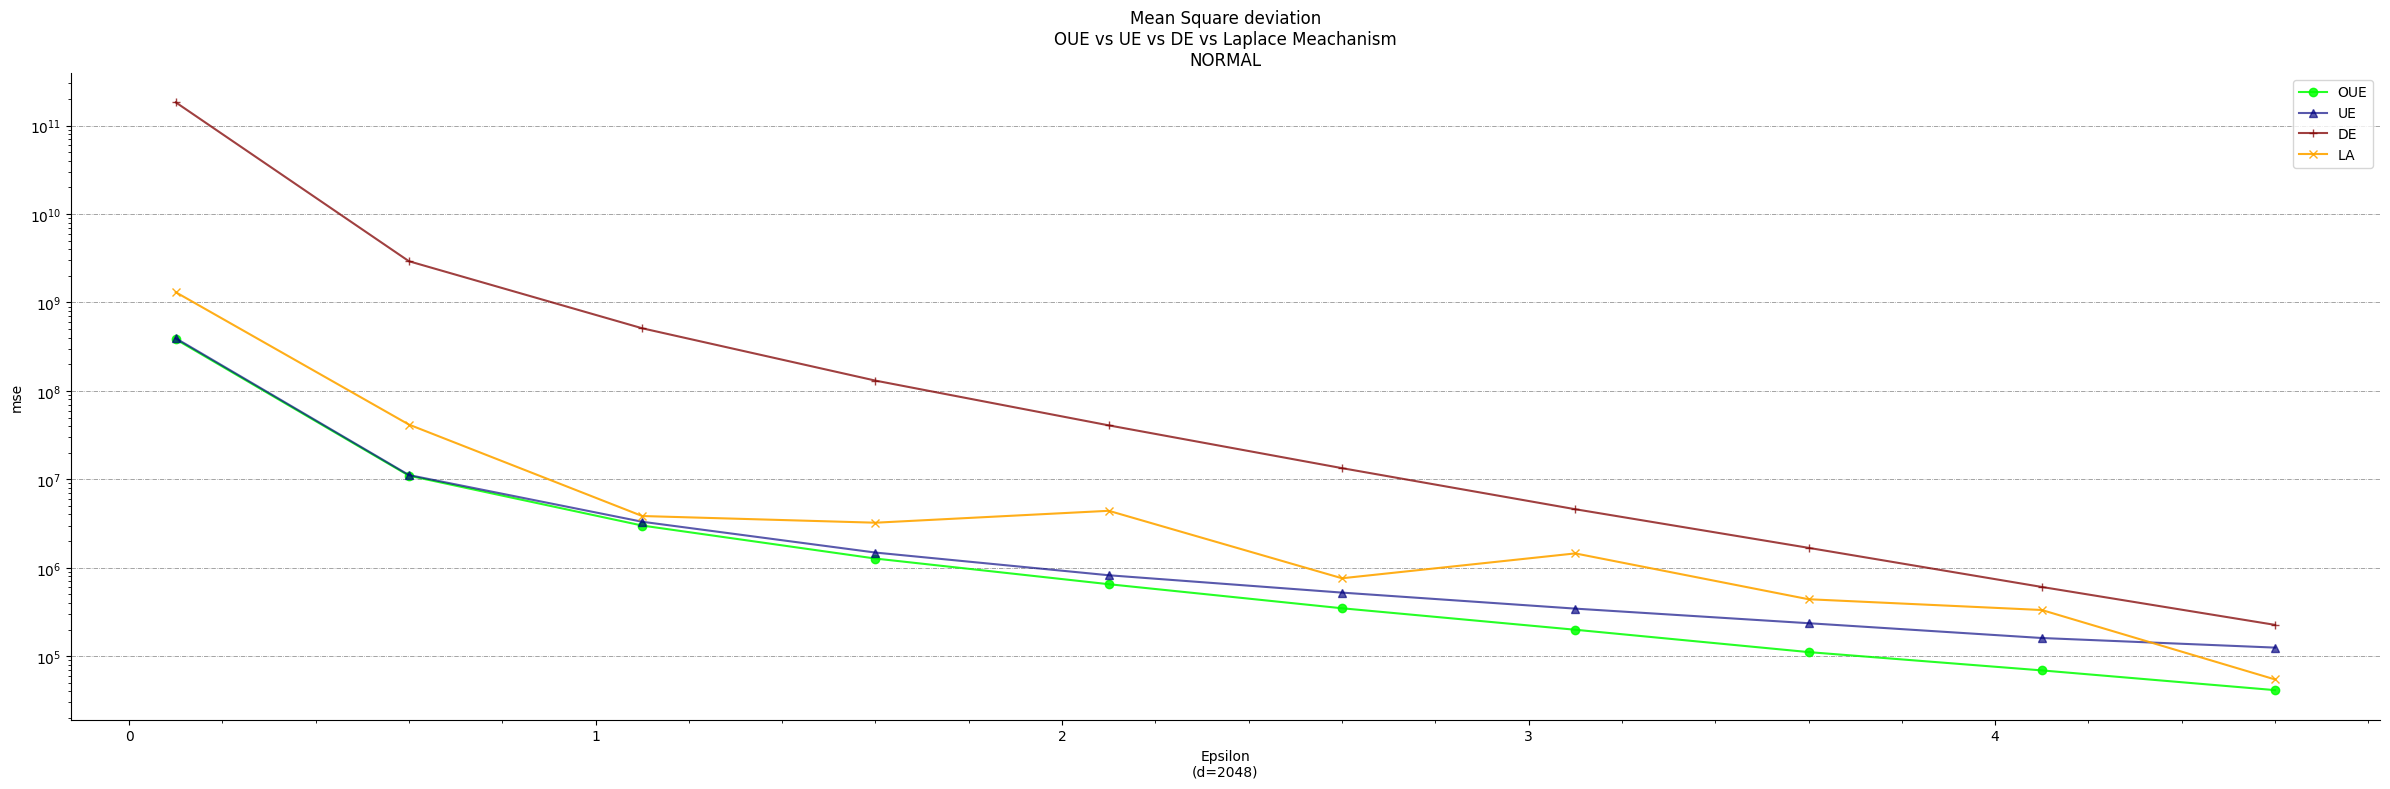

In [34]:
for i in range(1,12):
    d = 2**i

    normal_args = {
        'd': d,
        'mean': d/2,
        'std': d/7,
        'start': 0,
        'n': 10**6
    }
    
    epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg = meid(normal, 3, **normal_args)

    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_avg, mseUE_avg, marker='^', color='navy', alpha=0.65, label='UE')
    plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
    plt.plot(epsilon_avg, mseLA_avg, marker='x', color='orange', alpha=0.9, label='LA')
    
    plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism\nNORMAL')
    plt.xlabel(f'Epsilon\n(d={d})')
    plt.ylabel('mse')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()


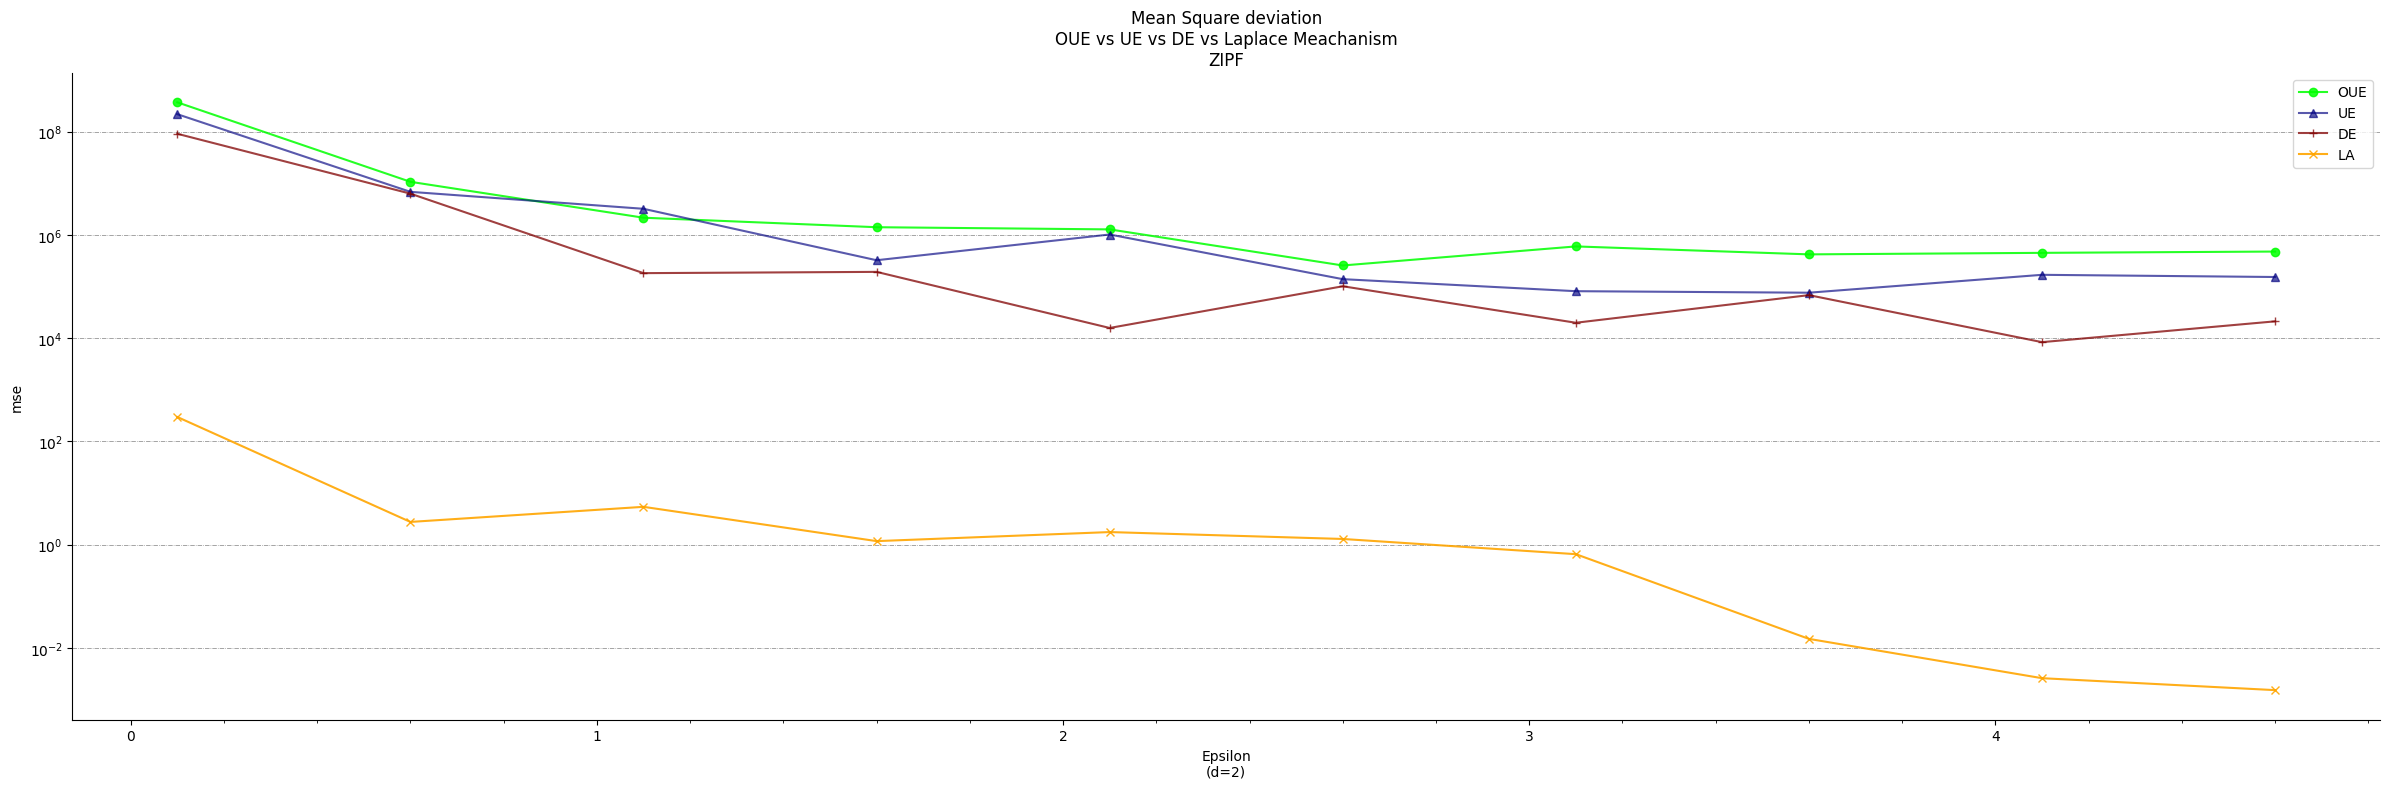

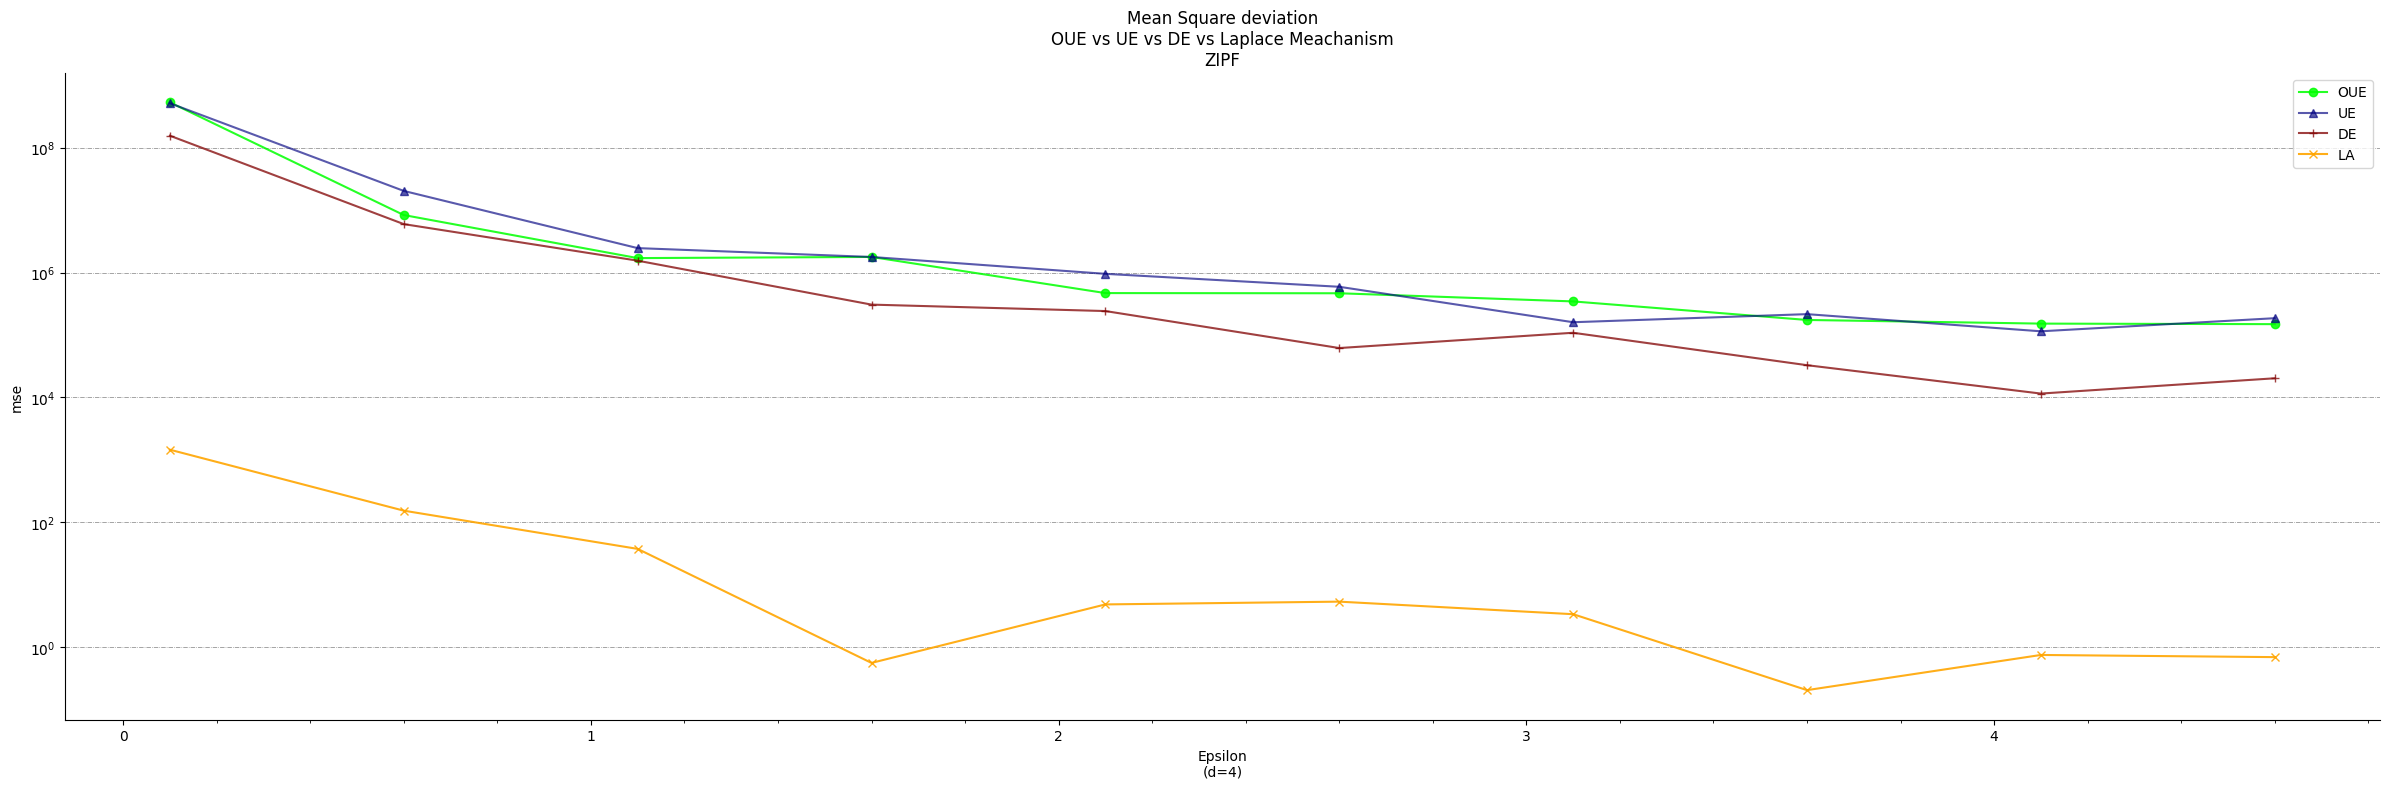

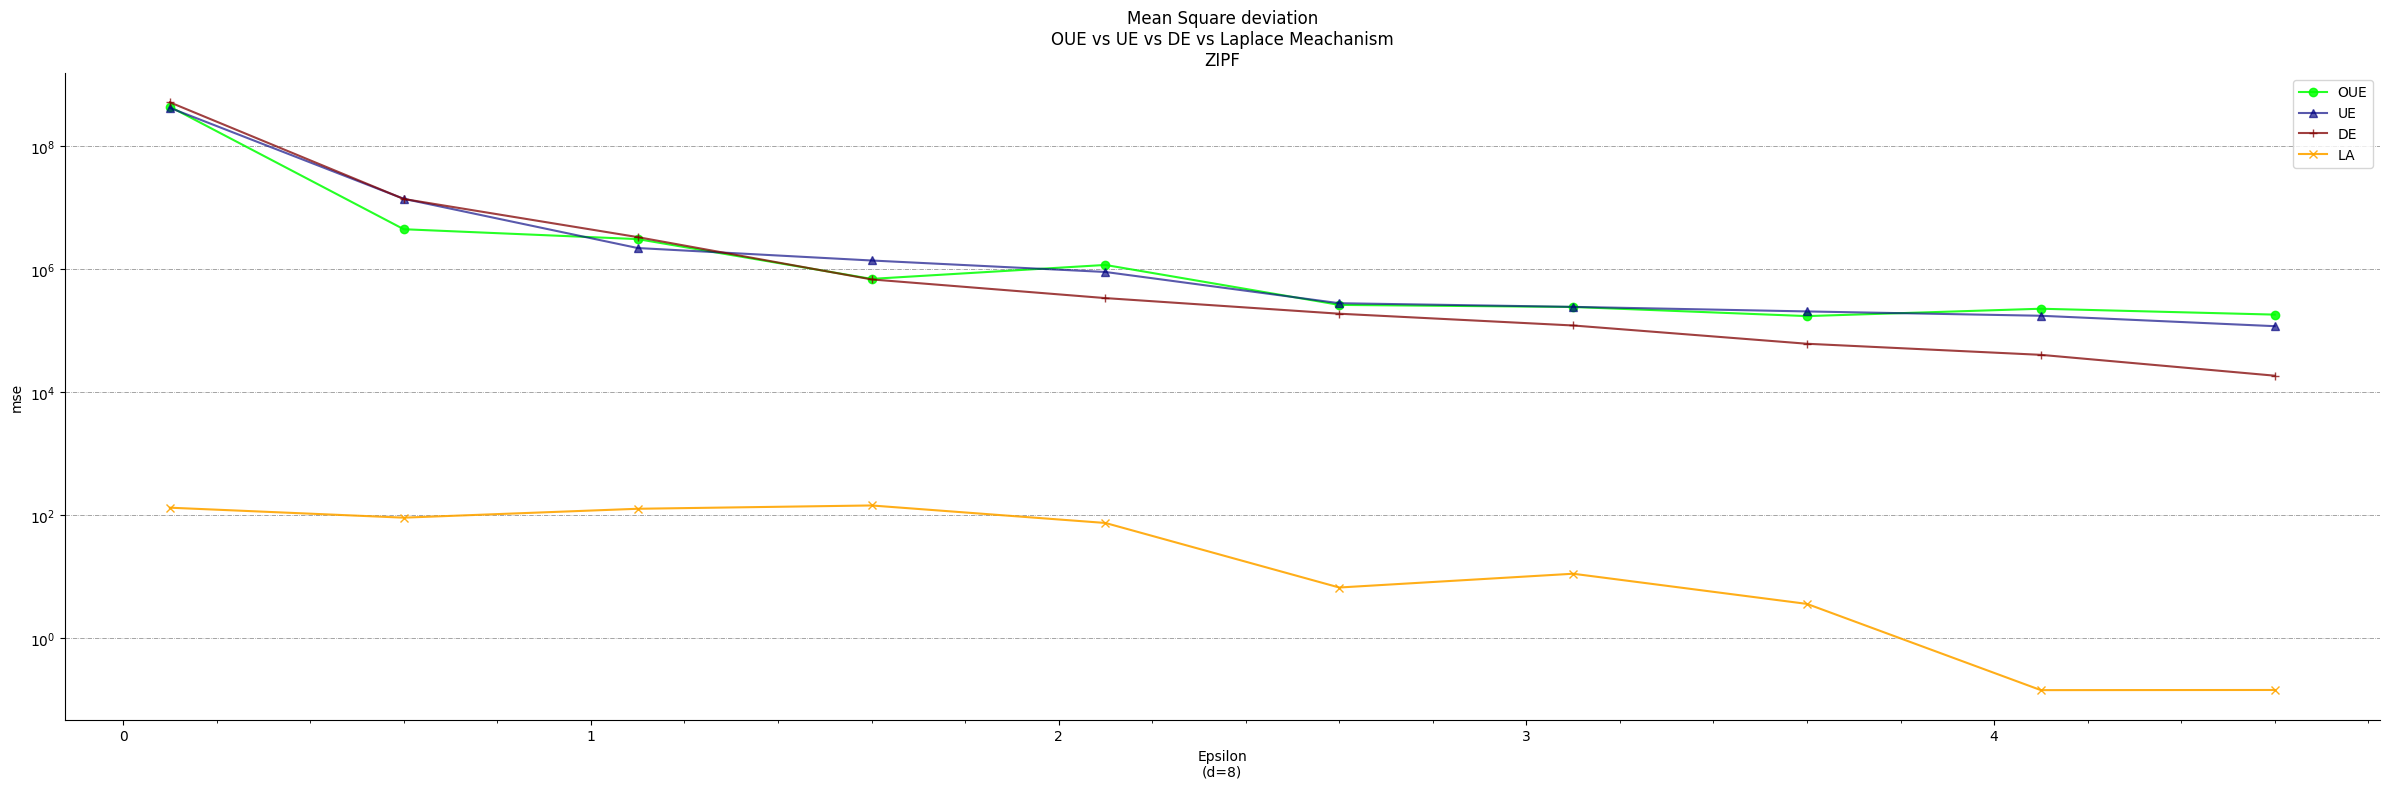

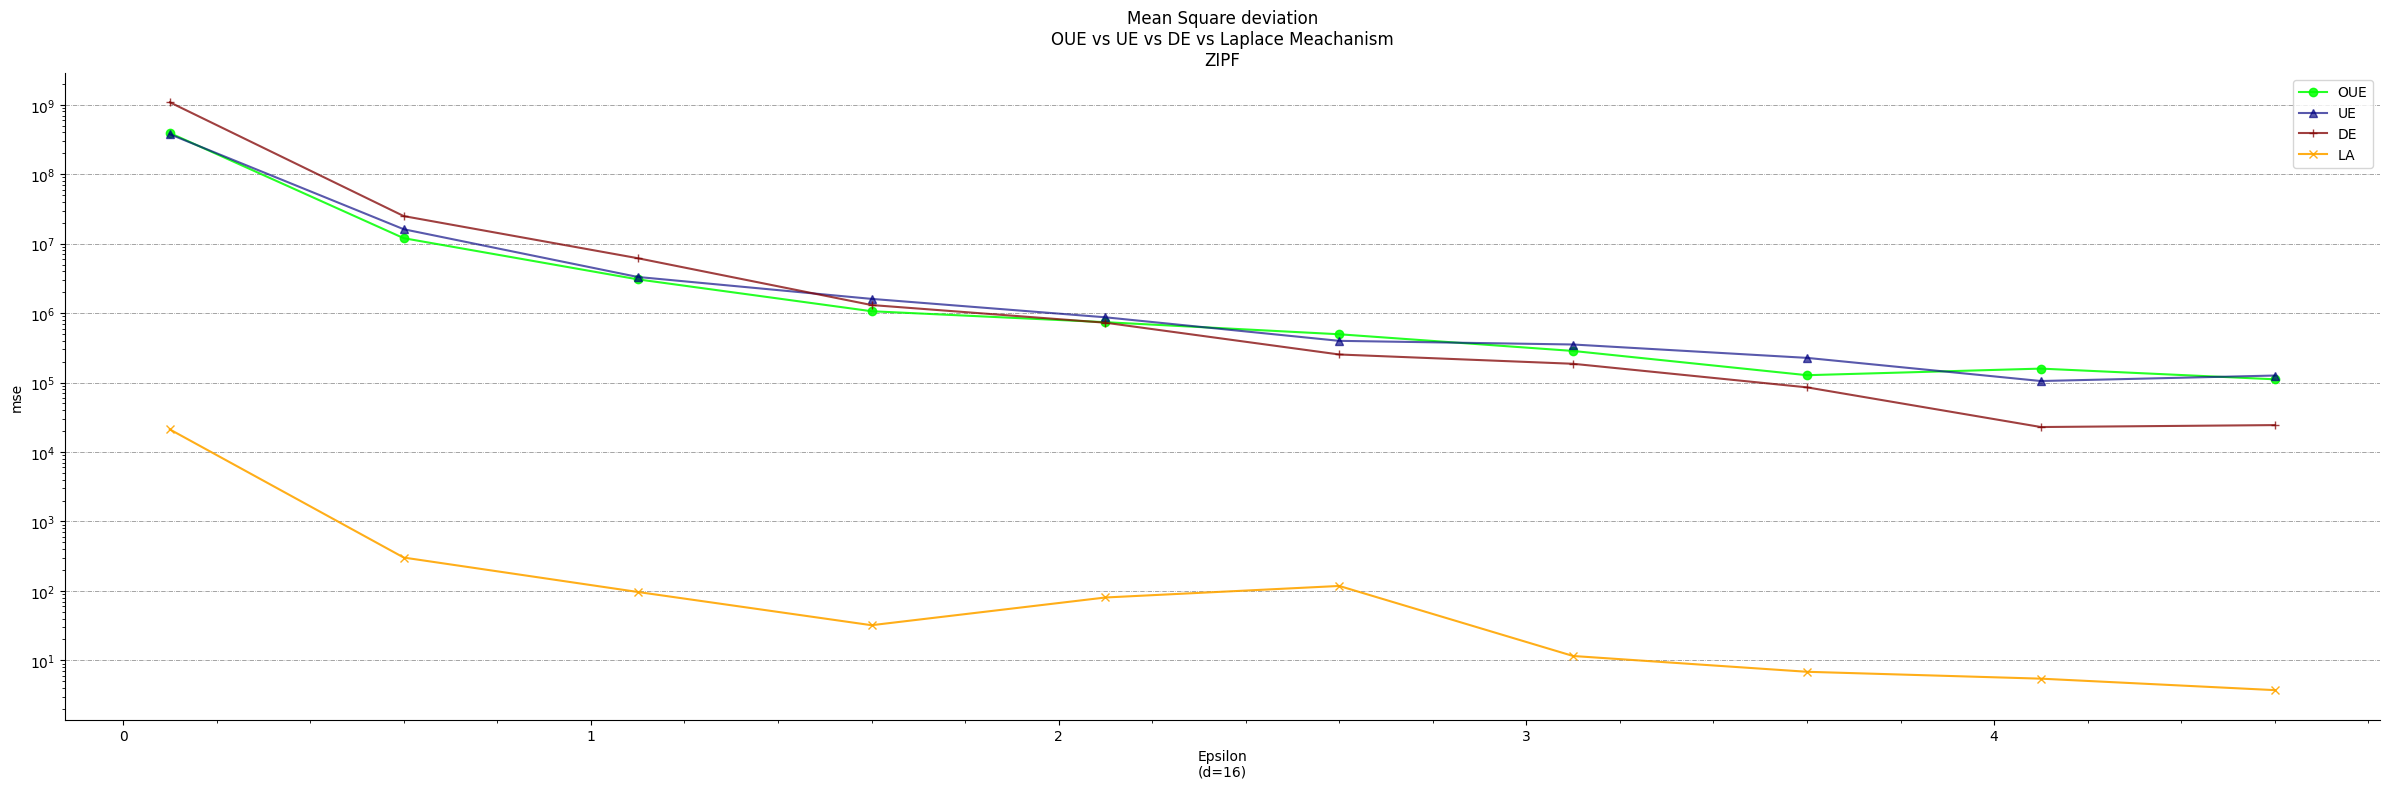

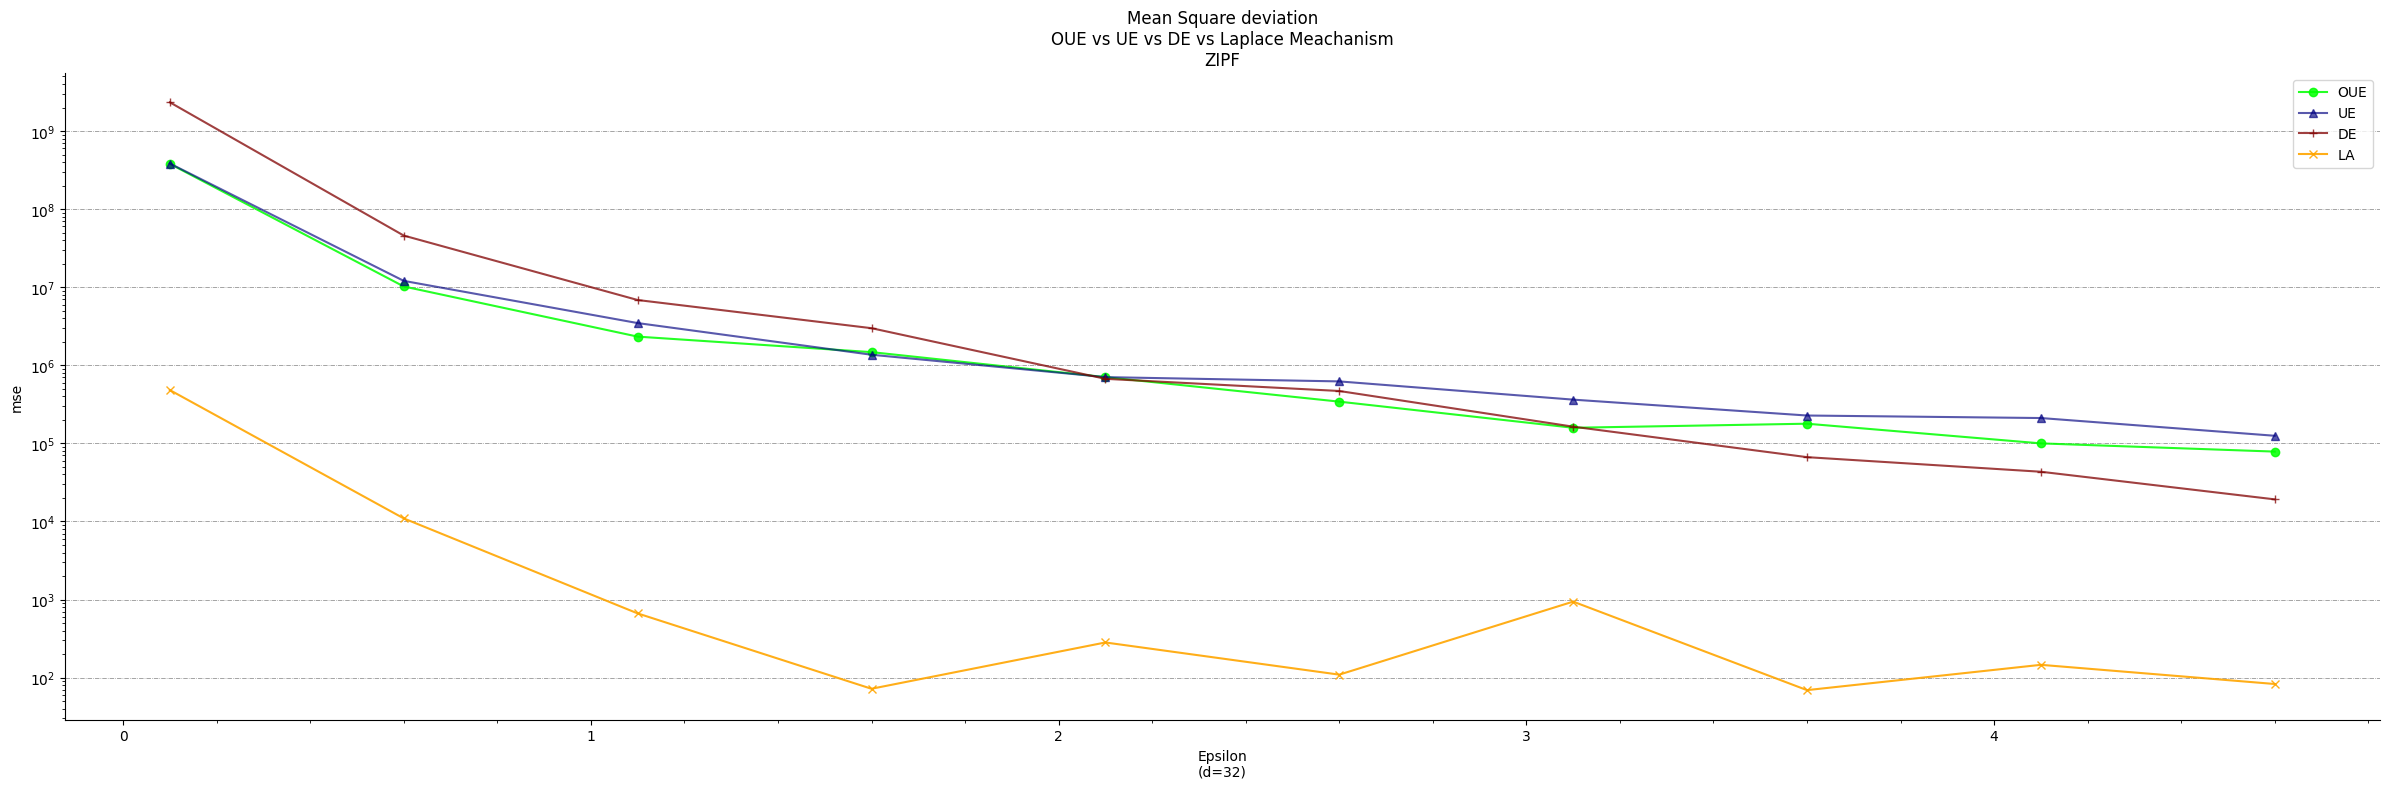

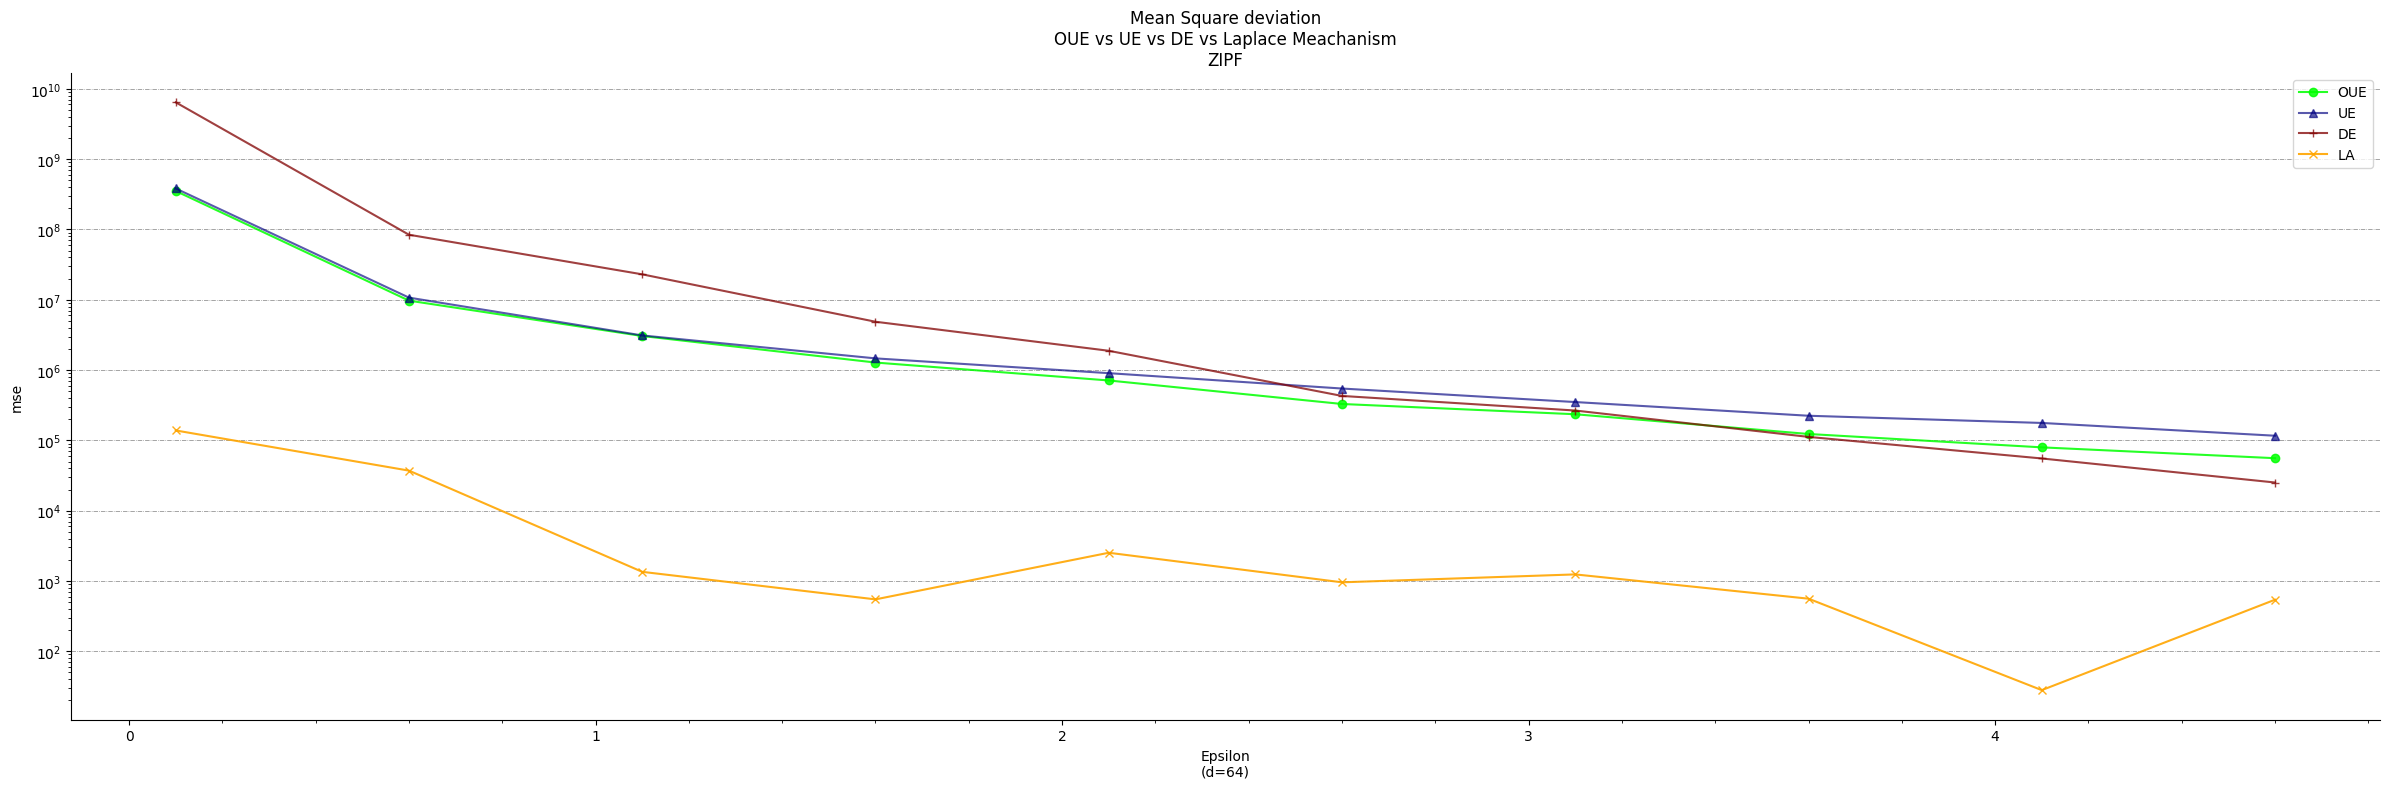

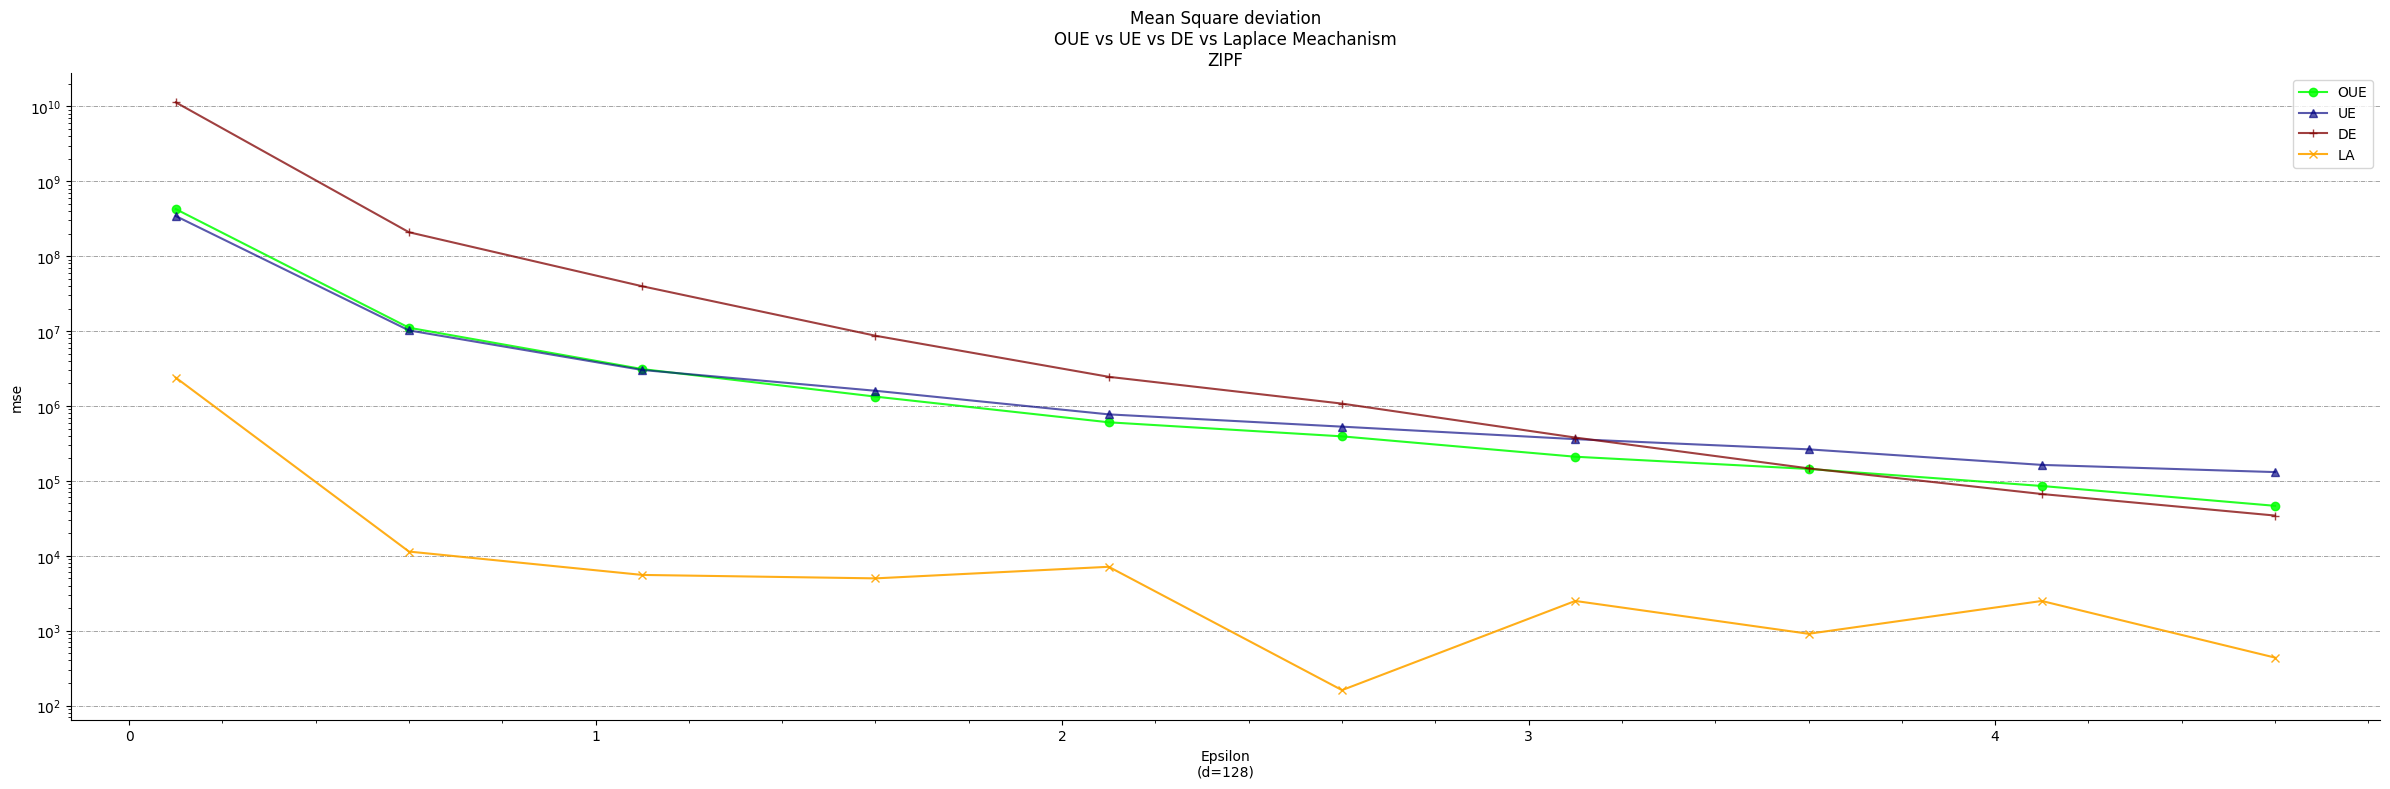

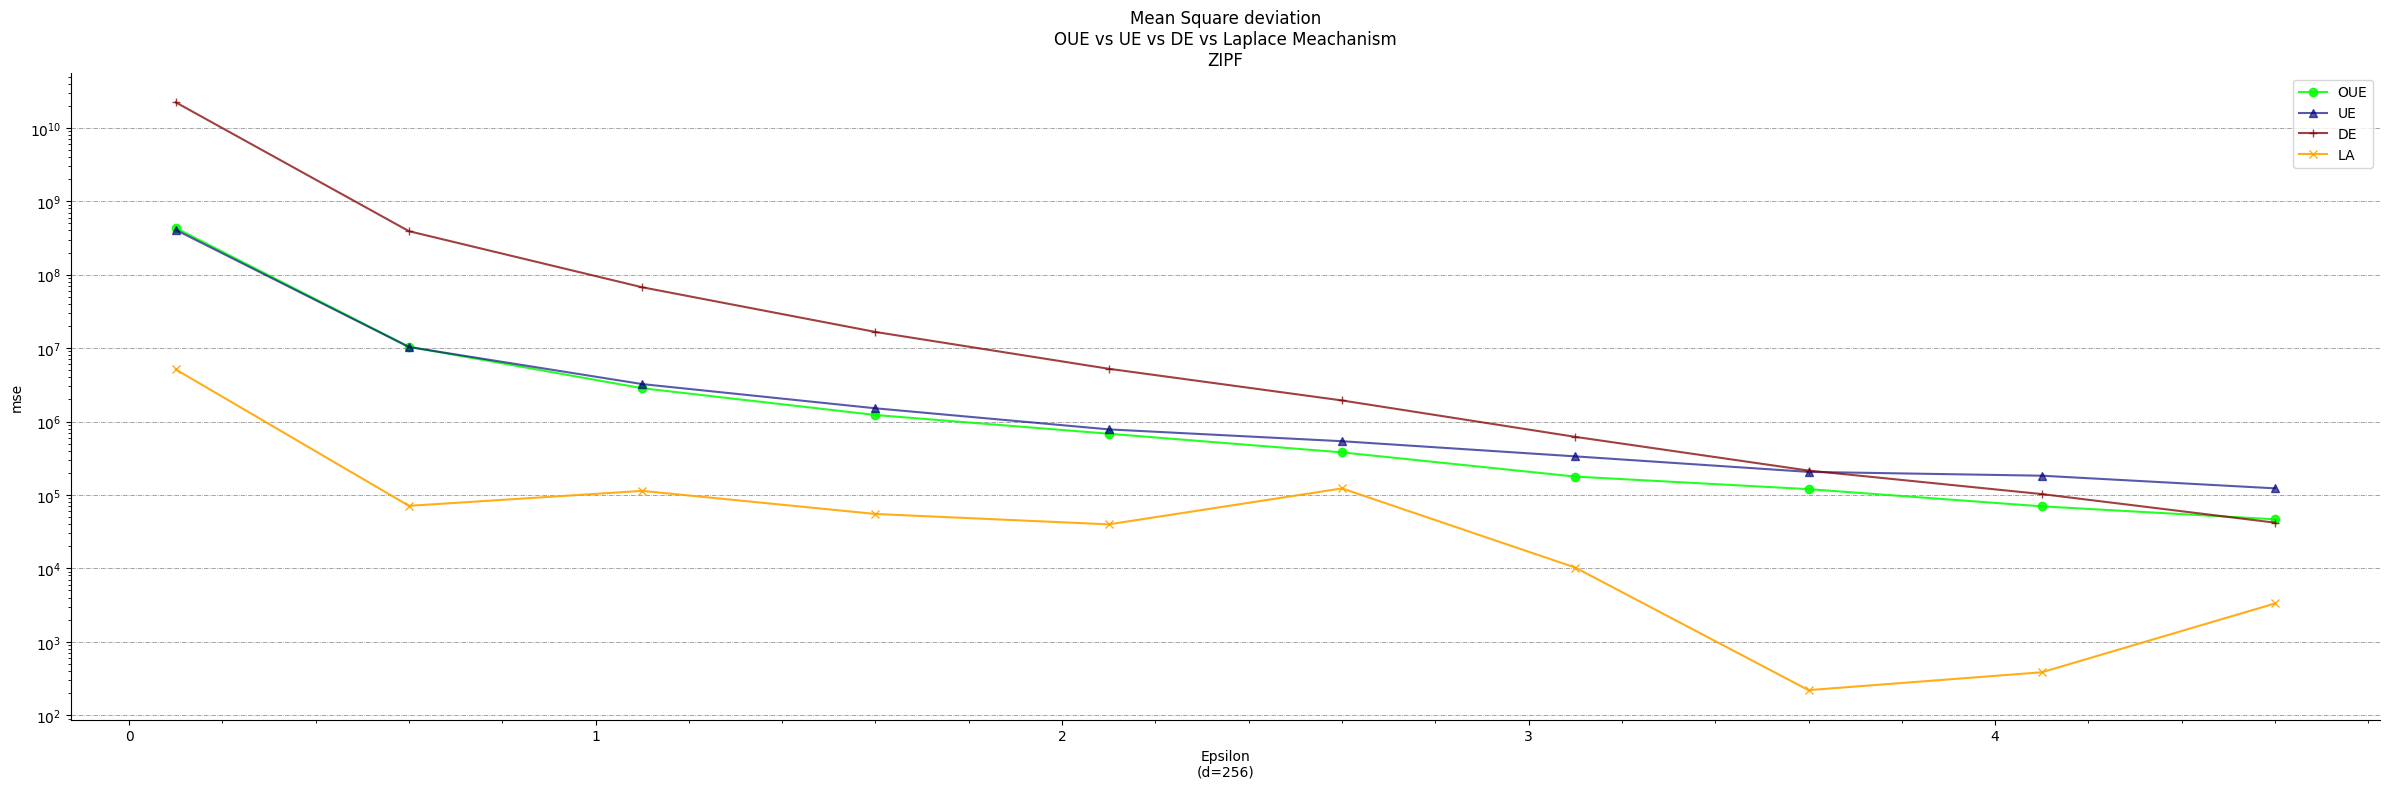

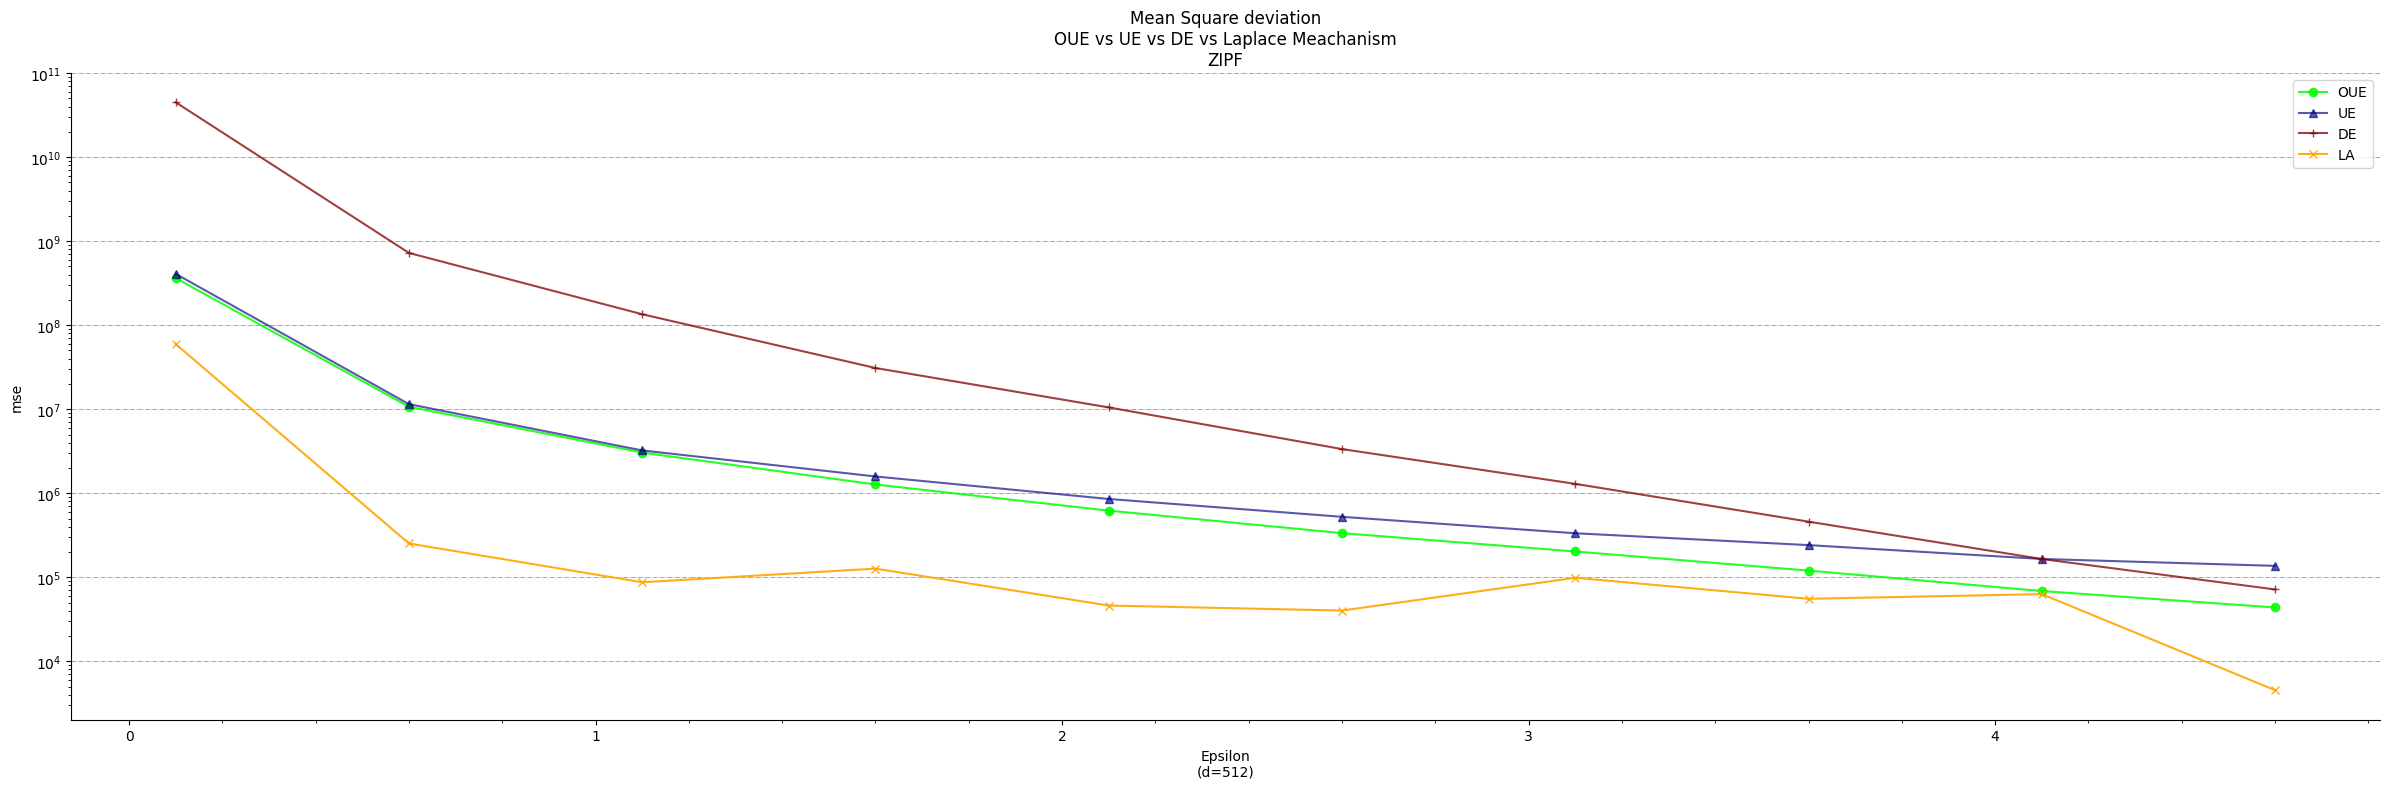

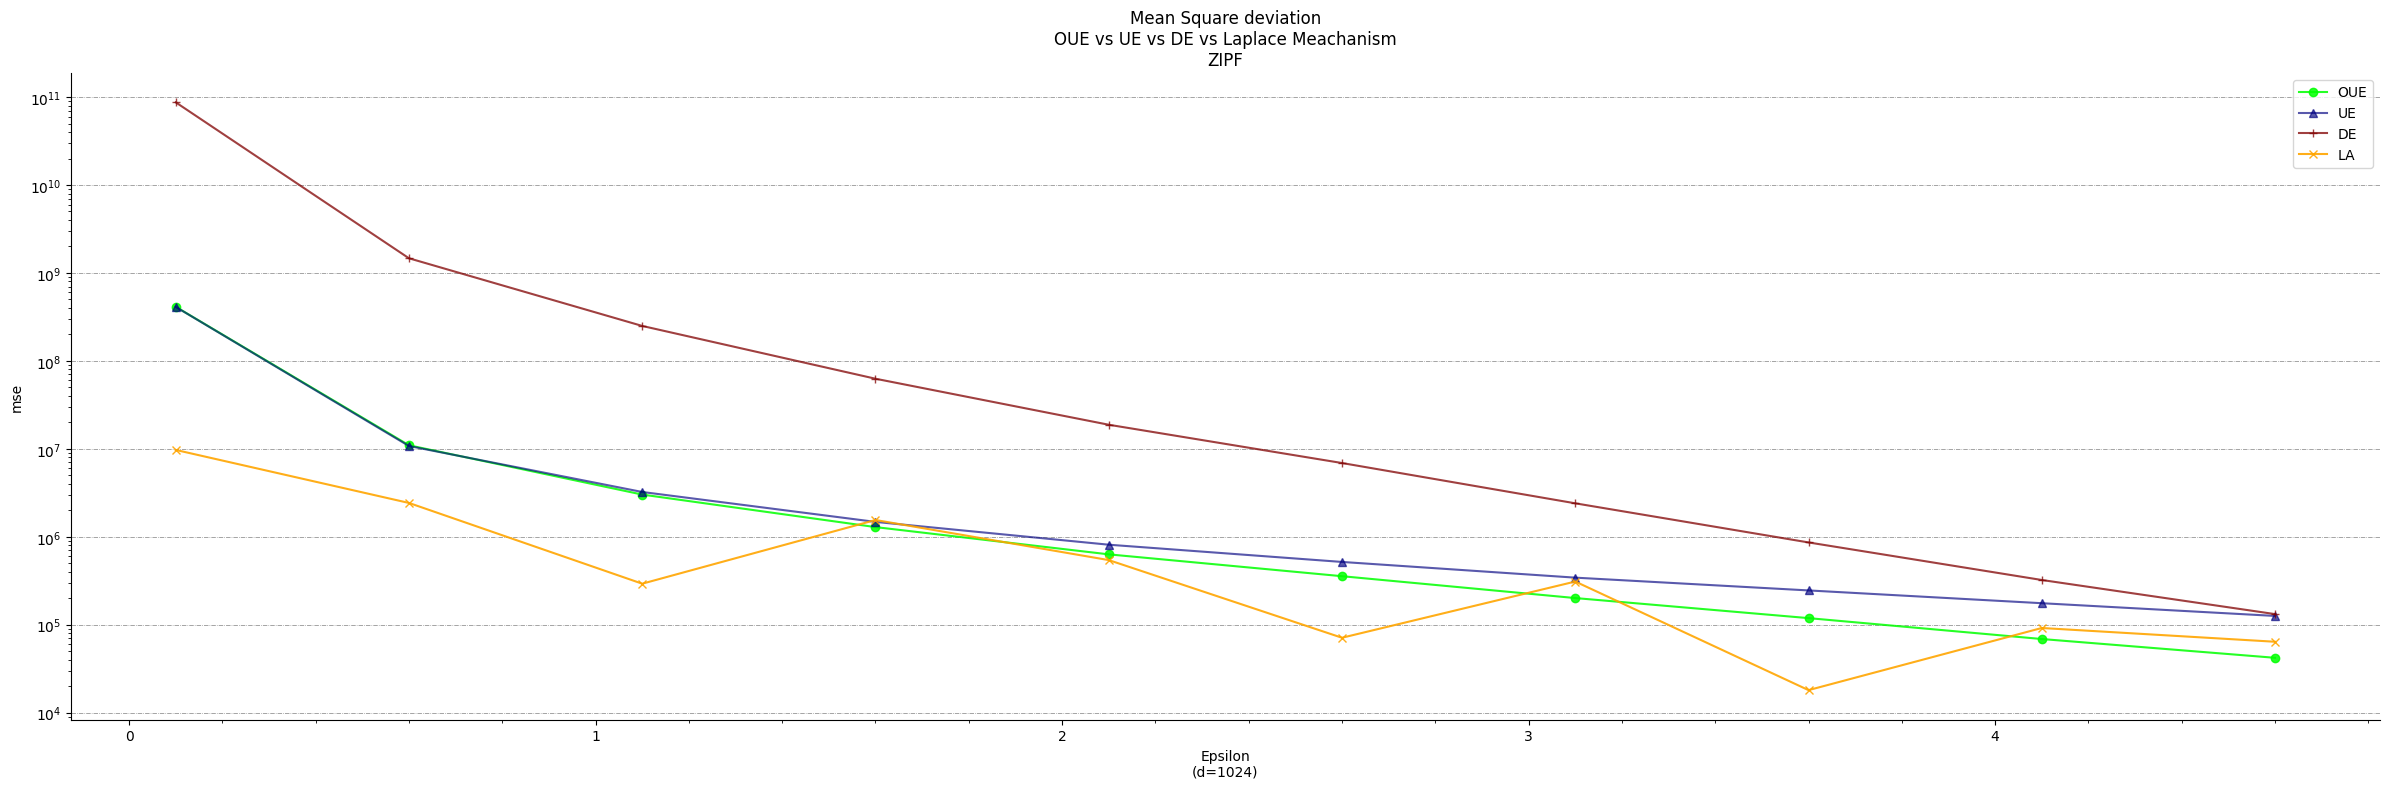

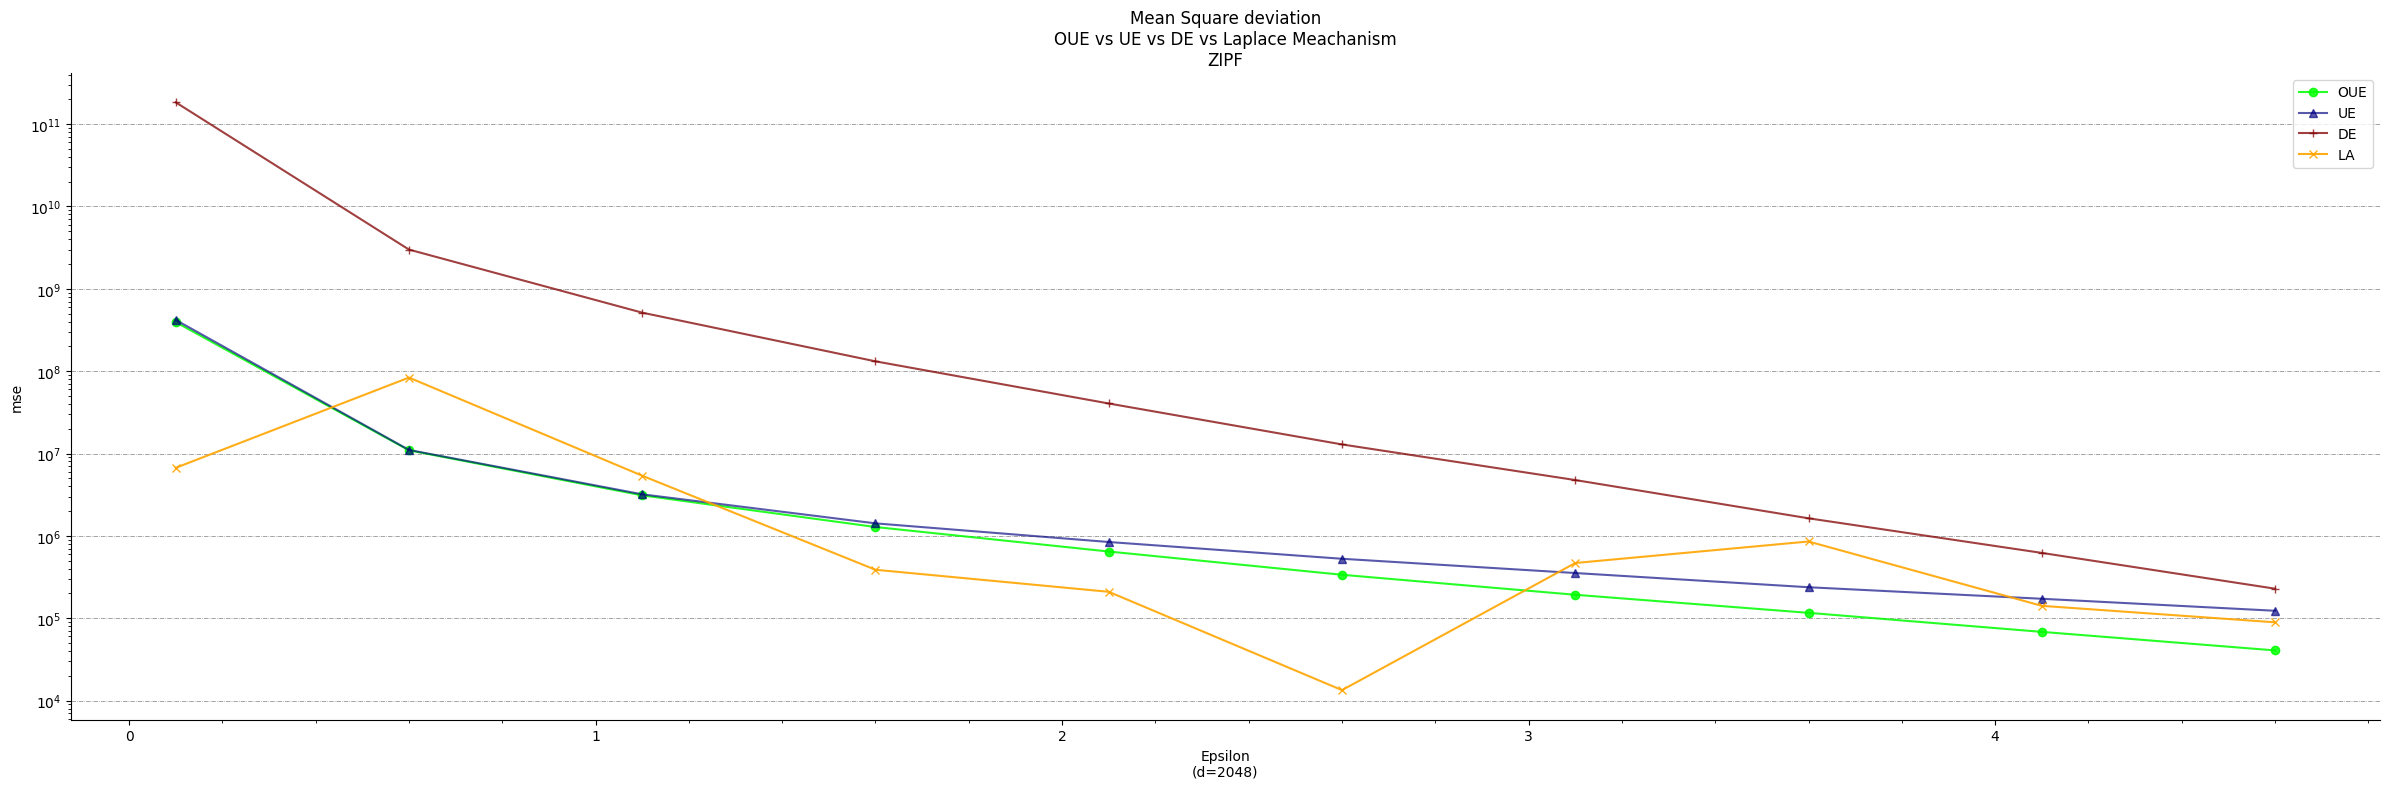

In [35]:
for i in range(1,12):
    d = 2**i

    zipf_args = {
        'd': d,
        'n': 10**6,
        'a': 1.5
    }
    
    epsilon_avg, mseOUE_avg, mseUE_avg, mseDE_avg, mseLA_avg = meid(zipf, 3, **zipf_args)

    plt.figure(figsize=(24, 8))
    
    plt.plot(epsilon_avg, mseOUE_avg, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_avg, mseUE_avg, marker='^', color='navy', alpha=0.65, label='UE')
    plt.plot(epsilon_avg, mseDE_avg, marker='+', color='maroon', alpha=0.75, label='DE')
    plt.plot(epsilon_avg, mseLA_avg, marker='x', color='orange', alpha=0.9, label='LA')
    
    plt.title('Mean Square deviation\nOUE vs UE vs DE vs Laplace Meachanism\nZIPF')
    plt.xlabel(f'Epsilon\n(d={d})')
    plt.ylabel('mse')
    plt.yscale('log')
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.minorticks_on()
    
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    plt.tight_layout()
    plt.show()


## the stuff og

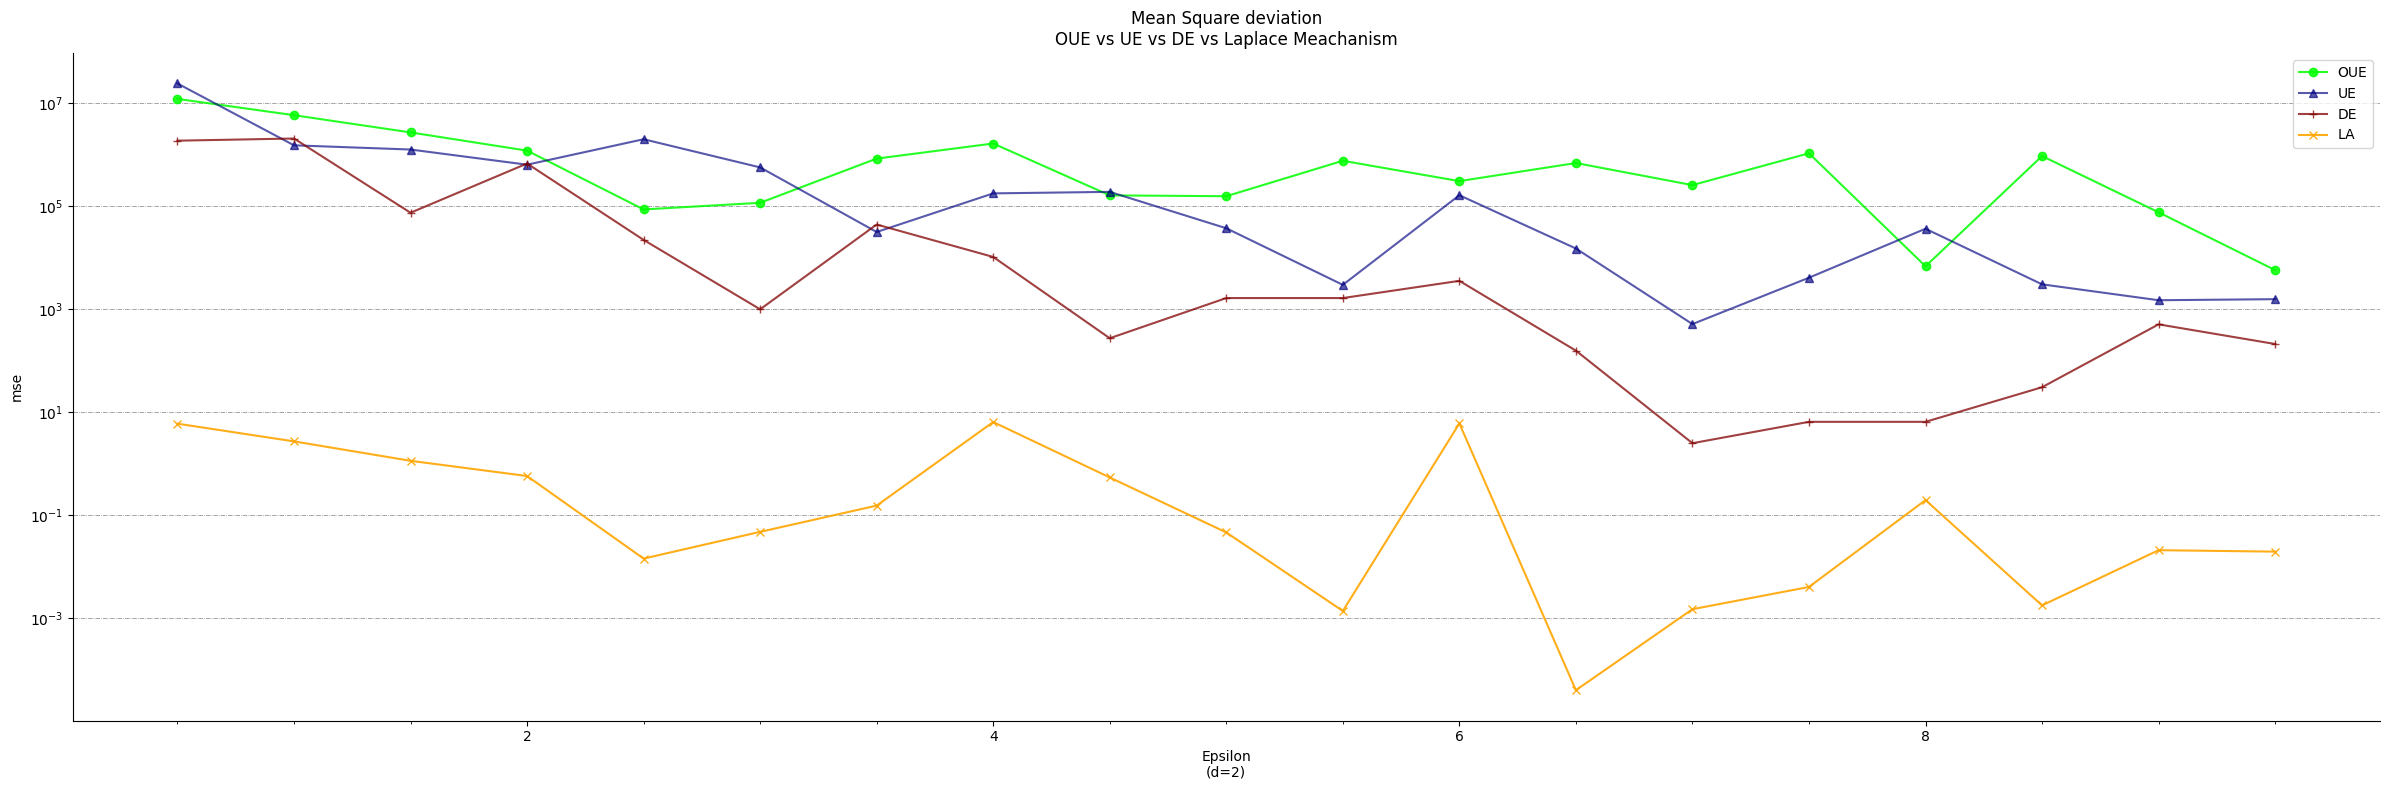

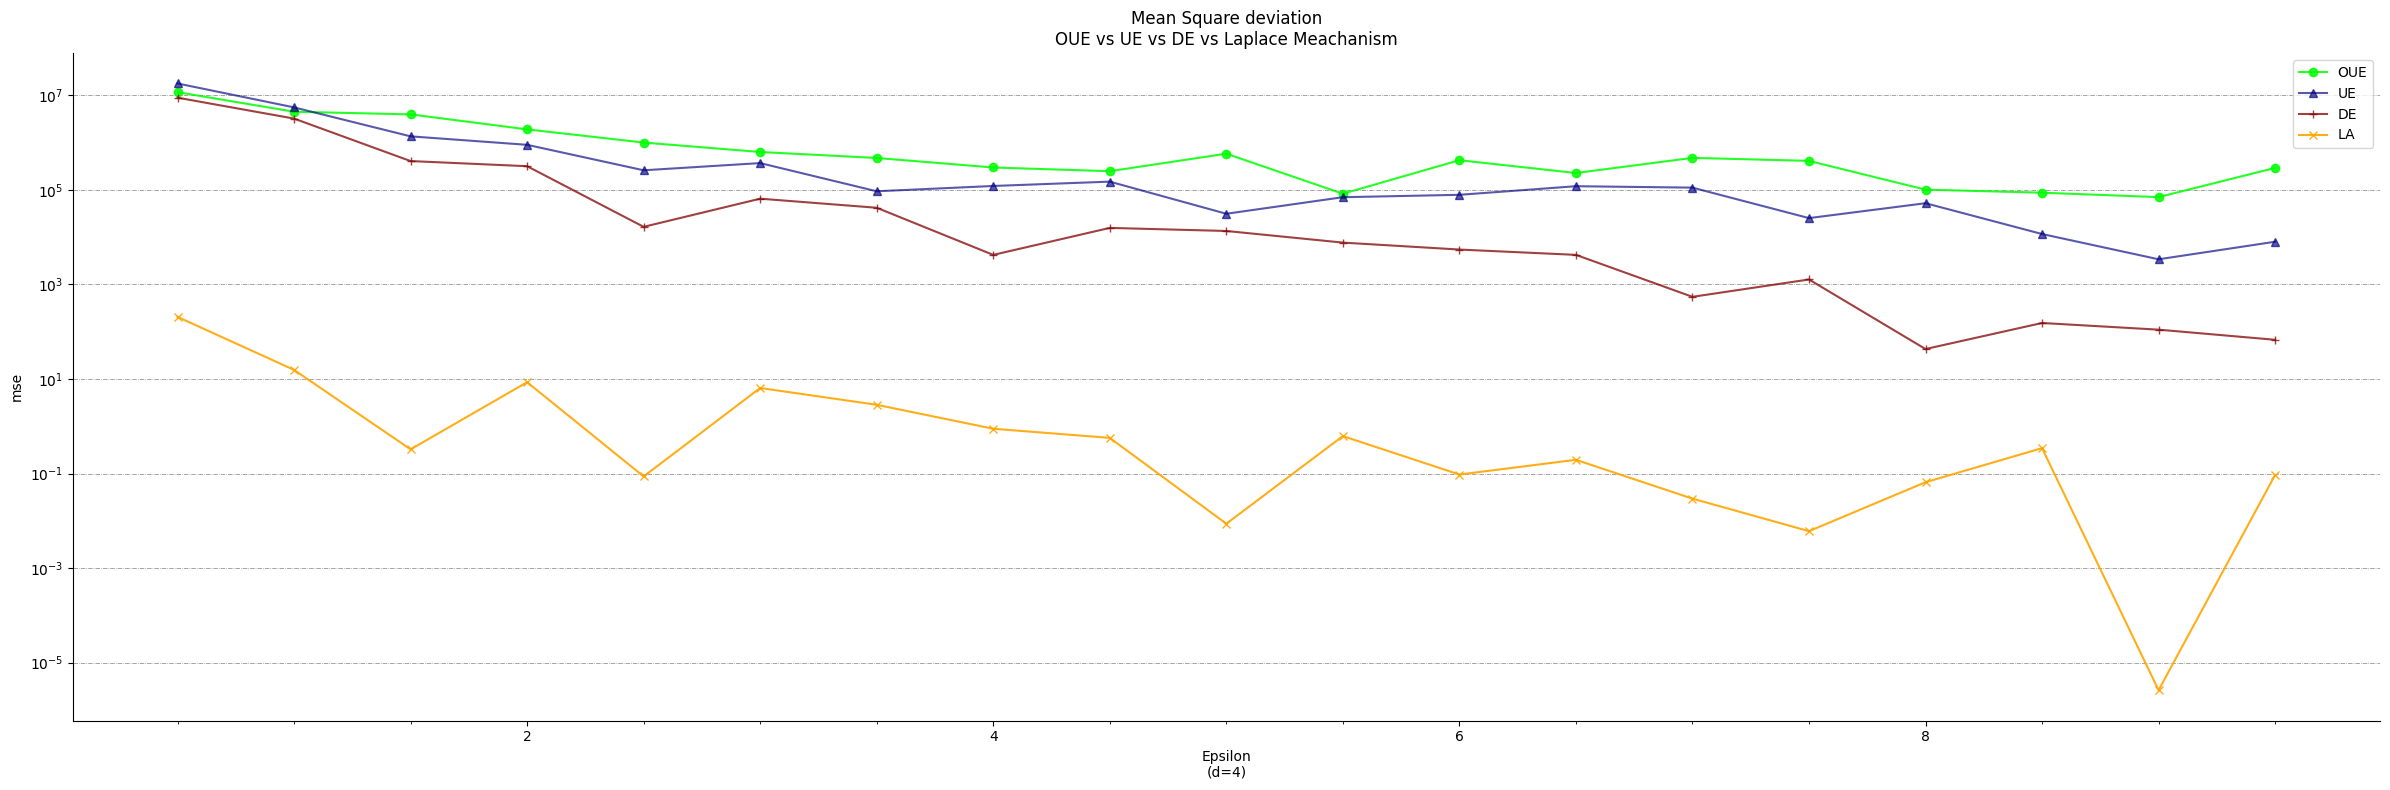

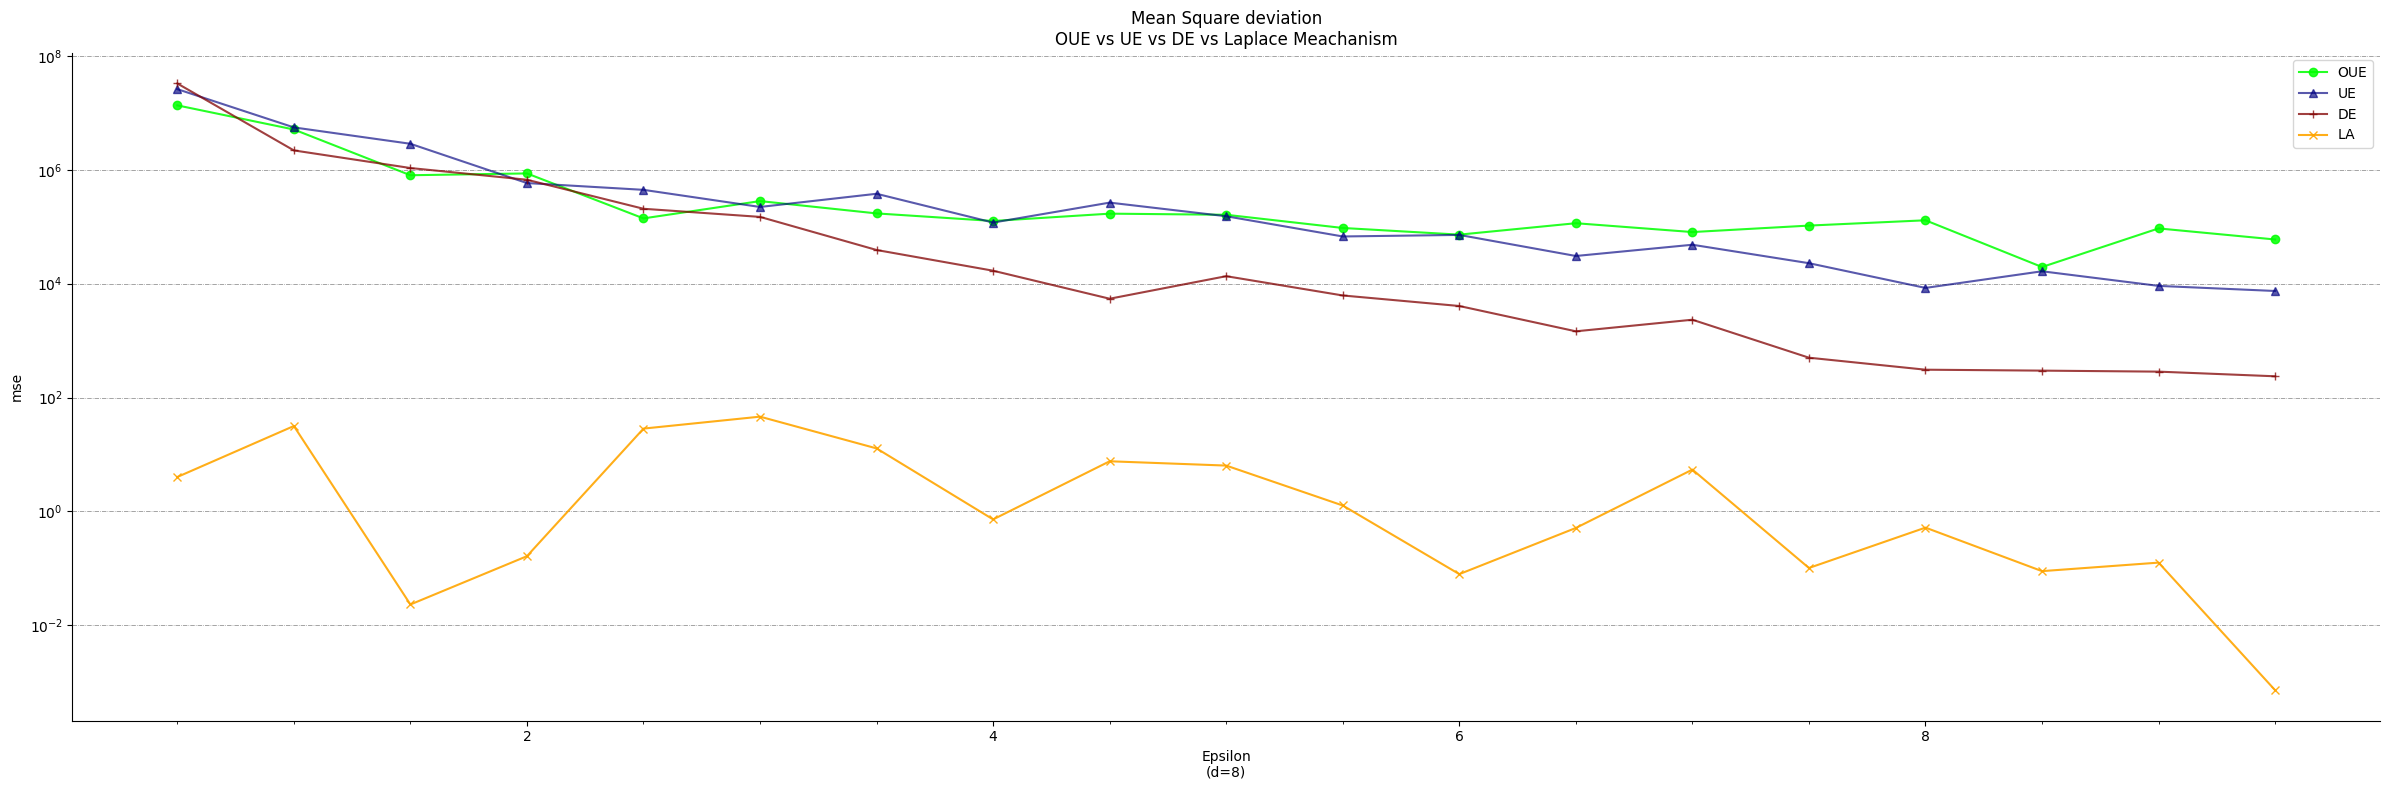

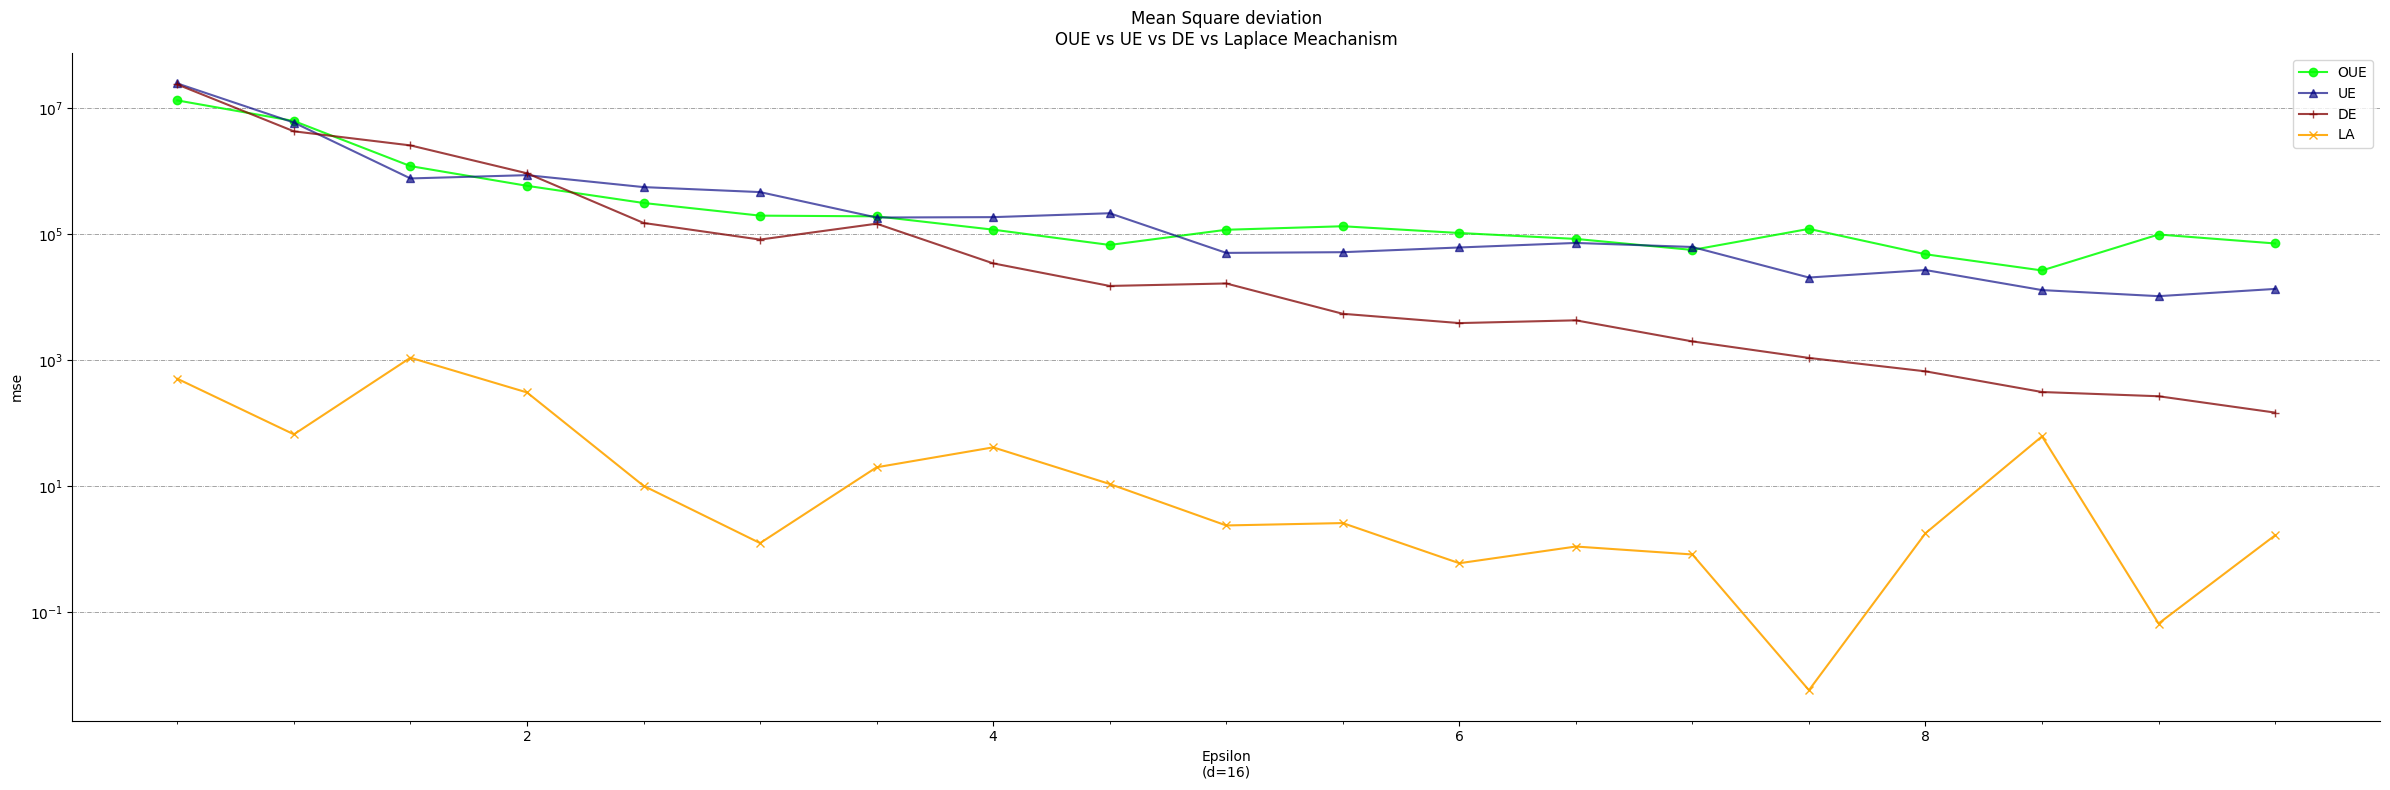

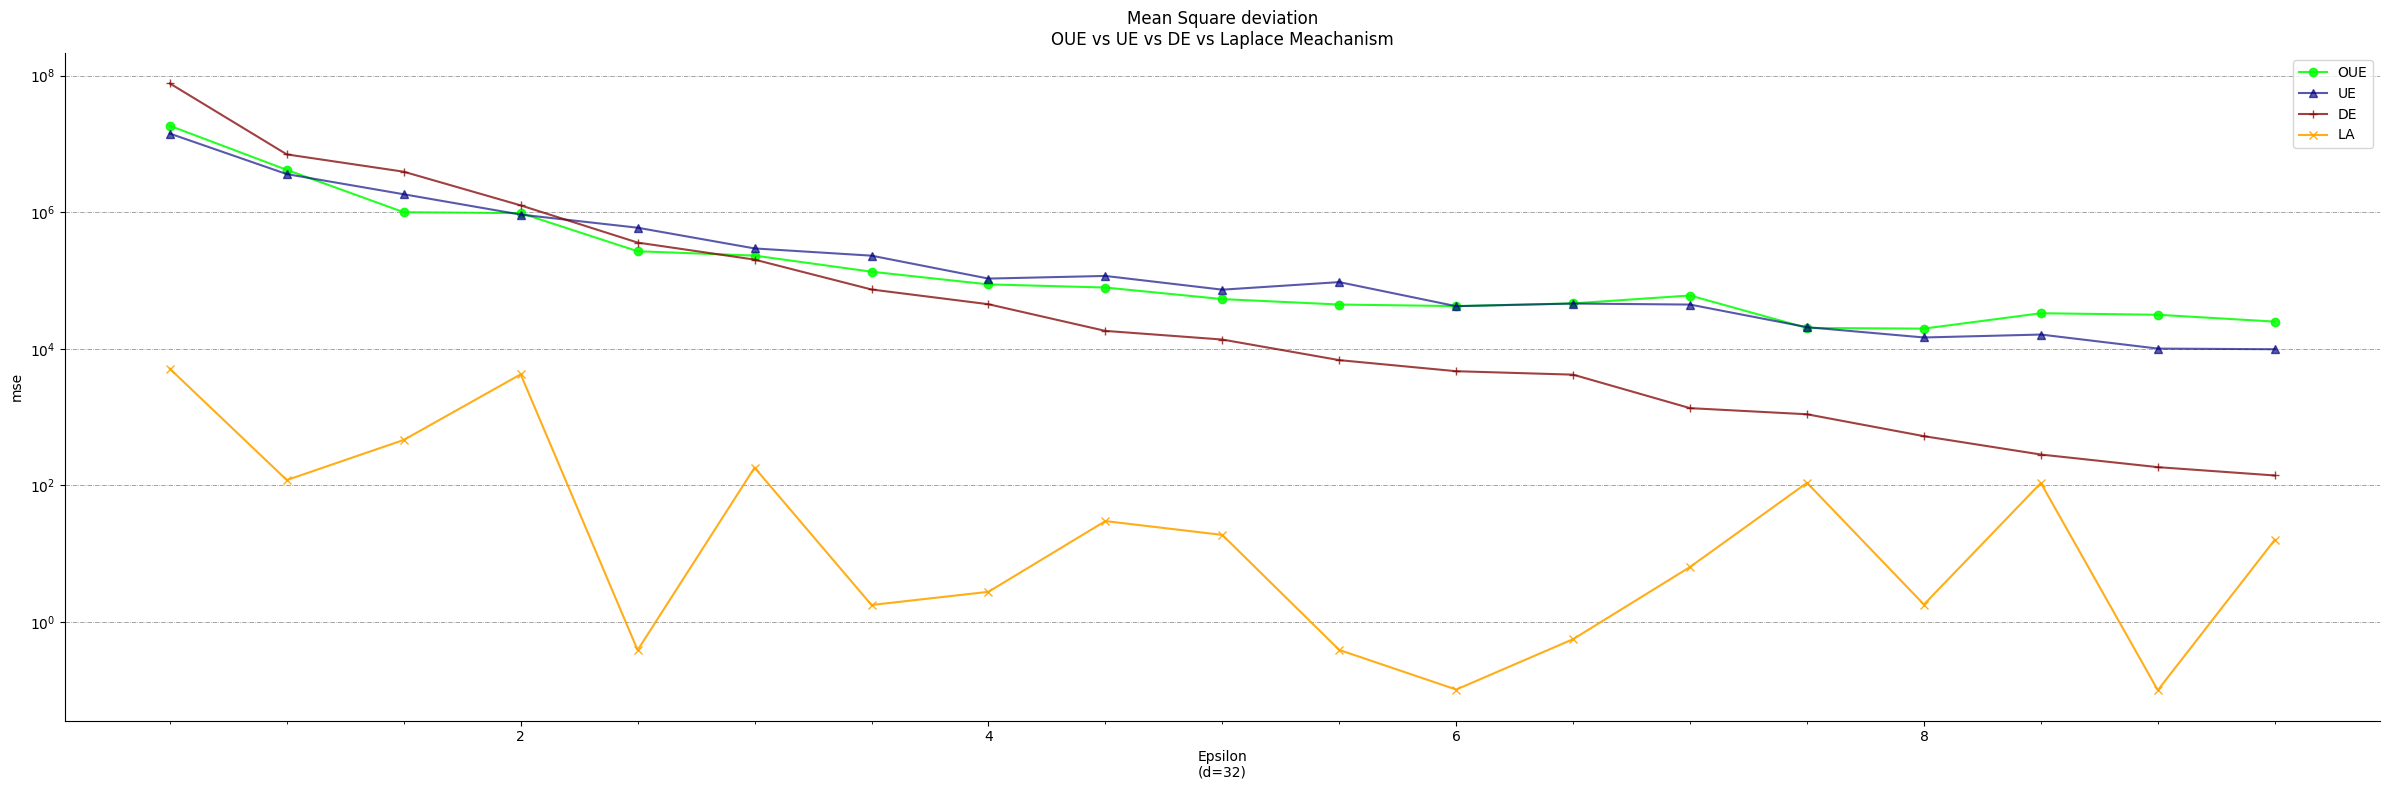

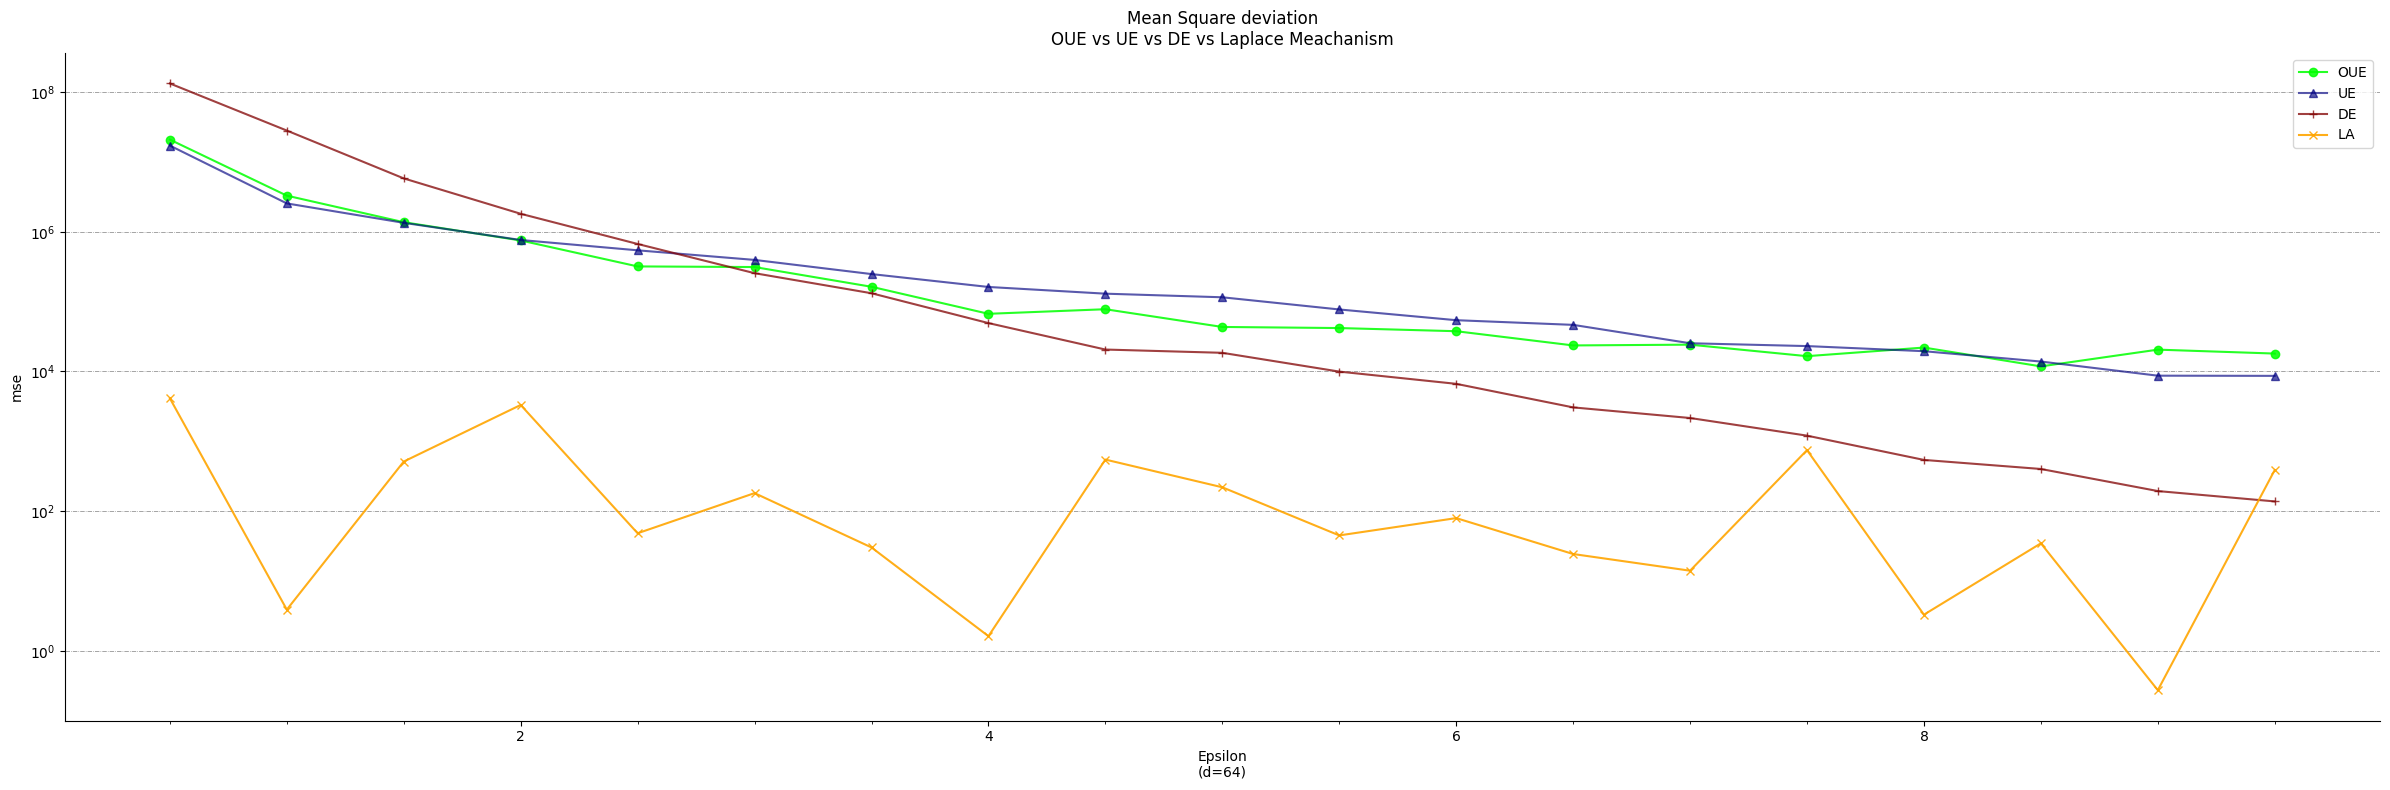

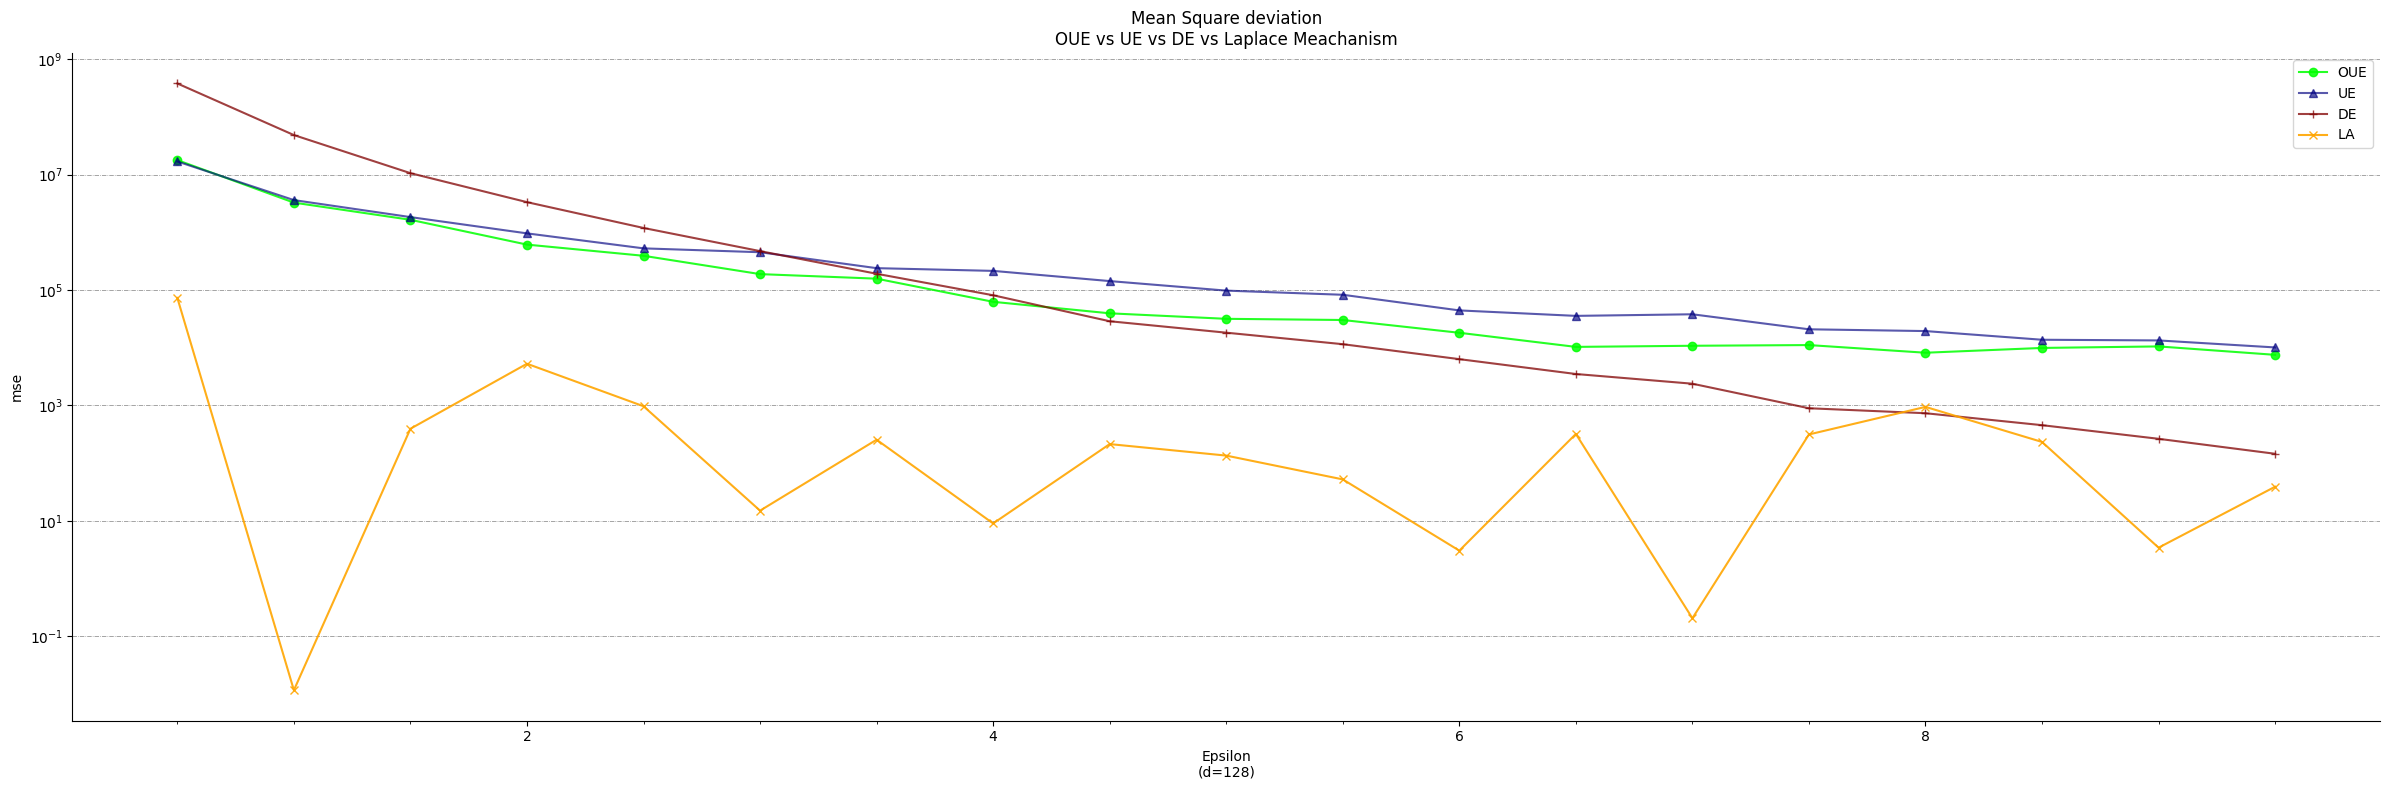

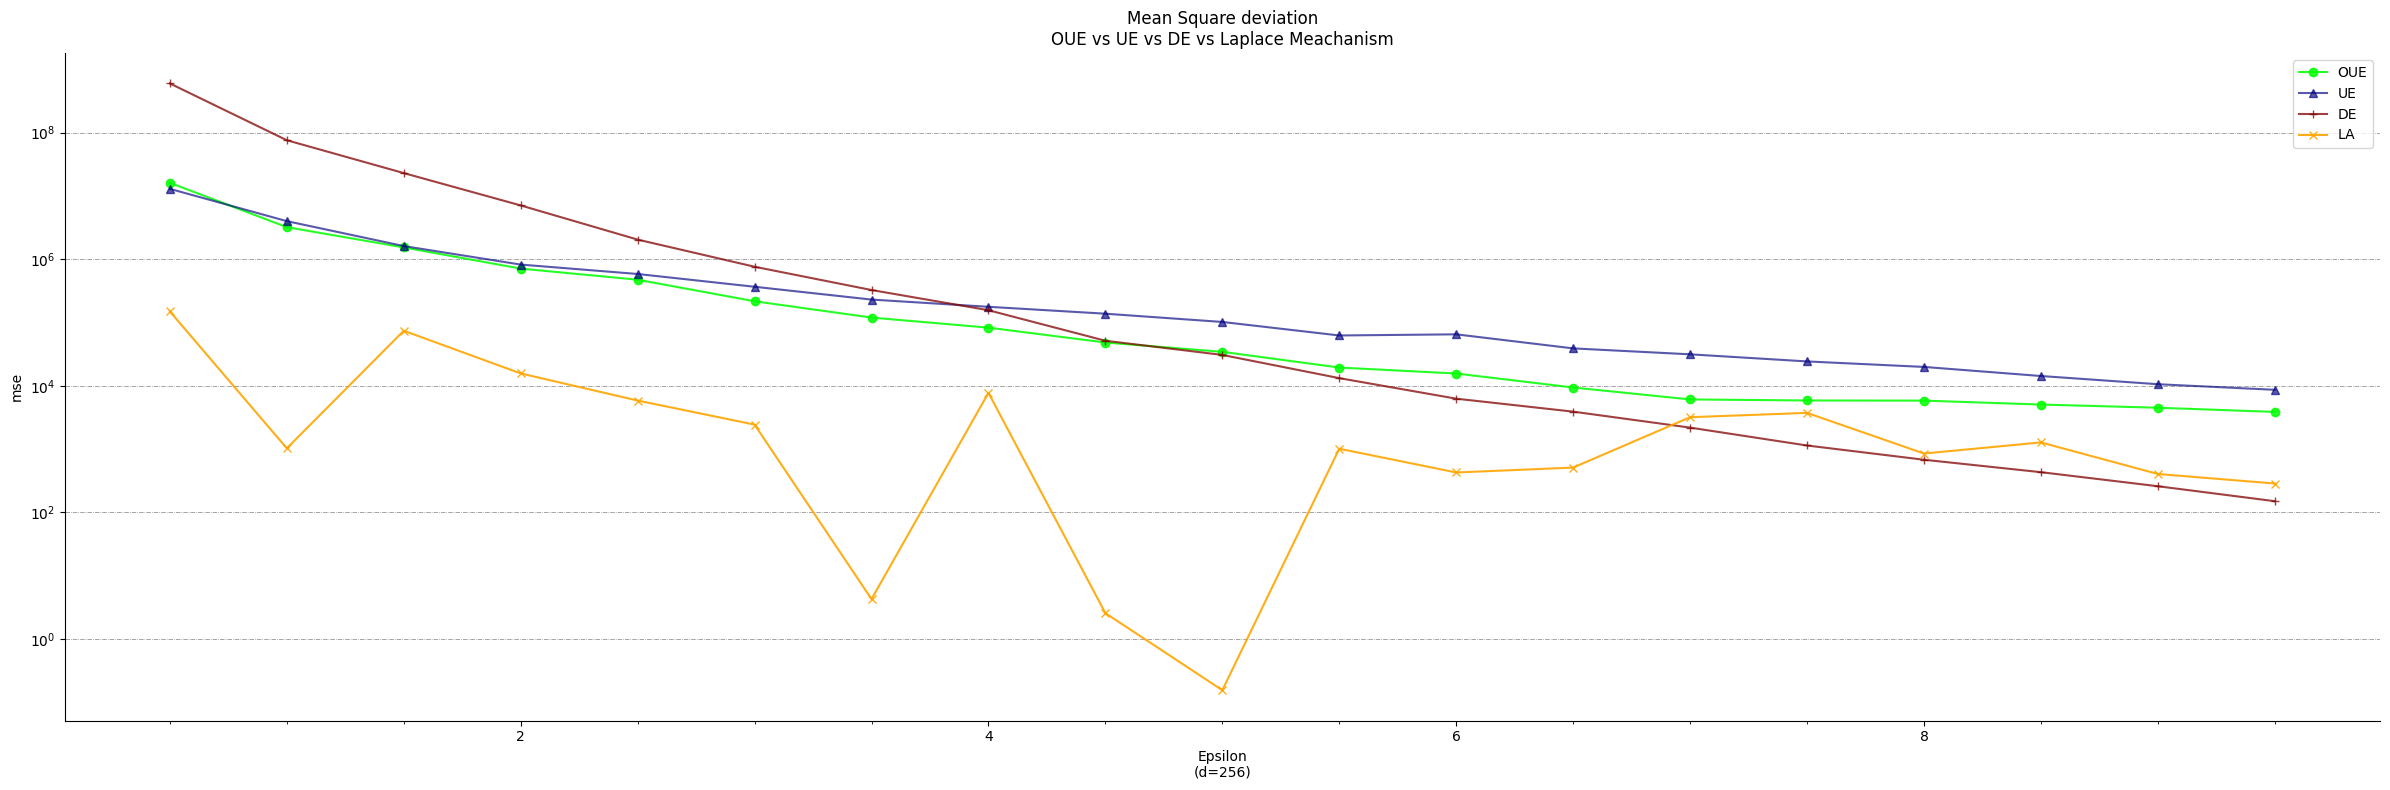

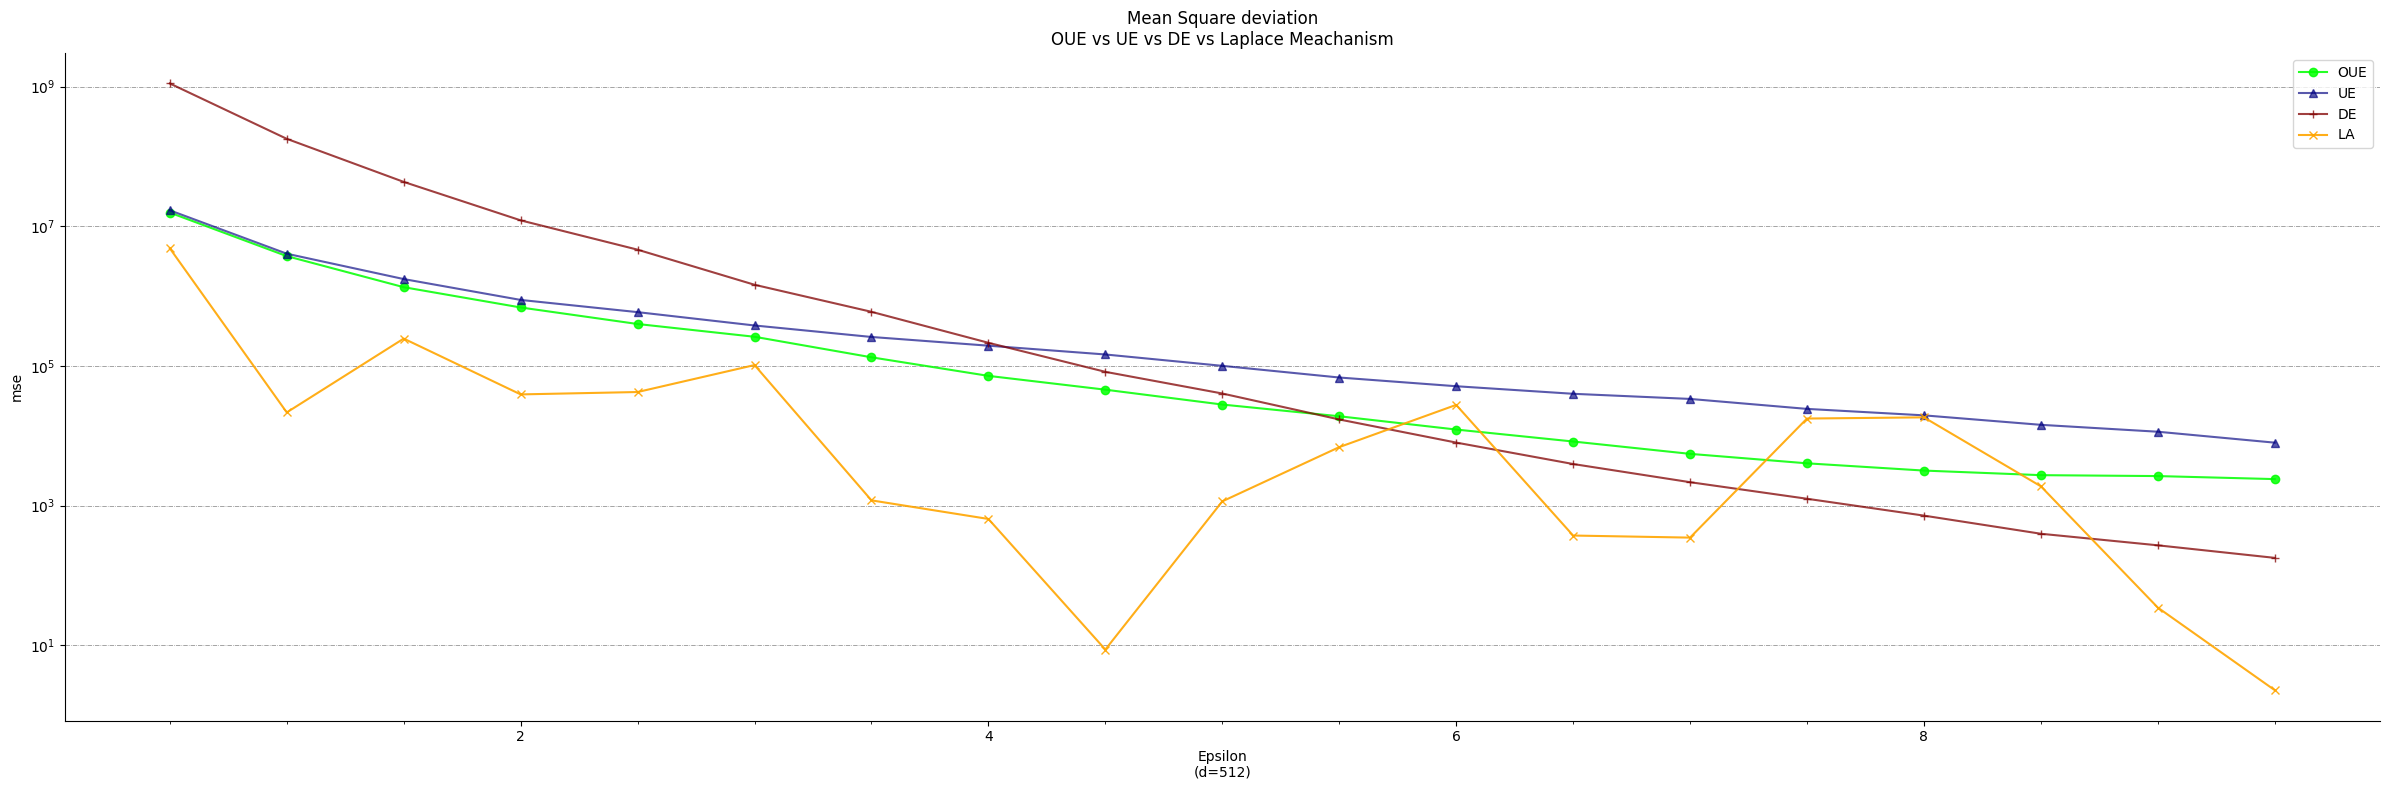

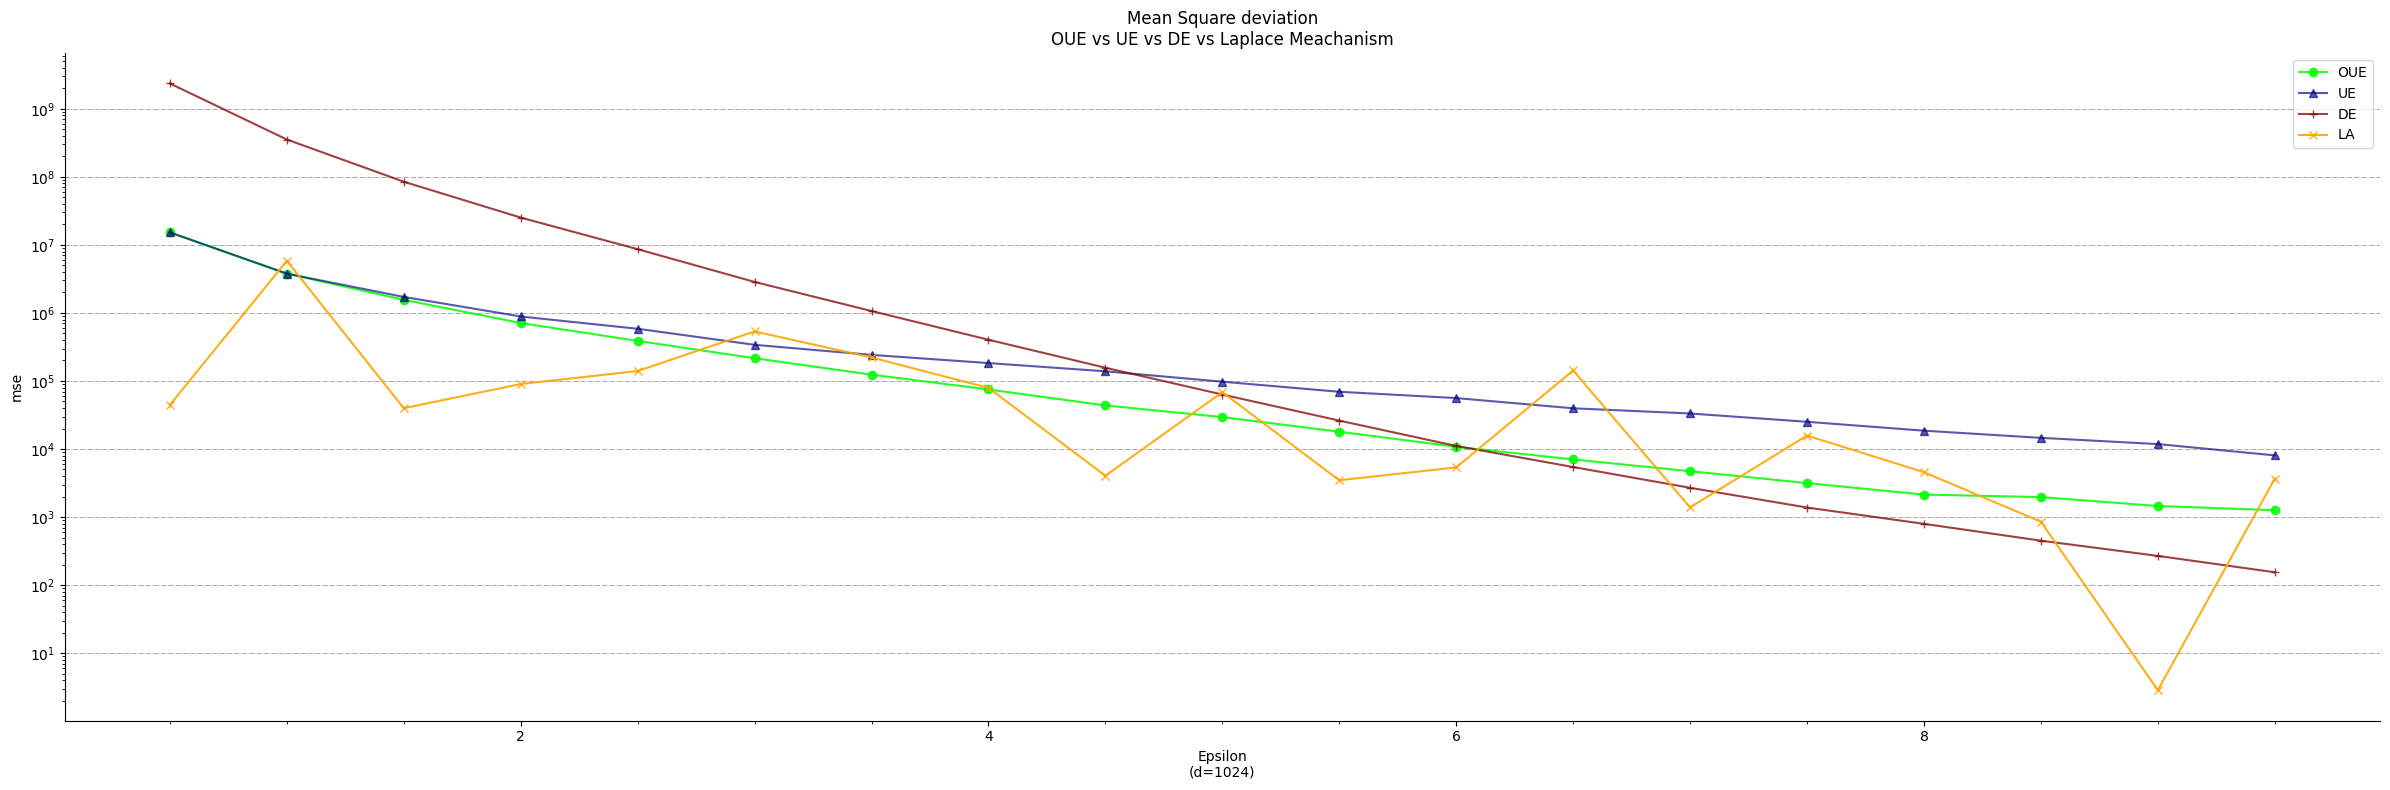

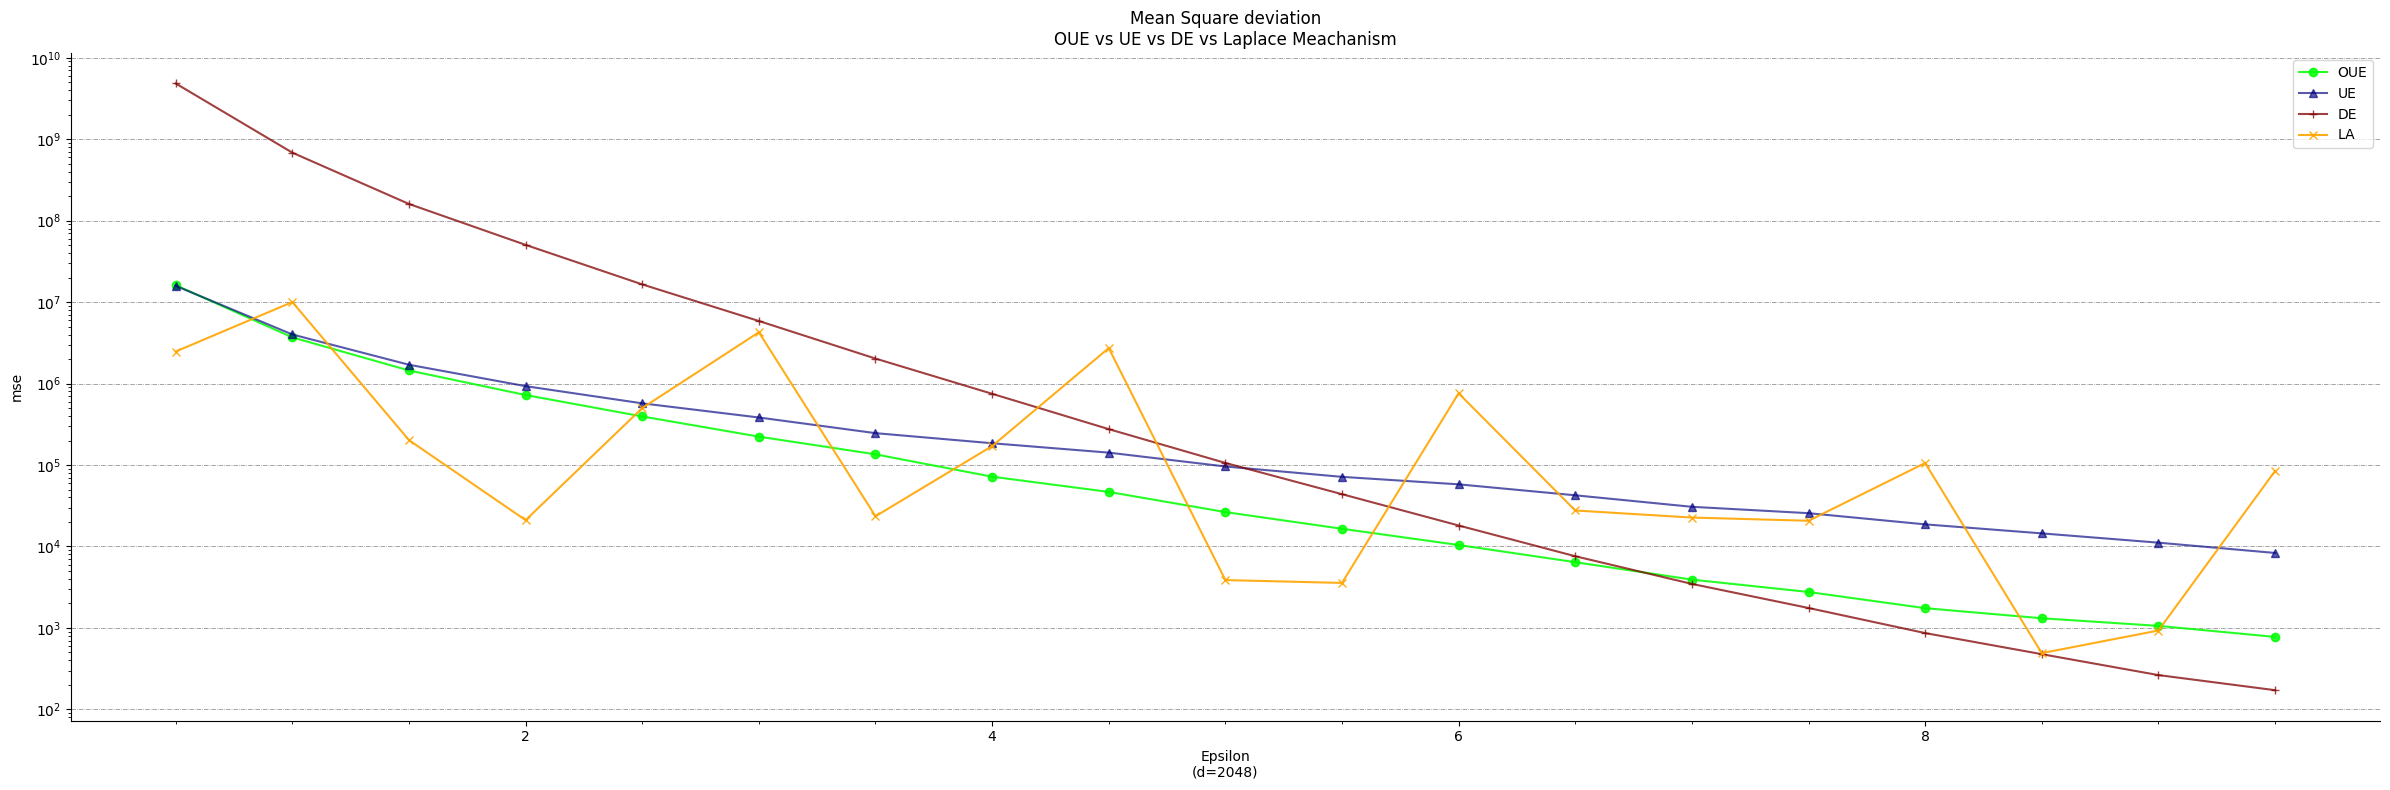

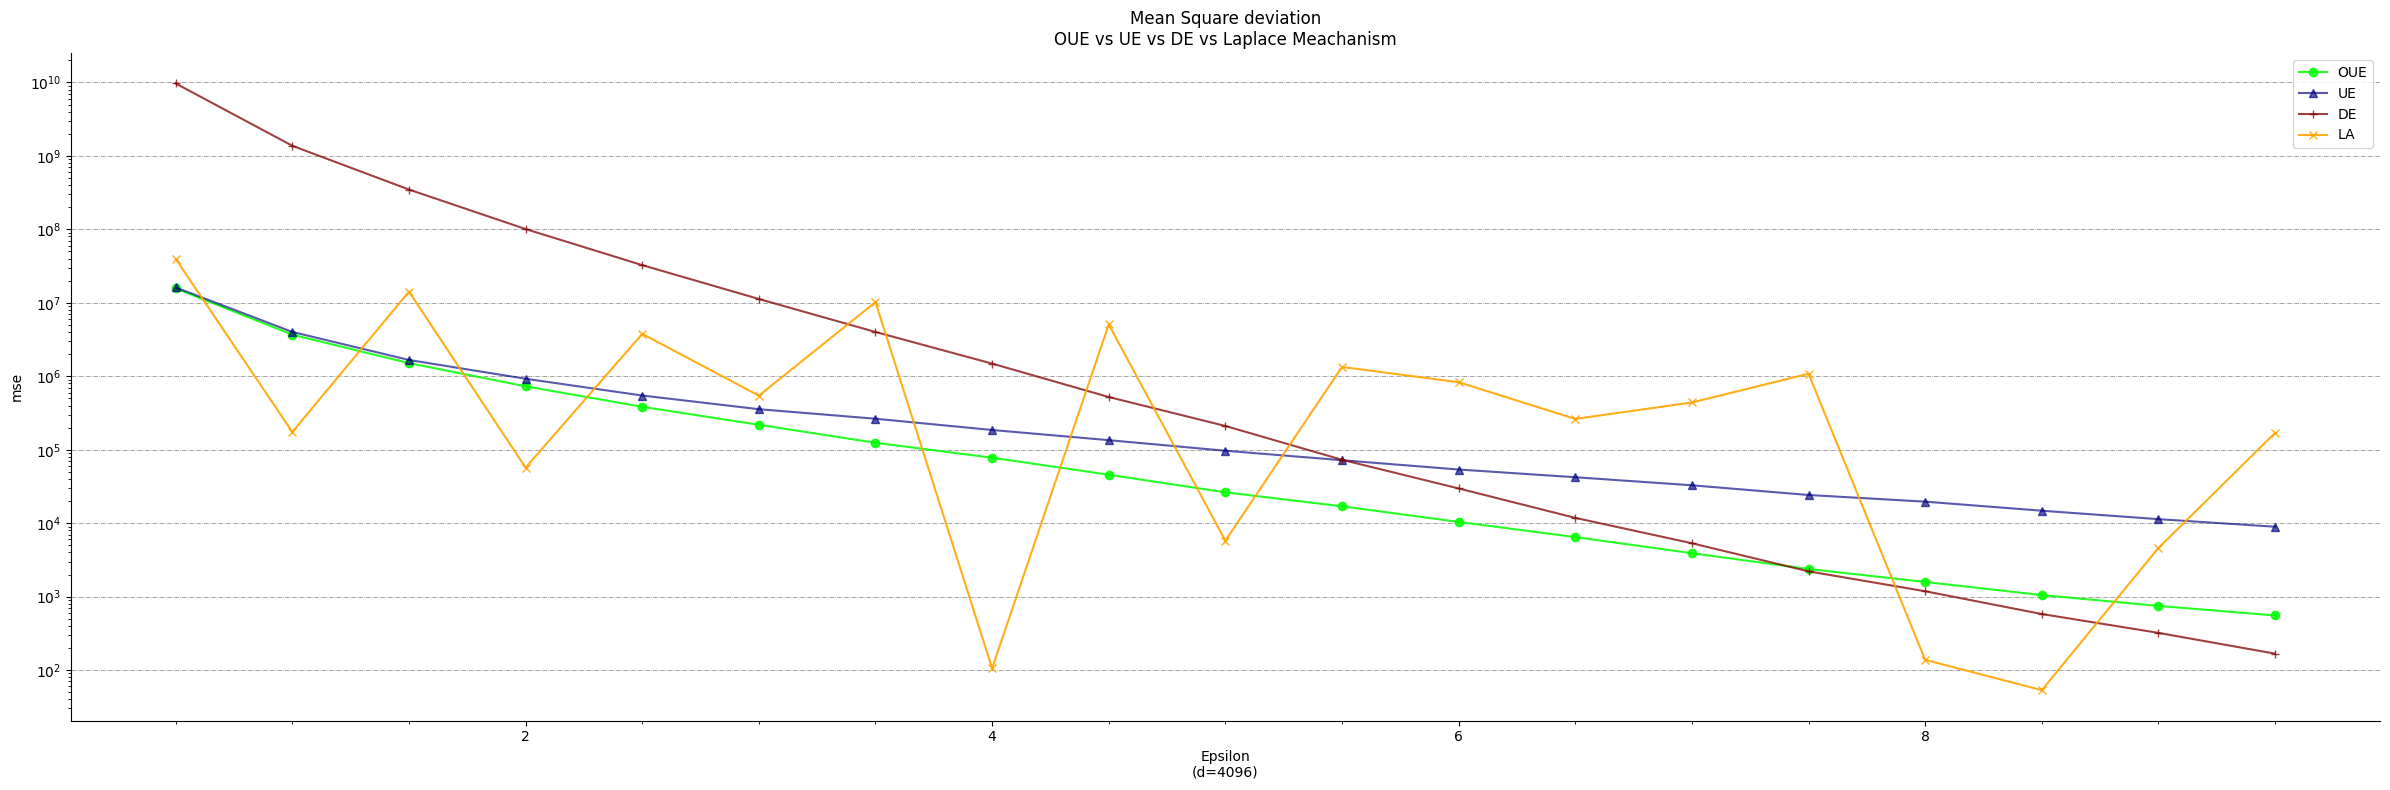

In [28]:
for i in range(1,13):
    d = 2**i

    eRange = 10

    normal_args = {
        'd': d,
        'mean': d/2,
        'std': d/4,
        'start': 0,
        'n': 10**6
    }

    comparator2(normal, eRange, **normal_args)

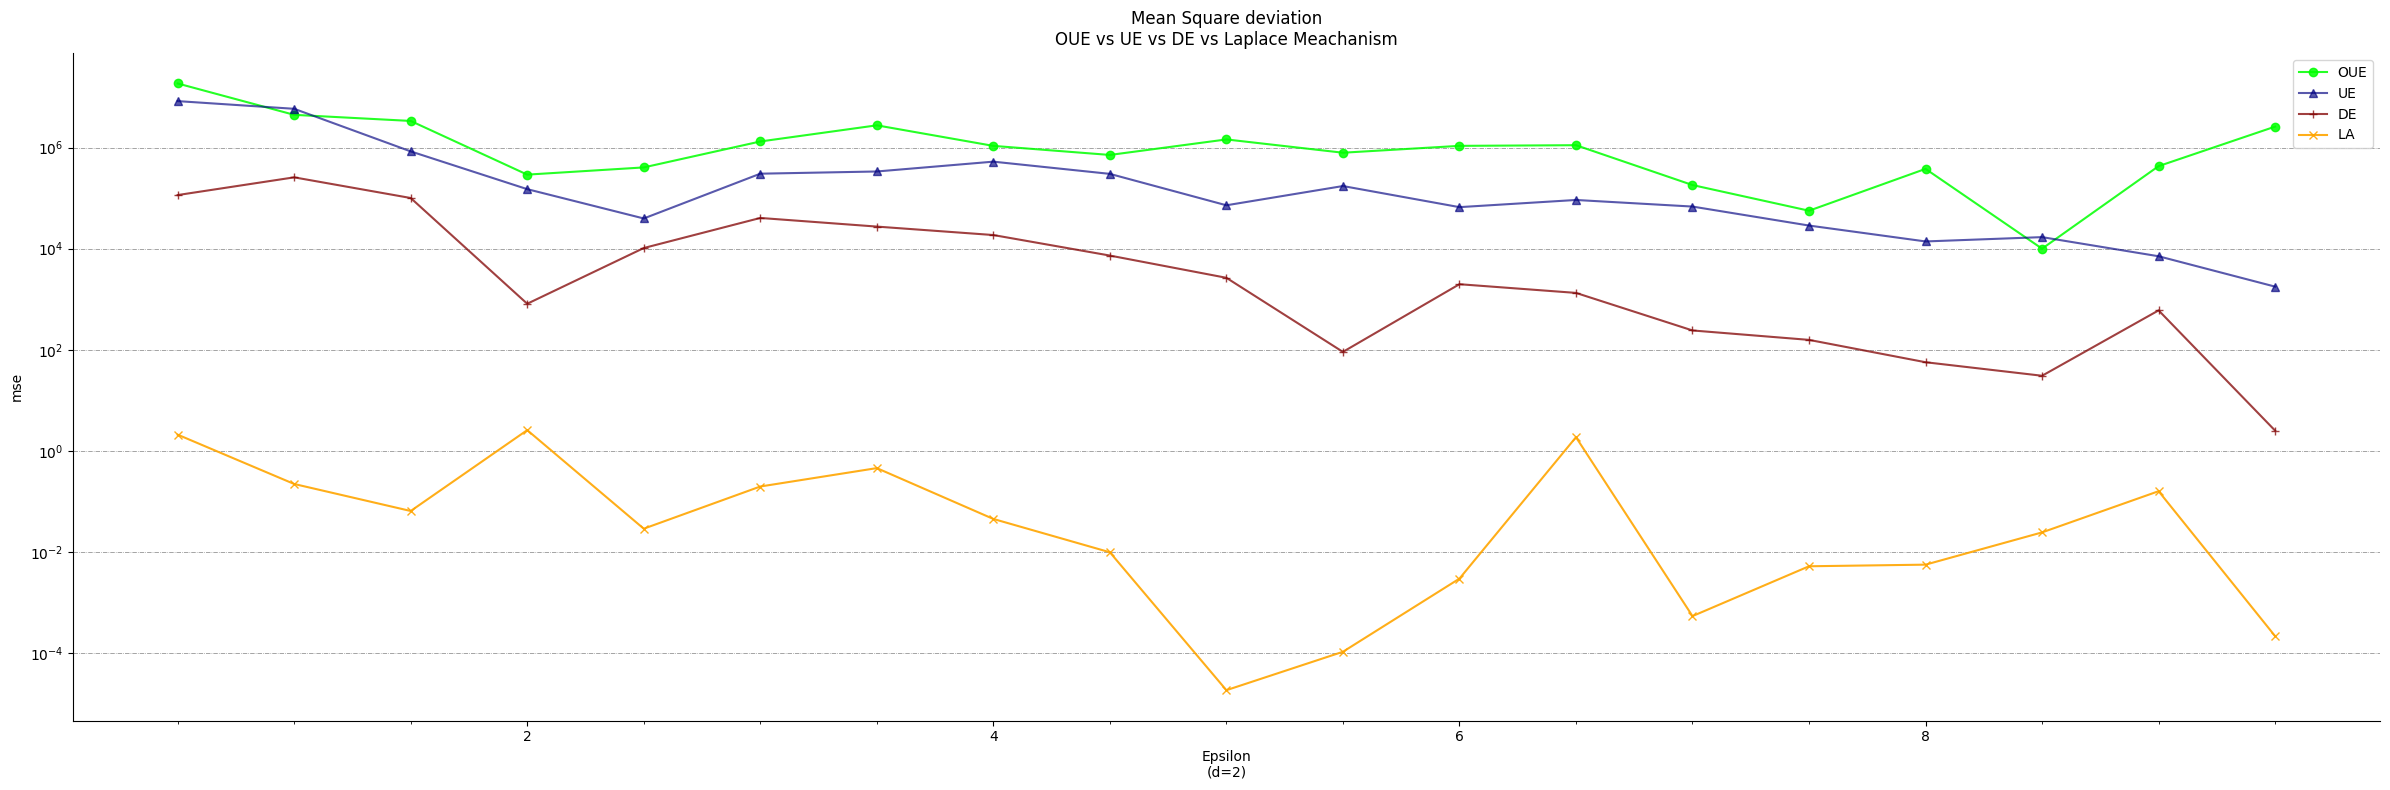

KeyboardInterrupt: 

In [33]:
for i in range(1,13):
    d = 2**i

    eRange = 10

    zipf_args = {
        'a': 1.5,
        'n': 10**6,
        'd': d
    }
    
    comparator2(zipf, eRange, **zipf_args)